# Analysis

In [ ]:
from scipy.stats import mannwhitneyu

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import matplotlib.colors as mcolors

In [ ]:
# input data folders
PERFORMANCEDIR = "path/to/performance/dir"

# test negative data types
BGTEST = ["shuffle", "dnase-1", "dnase"]
DBDDICT = "dbd.pickle"

COLORS = {"meme": ["#f7b32b", "#d9940a", "#b57900"], "streme": ["#399be8", "#1679c6", "#005ca3"], "svm": ["#ec8746", "#d96b24", "#bf4e05"]}
TOOLS = ['meme', 'streme', 'svm']

# test negative data types
BGTEST = ["shuffle", "dnase-1", "dnase"]
BGTRAIN = ["dnase", "shuffle"]


## Compare performance training models using globally optimal sequence features next to locally optimal sequence features (dashed bars)

In [3]:
def compute_raw_values(infolder, tool, metric, optimal):
    """Retrieve raw values for a given tool, metric, and optimization level."""
    fname = os.path.join(infolder, f"summary_table_{optimal}_{tool}.tsv")
    table = pd.read_csv(fname, sep="\t")
    return table[metric].values  

def compute_mann_whitney(data1, data2):
    """Compute the Mann-Whitney U test between two distributions."""
    stat, p_value = mannwhitneyu(data1, data2, alternative='two-sided')
    return stat, p_value

def plot(data, errors, labels, group_labels, metric):
    num_groups = len(group_labels)
    num_bars = len(data)
    x = np.arange(num_groups) * 2  # The label locations
    width = 0.1  # The width of the bars
    colors = ["#f7b32b", "#d9940a", "#b57900", "#399be8", "#1679c6", "#005ca3", "#ec8746", "#d96b24", "#bf4e05"]
    
    f, ax = plt.subplots(figsize=(30, 15))
    
    for i, (values, errs, label) in enumerate(zip(data, errors, labels)):
        hatch = "//" if i % 2 != 0 else None
        bars = ax.bar(x + i * width, values, width, label=label, color=colors[i // 2], 
                      hatch=hatch, edgecolor="black", yerr=errs, capsize=5)
        
        # Add value labels
        for bar, value, err in zip(bars, values, errs):
            ax.text(bar.get_x() + bar.get_width() / 2, value + err, f'{value:.2f}', 
                    ha='center', va='bottom', fontsize=18)

    ax.set_xlabel("Training Background Data", size=18)
    #ax.set_ylabel(metric, size=20)
    ax.set_title(f"{metric}", size=30)
    ax.spines[['right', 'top']].set_visible(False)
    
    ax.set_xticks(x + width * (num_bars / 2 - 0.5))
    ax.set_xticklabels(group_labels, size=20)
    #ax.legend(fontsize=20)
    ax.tick_params(axis='y', labelsize=20)
    plt.show()
    #f.savefig(f"results/glob_opt/{metric}_global_optimal.svg", dpi=300)

def barplot_and_mannwhitney(infolder_glob, infolder_loc, metric):
    bgtrain = ["shuffle", "dnase"]
    tools = ["meme", "streme", "svm"]
    optimals = ['global', 'local']
    
    data = [[] for _ in range(18)]
    errors = [[] for _ in range(18)]
    results = []

    for bg in bgtrain:
        for i, (trainbg, testbg) in enumerate([(bg, bt) for bt in BGTEST]):
            tables_glob = os.path.join(infolder_glob, f"{trainbg}-{testbg}")
            tables_loc = os.path.join(infolder_loc, f"{trainbg}-{testbg}")

            for tool_idx, tool in enumerate(tools):
                values_glob = compute_raw_values(tables_glob, tool, metric, 'global')
                values_loc = compute_raw_values(tables_loc, tool, metric, 'local')

                mean_glob, std_glob = np.mean(values_glob).round(2), np.std(values_glob).round(2)
                mean_loc, std_loc = np.mean(values_loc).round(2), np.std(values_loc).round(2)

                base_idx = tool_idx * 6  # Offset for meme, streme, svm
                data[base_idx + i * 2].append(mean_glob)
                errors[base_idx + i * 2].append(std_glob)

                data[base_idx + i * 2 + 1].append(mean_loc)
                errors[base_idx + i * 2 + 1].append(std_loc)

                # Mann-Whitney U test
                stat, p_value = compute_mann_whitney(values_glob, values_loc)
                results.append([tool.upper(), testbg, mean_glob, std_glob, mean_loc, std_loc, stat, p_value])

    results_df = pd.DataFrame(results, columns=[
        "Tool", "Test Background", "Global Mean", "Global Std", 
        "Local Mean", "Local Std", "U-Stat", "P-Value"
    ])

    # Stats table
    print("\n### Mann-Whitney U Test Results ###")
    print(results_df.to_string(index=False))  # Print without row index
    #results_df.to_csv(f"mann_whitney_results_{metric}.tsv", sep = "\t", index=False)
    #results_df.to_excel(f"mann_whitney_results_{metric}.xlsx", index=False)
    labels = [f"{tool.upper()} - test background: {testbg} - {optima} optimal"
              for tool in tools for testbg in BGTEST for optima in optimals]
    
    bgtrain_labs = ["Synthetic", "Real Biological"]
    plot(data, errors, labels, bgtrain_labs, metric)



### Mann-Whitney U Test Results ###
  Tool Test Background  Global Mean  Global Std  Local Mean  Local Std  U-Stat  P-Value
  MEME         shuffle         0.68        0.10        0.69       0.10  1562.5 0.339395
STREME         shuffle         0.72        0.08        0.70       0.09  1954.0 0.251617
   SVM         shuffle         0.97        0.01        0.97       0.01  1739.5 0.997853
  MEME         dnase-1         0.77        0.09        0.77       0.08  1689.5 0.785771
STREME         dnase-1         0.78        0.09        0.77       0.09  1849.0 0.561046
   SVM         dnase-1         0.78        0.06        0.78       0.06  1738.5 0.993558
  MEME           dnase         0.33        0.16        0.34       0.15  1642.5 0.599739
STREME           dnase         0.37        0.16        0.35       0.16  1838.0 0.601612
   SVM           dnase         0.30        0.11        0.30       0.11  1739.5 0.997853
  MEME         shuffle         0.68        0.10        0.69       0.10  1562.5 0.33

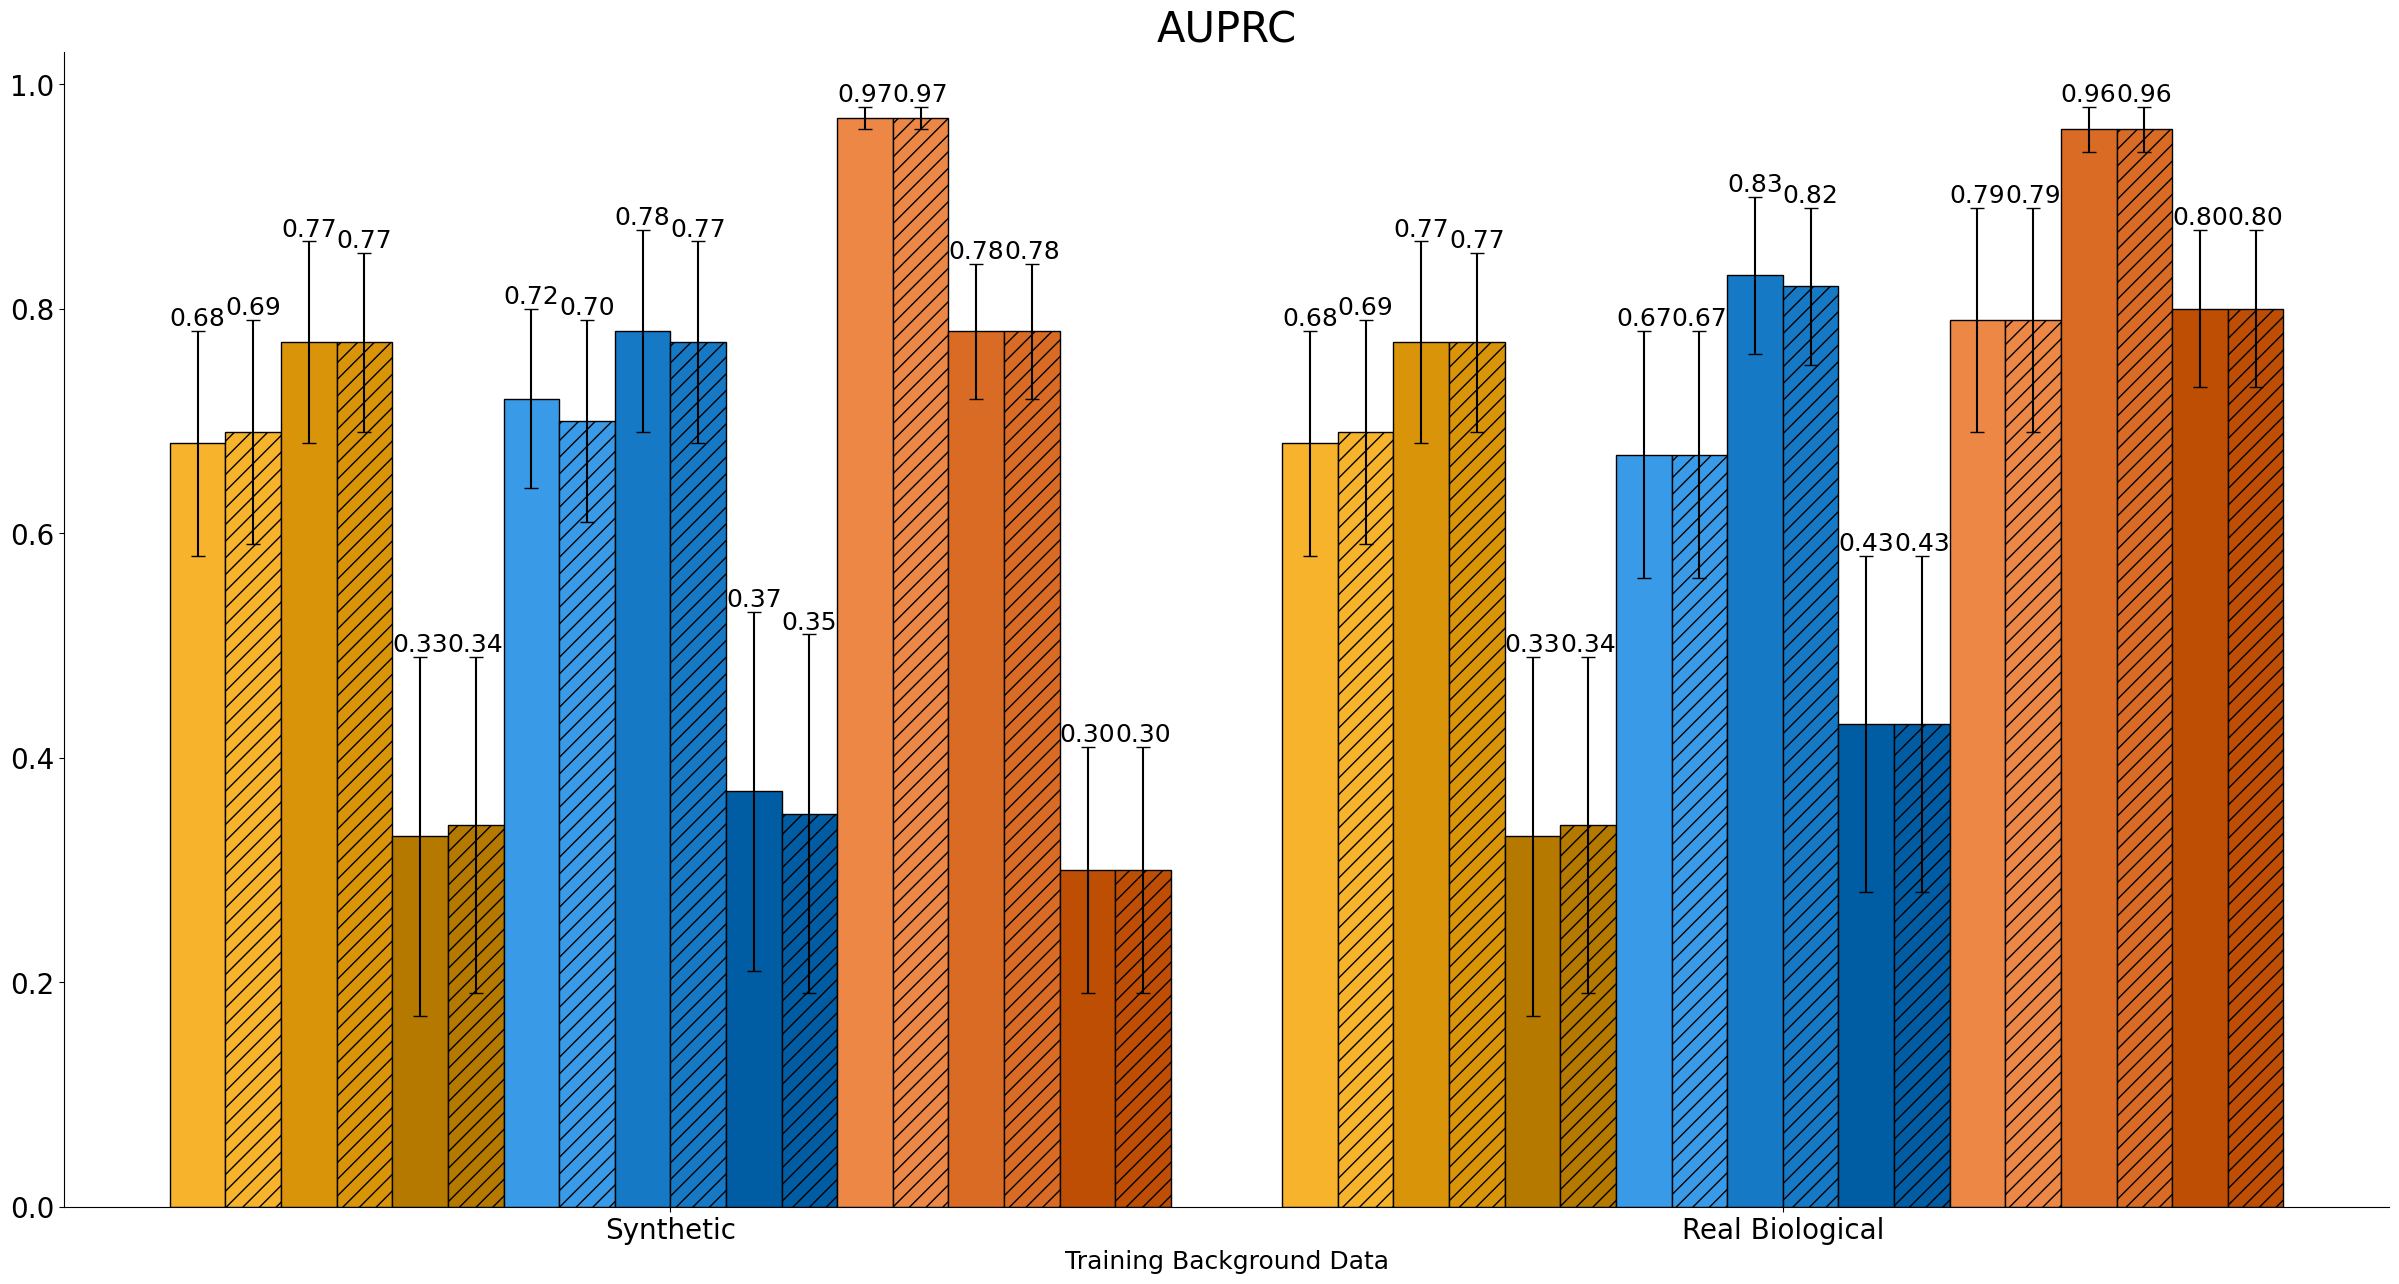

In [4]:
# AUPRC
global_dir = os.path.join(PERFORMANCEDIR, "optimal-global")
local_dir = os.path.join(PERFORMANCEDIR, 'optimal-local')
barplot_and_mannwhitney(global_dir, local_dir, "AUPRC")


### Mann-Whitney U Test Results ###
  Tool Test Background  Global Mean  Global Std  Local Mean  Local Std  U-Stat  P-Value
  MEME         shuffle         0.66        0.10        0.67       0.10  1628.5 0.548421
STREME         shuffle         0.70        0.09        0.68       0.09  1997.0 0.168243
   SVM         shuffle         0.97        0.01        0.97       0.01  1742.5 0.993558
  MEME         dnase-1         0.77        0.09        0.78       0.09  1697.5 0.819064
STREME         dnase-1         0.78        0.10        0.77       0.10  1841.0 0.590418
   SVM         dnase-1         0.80        0.05        0.80       0.05  1738.5 0.993558
  MEME           dnase         0.77        0.09        0.78       0.09  1702.5 0.840044
STREME           dnase         0.78        0.10        0.77       0.10  1847.0 0.568322
   SVM           dnase         0.81        0.05        0.81       0.05  1738.5 0.993558
  MEME         shuffle         0.66        0.10        0.67       0.10  1628.5 0.54

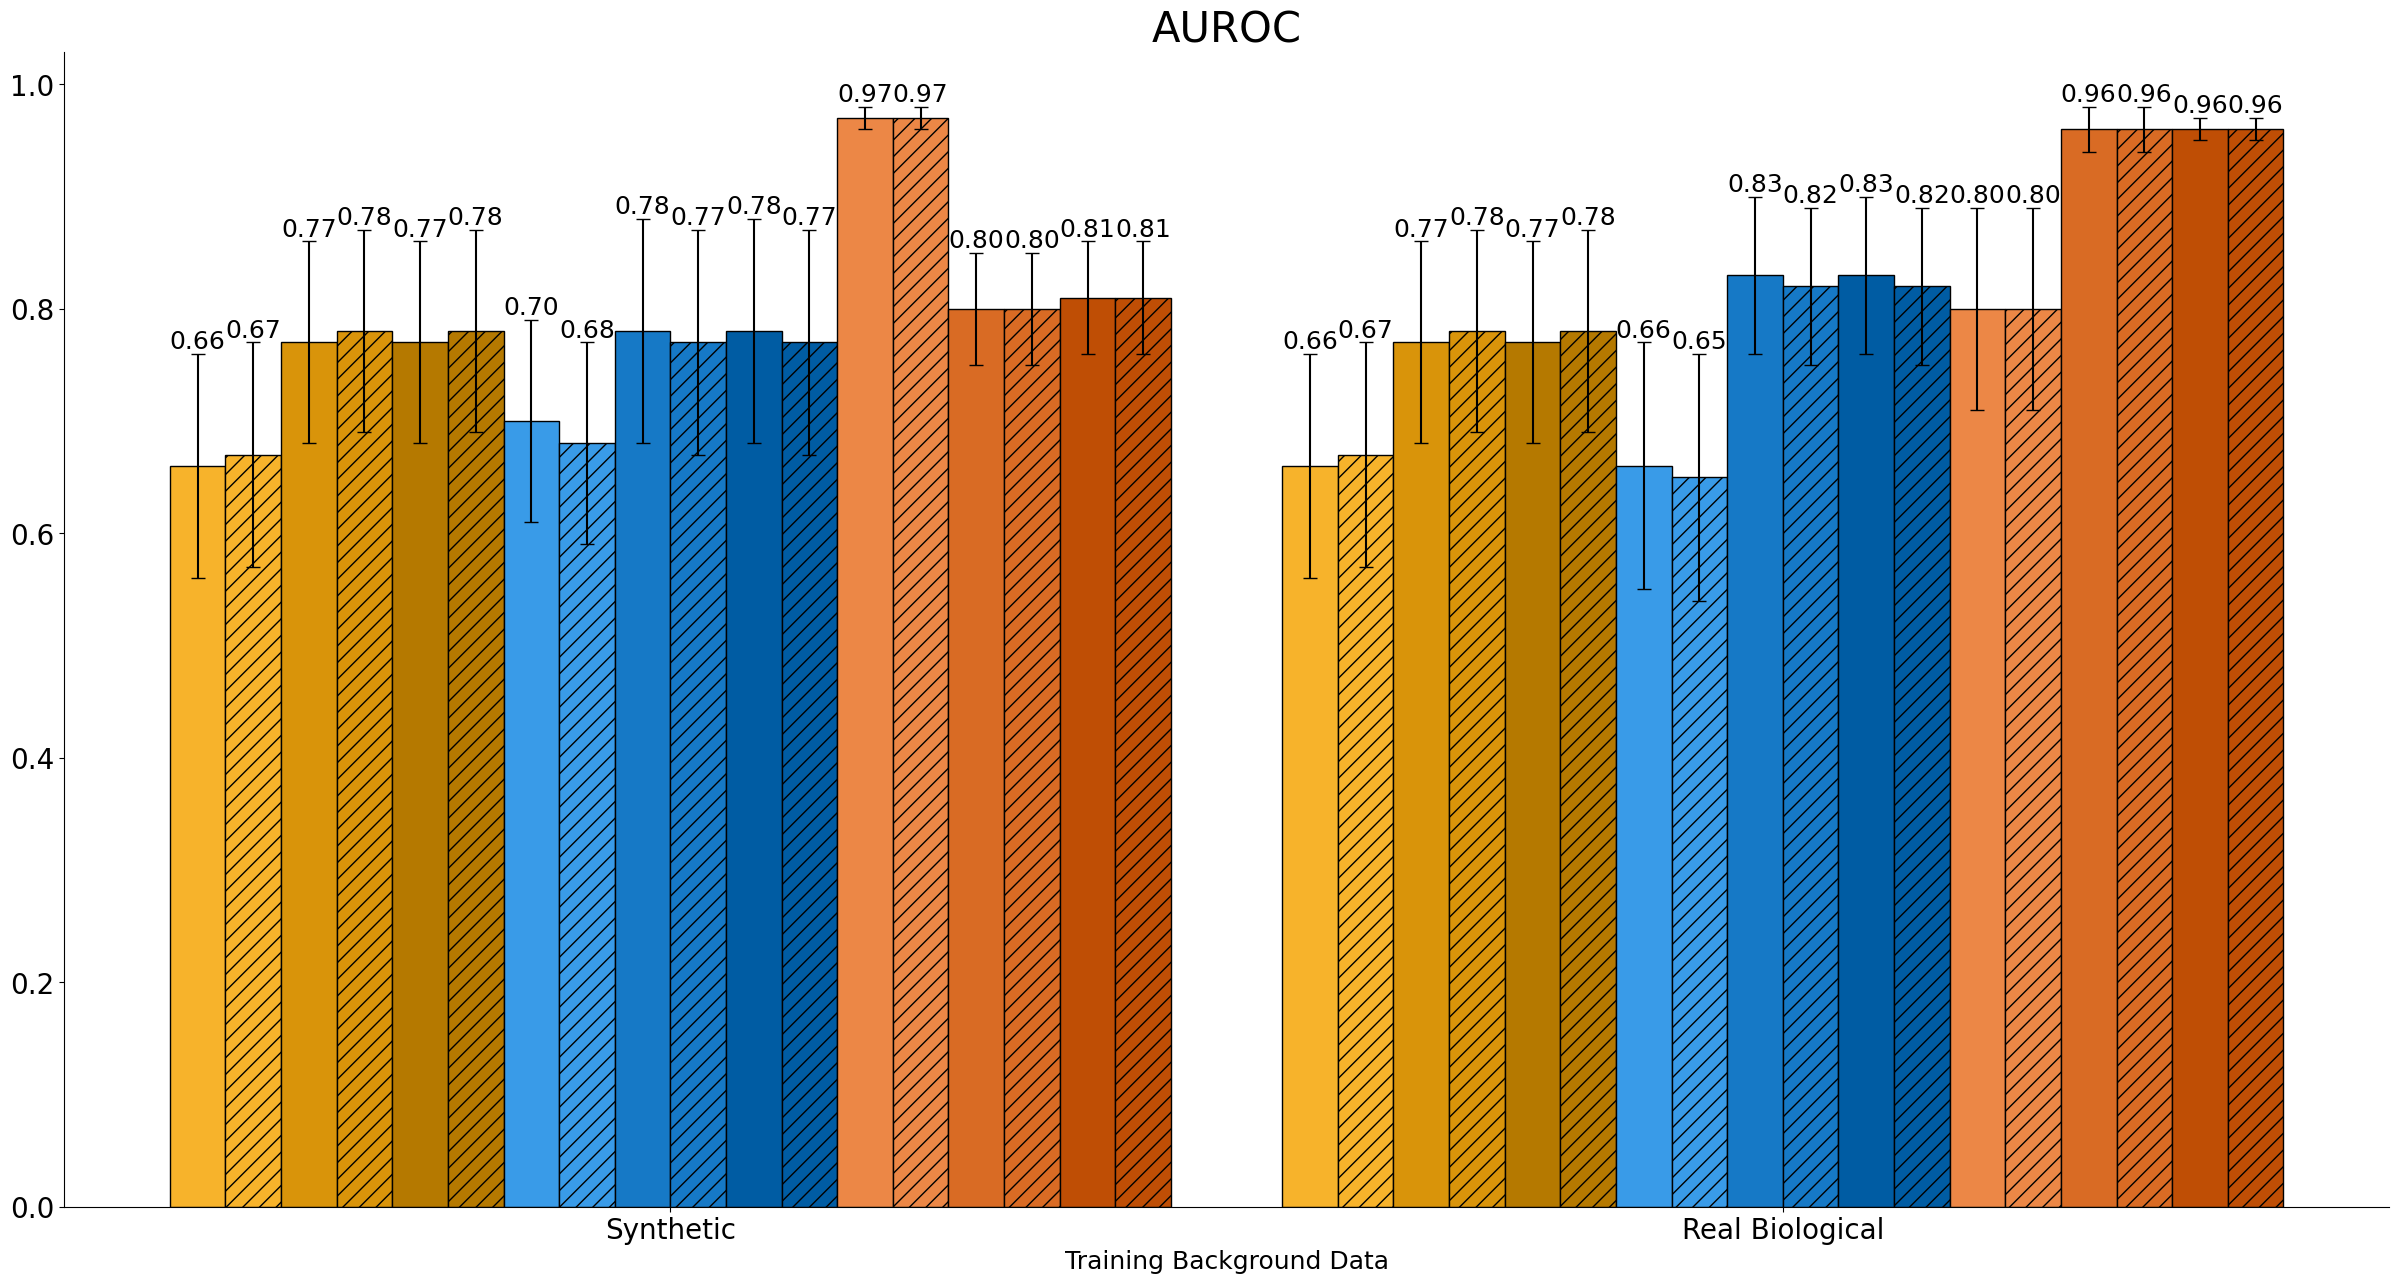

In [5]:
# AUROC
global_dir = os.path.join(PERFORMANCEDIR, "optimal-global")
local_dir = os.path.join(PERFORMANCEDIR, 'optimal-local')
barplot_and_mannwhitney(global_dir, local_dir, "AUROC")


### Mann-Whitney U Test Results ###
  Tool Test Background  Global Mean  Global Std  Local Mean  Local Std  U-Stat  P-Value
  MEME         shuffle         0.45        0.16        0.48       0.15  1468.5 0.143932
STREME         shuffle         0.50        0.15        0.46       0.16  1954.0 0.251617
   SVM         shuffle         0.91        0.01        0.91       0.01  1742.5 0.993558
  MEME         dnase-1         0.47        0.17        0.51       0.16  1491.5 0.181056
STREME         dnase-1         0.53        0.17        0.48       0.18  1966.0 0.225888
   SVM         dnase-1         0.75        0.03        0.75       0.04  1738.5 0.993558
  MEME           dnase         0.34        0.13        0.35       0.12  1603.5 0.462529
STREME           dnase         0.37        0.12        0.35       0.14  1913.0 0.354573
   SVM           dnase         0.27        0.04        0.27       0.04  1738.5 0.993558
  MEME         shuffle         0.45        0.16        0.48       0.15  1468.5 0.14

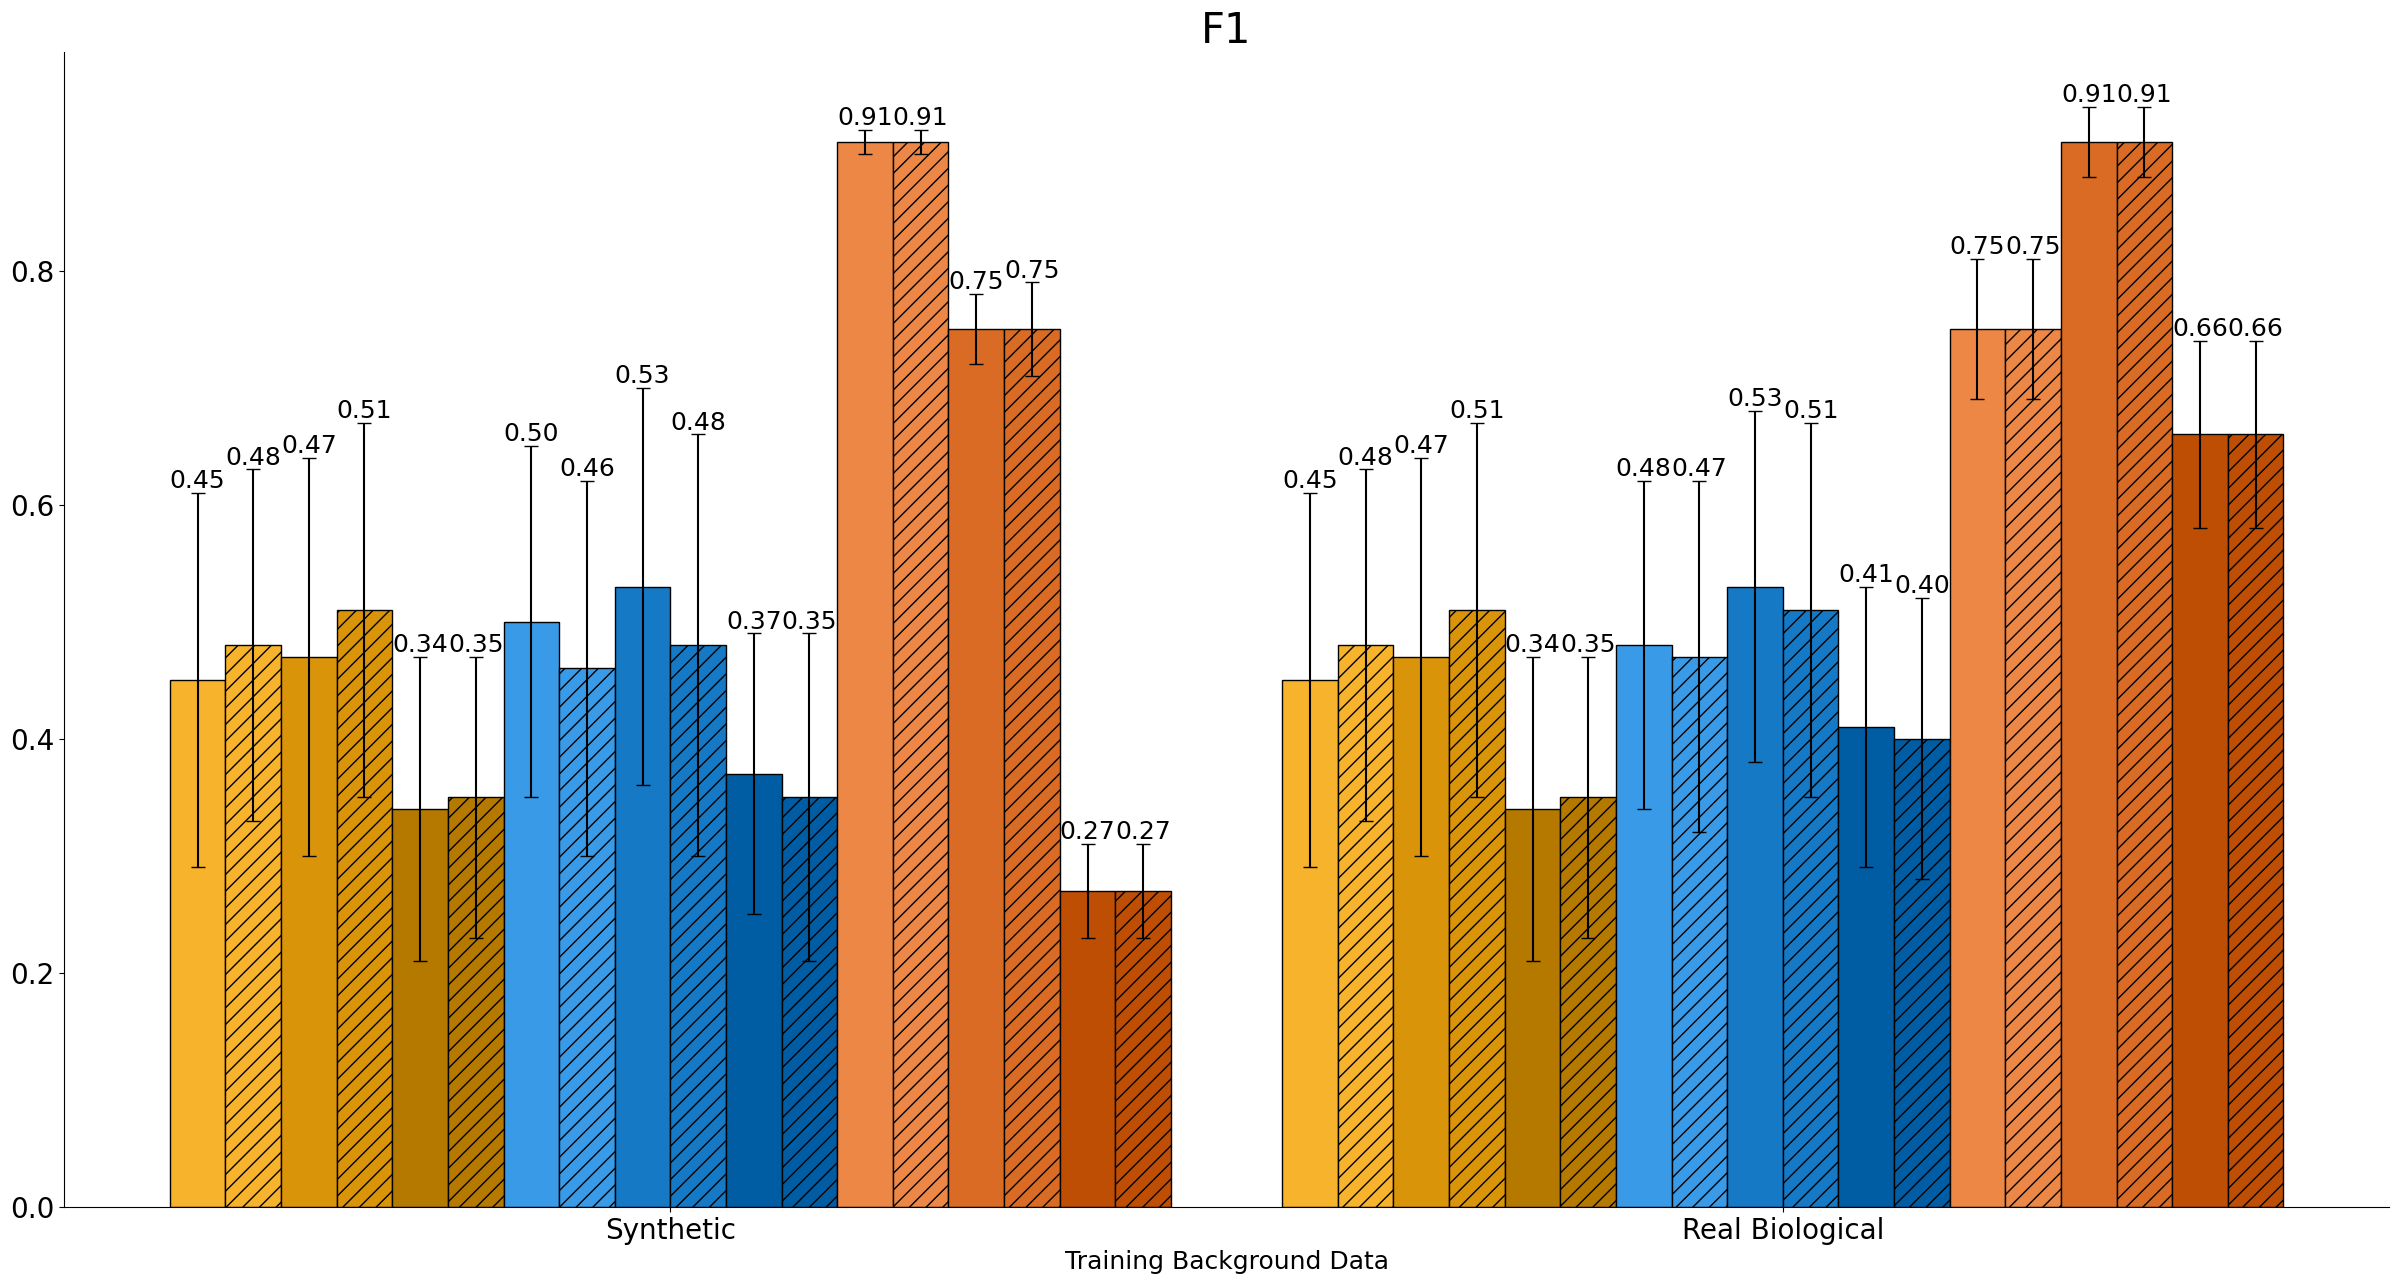

In [6]:
# F1
global_dir = os.path.join(PERFORMANCEDIR, "optimal-global")
local_dir = os.path.join(PERFORMANCEDIR, 'optimal-local')
barplot_and_mannwhitney(global_dir, local_dir, "F1")

## Compare performance training models using different widths of training sequences

In [9]:
def compute_mean_and_std(infolder, width, tool, metric):
    fname = os.path.join(infolder, f"summary_table_width_{width}_{tool}.tsv")
    table = pd.read_csv(fname, sep="\t")
    return np.mean(table[metric]).round(2), np.std(table[metric]).round(2)


def plot_subplot(ax, data, errors, labels, group_labels, metric, bg, tool):
    num_groups = len(group_labels)
    num_bars = len(data)
    x = np.arange(num_groups) / 2  # The label locations
    width = 0.1  # The width of the bars
    colors = COLORS[tool]

    # Best value for "dnase-1"
    dnase_1_index = BGTEST.index("dnase-1") if "dnase-1" in BGTEST else None
    max_dnase_1_value = max(data[dnase_1_index]) if dnase_1_index is not None else None

    for i, (values, errs, label) in enumerate(zip(data, errors, labels)):
        bars = ax.bar(x + i * width, values, width, label=label, color=colors[i], yerr=errs, capsize=5)

        # Text labels
        for j, (bar, value, err) in enumerate(zip(bars, values, errs)):
            text_color = "red" if (dnase_1_index is not None and i == dnase_1_index and value == max_dnase_1_value) else "black"
            ax.text(bar.get_x() + bar.get_width() / 2, value + err, f'{value:.2f}', 
                    ha='center', va='bottom', fontsize=20, color=text_color, 
                    fontweight='bold' if text_color == "red" else "normal")

    ax.set_xlabel("Training Sequence width" if tool == "svm" else None, size=16)
    #ax.set_ylabel(metric, size=20)
    ax.set_xticks(x + width * (num_bars / 2 - 0.5))
    ax.set_xticklabels(group_labels, size=20)
    ax.tick_params(axis='y', labelsize=20) 
    ax.set_ylim(0, 1.05)
    #ax.legend(fontsize = 20)
    ax.spines[['right', 'top']].set_visible(False)

    


def barplot(infolder, metric):
    widths = [50, 100, 150, 200, "full"]
    t = ['meme', 'streme', 'svm']
    training_backgrounds = ["dnase", "shuffle"]
    
    for bg in training_backgrounds:
        fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 18))  

        for idx, tool in enumerate(t):
            data = [[] for _ in range(3)]
            errors = [[] for _ in range(3)]

            for width in widths:
                for i, (trainbg, testbg) in enumerate([(bg, bt) for bt in BGTEST]):
                    tablesdir = os.path.join(infolder, f"{trainbg}-{testbg}")
                    mean, std = compute_mean_and_std(tablesdir, width, tool, metric)
                    data[i].append(mean)
                    errors[i].append(std)

            labels = [f"{tool} - test background: {testbg}" for testbg in BGTEST]
            bgtitle = "real biological background data" if bg == "dnase" else "synthetic background data"

            plot_subplot(axes[idx], data, errors, labels, widths, metric, bgtitle, tool)

        fig.suptitle(f"{metric} - Training on {bgtitle}", fontsize=30)
        plt.tight_layout() 
        plt.show()

        #fig.savefig(f"results/sw/barplot_std/{metric}_Training_on_{bgtitle}.svg", dpi=300)
        
        

In [10]:
def compute_mean_and_std(infolder, width, tool, metric):
    fname = os.path.join(infolder, f"summary_table_width_{width}_{tool}.tsv")
    table = pd.read_csv(fname, sep="\t")
    return np.mean(table[metric]).round(2), np.std(table[metric]).round(2)


def plot_subplot(ax, data, errors, labels, group_labels, metric, bg, tool):
    num_groups = len(group_labels)
    num_bars = len(data)
    x = np.arange(num_groups) / 2  # The label locations
    width = 0.1  # The width of the bars
    colors = COLORS[tool]

    # Best value for "dnase-1"
    dnase_1_index = BGTEST.index("dnase-1") if "dnase-1" in BGTEST else None
    max_dnase_1_value = max(data[dnase_1_index]) if dnase_1_index is not None else None

    for i, (values, errs, label) in enumerate(zip(data, errors, labels)):
        bars = ax.bar(x + i * width, values, width, label=label, color=colors[i], yerr=errs, capsize=5)

        # Text labels
        for j, (bar, value, err) in enumerate(zip(bars, values, errs)):
            text_color = "red" if (dnase_1_index is not None and i == dnase_1_index and value == max_dnase_1_value) else "black"
            ax.text(bar.get_x() + bar.get_width() / 2, value + err, f'{value:.2f}', 
                    ha='center', va='bottom', fontsize=20, color=text_color, 
                    fontweight='bold' if text_color == "red" else "normal")

    ax.set_xlabel("Training Sequence width" if tool == "svm" else None, size=16)
    #ax.set_ylabel(metric, size=20)
    ax.set_xticks(x + width * (num_bars / 2 - 0.5))
    ax.set_xticklabels(group_labels, size=20)
    ax.tick_params(axis='y', labelsize=20) 
    ax.set_ylim(0, 1.05)
    #ax.legend(fontsize = 20)
    ax.spines[['right', 'top']].set_visible(False)

    


def barplot_singolo(infolder, metric):
    widths = [50, 100, 150, 200, "full"]
    t = ['meme', 'streme', 'svm']
    training_backgrounds = ["dnase", "shuffle"]
    
    for bg in training_backgrounds:
        fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 18))  

        for idx, tool in enumerate(t):
            data = [[] for _ in range(3)]
            errors = [[] for _ in range(3)]

            for width in widths:
                for i, (trainbg, testbg) in enumerate([(bg, bt) for bt in BGTEST]):
                    tablesdir = os.path.join(infolder, f"{trainbg}-{testbg}")
                    mean, std = compute_mean_and_std(tablesdir, width, tool, metric)
                    data[i].append(mean)
                    errors[i].append(std)

            labels = [f"{tool} - test background: {testbg}" for testbg in BGTEST]
            bgtitle = "real biological background data" if bg == "dnase" else "synthetic background data"

            plot_subplot(axes[idx], data, errors, labels, widths, metric, bgtitle, tool)

        fig.suptitle(f"{metric} - Training on {bgtitle}", fontsize=30)
        plt.tight_layout() 
        plt.show()

        #fig.savefig(f"results/sw/barplot_std/{metric}_Training_on_{bgtitle}.svg", dpi=300)
        
        

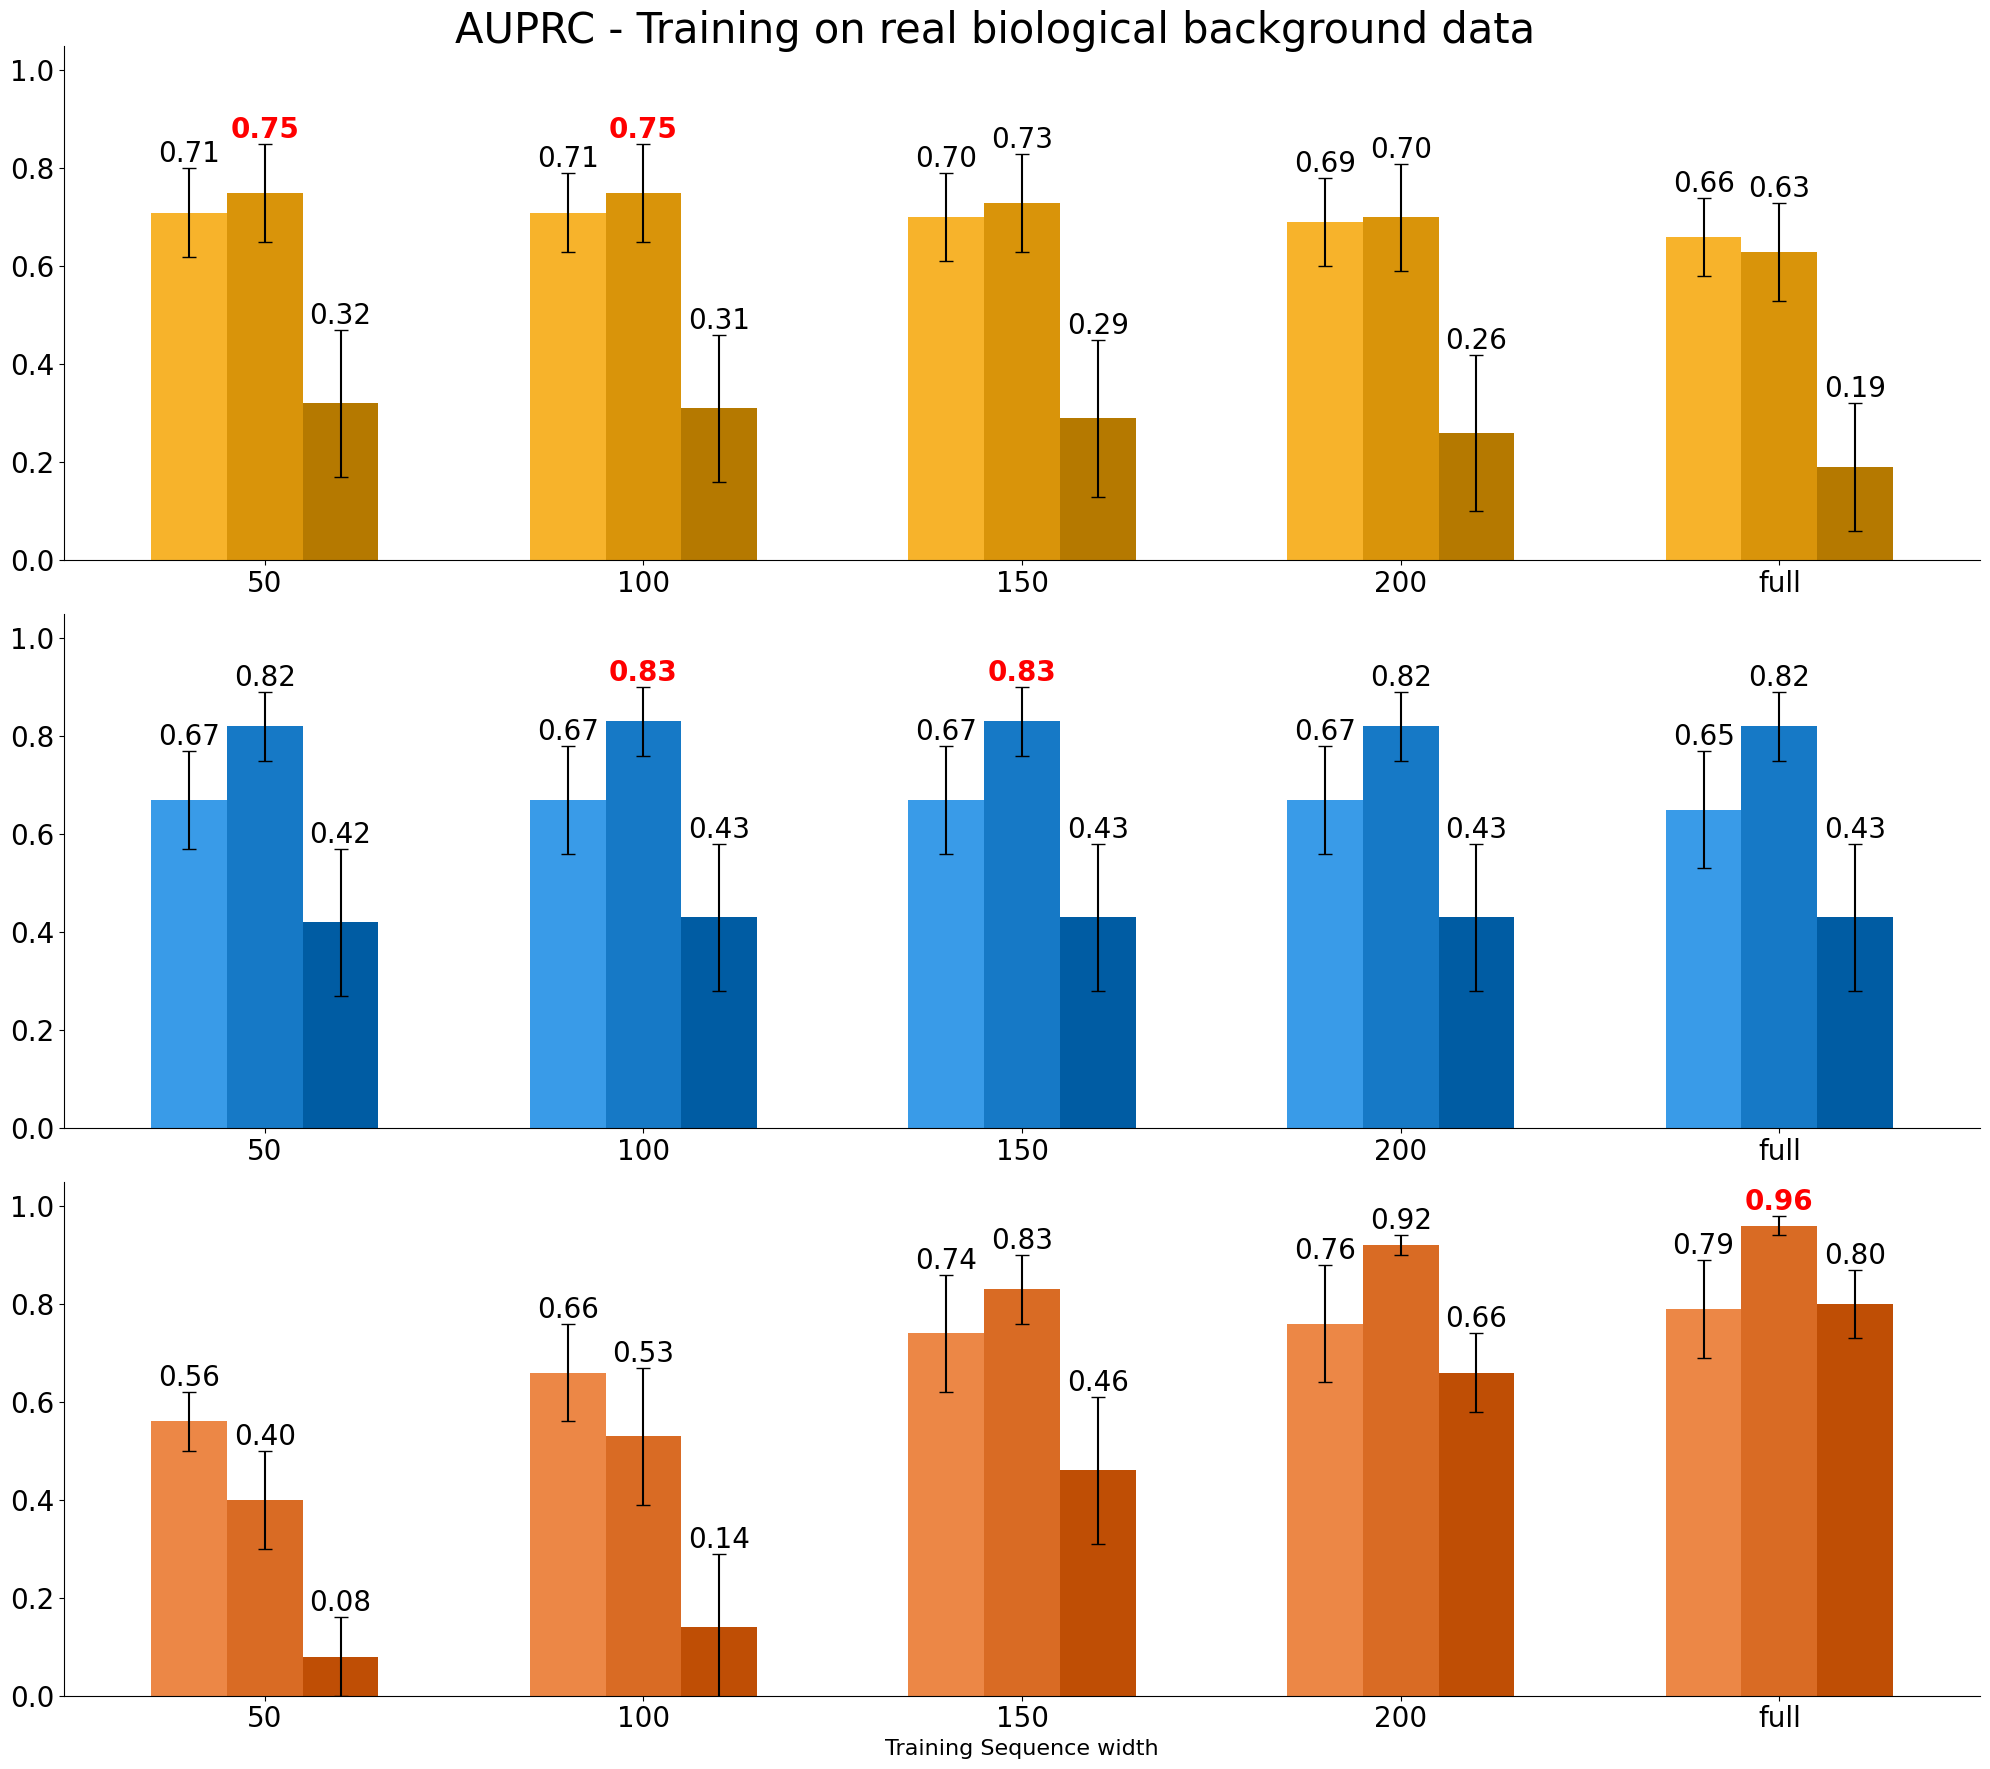

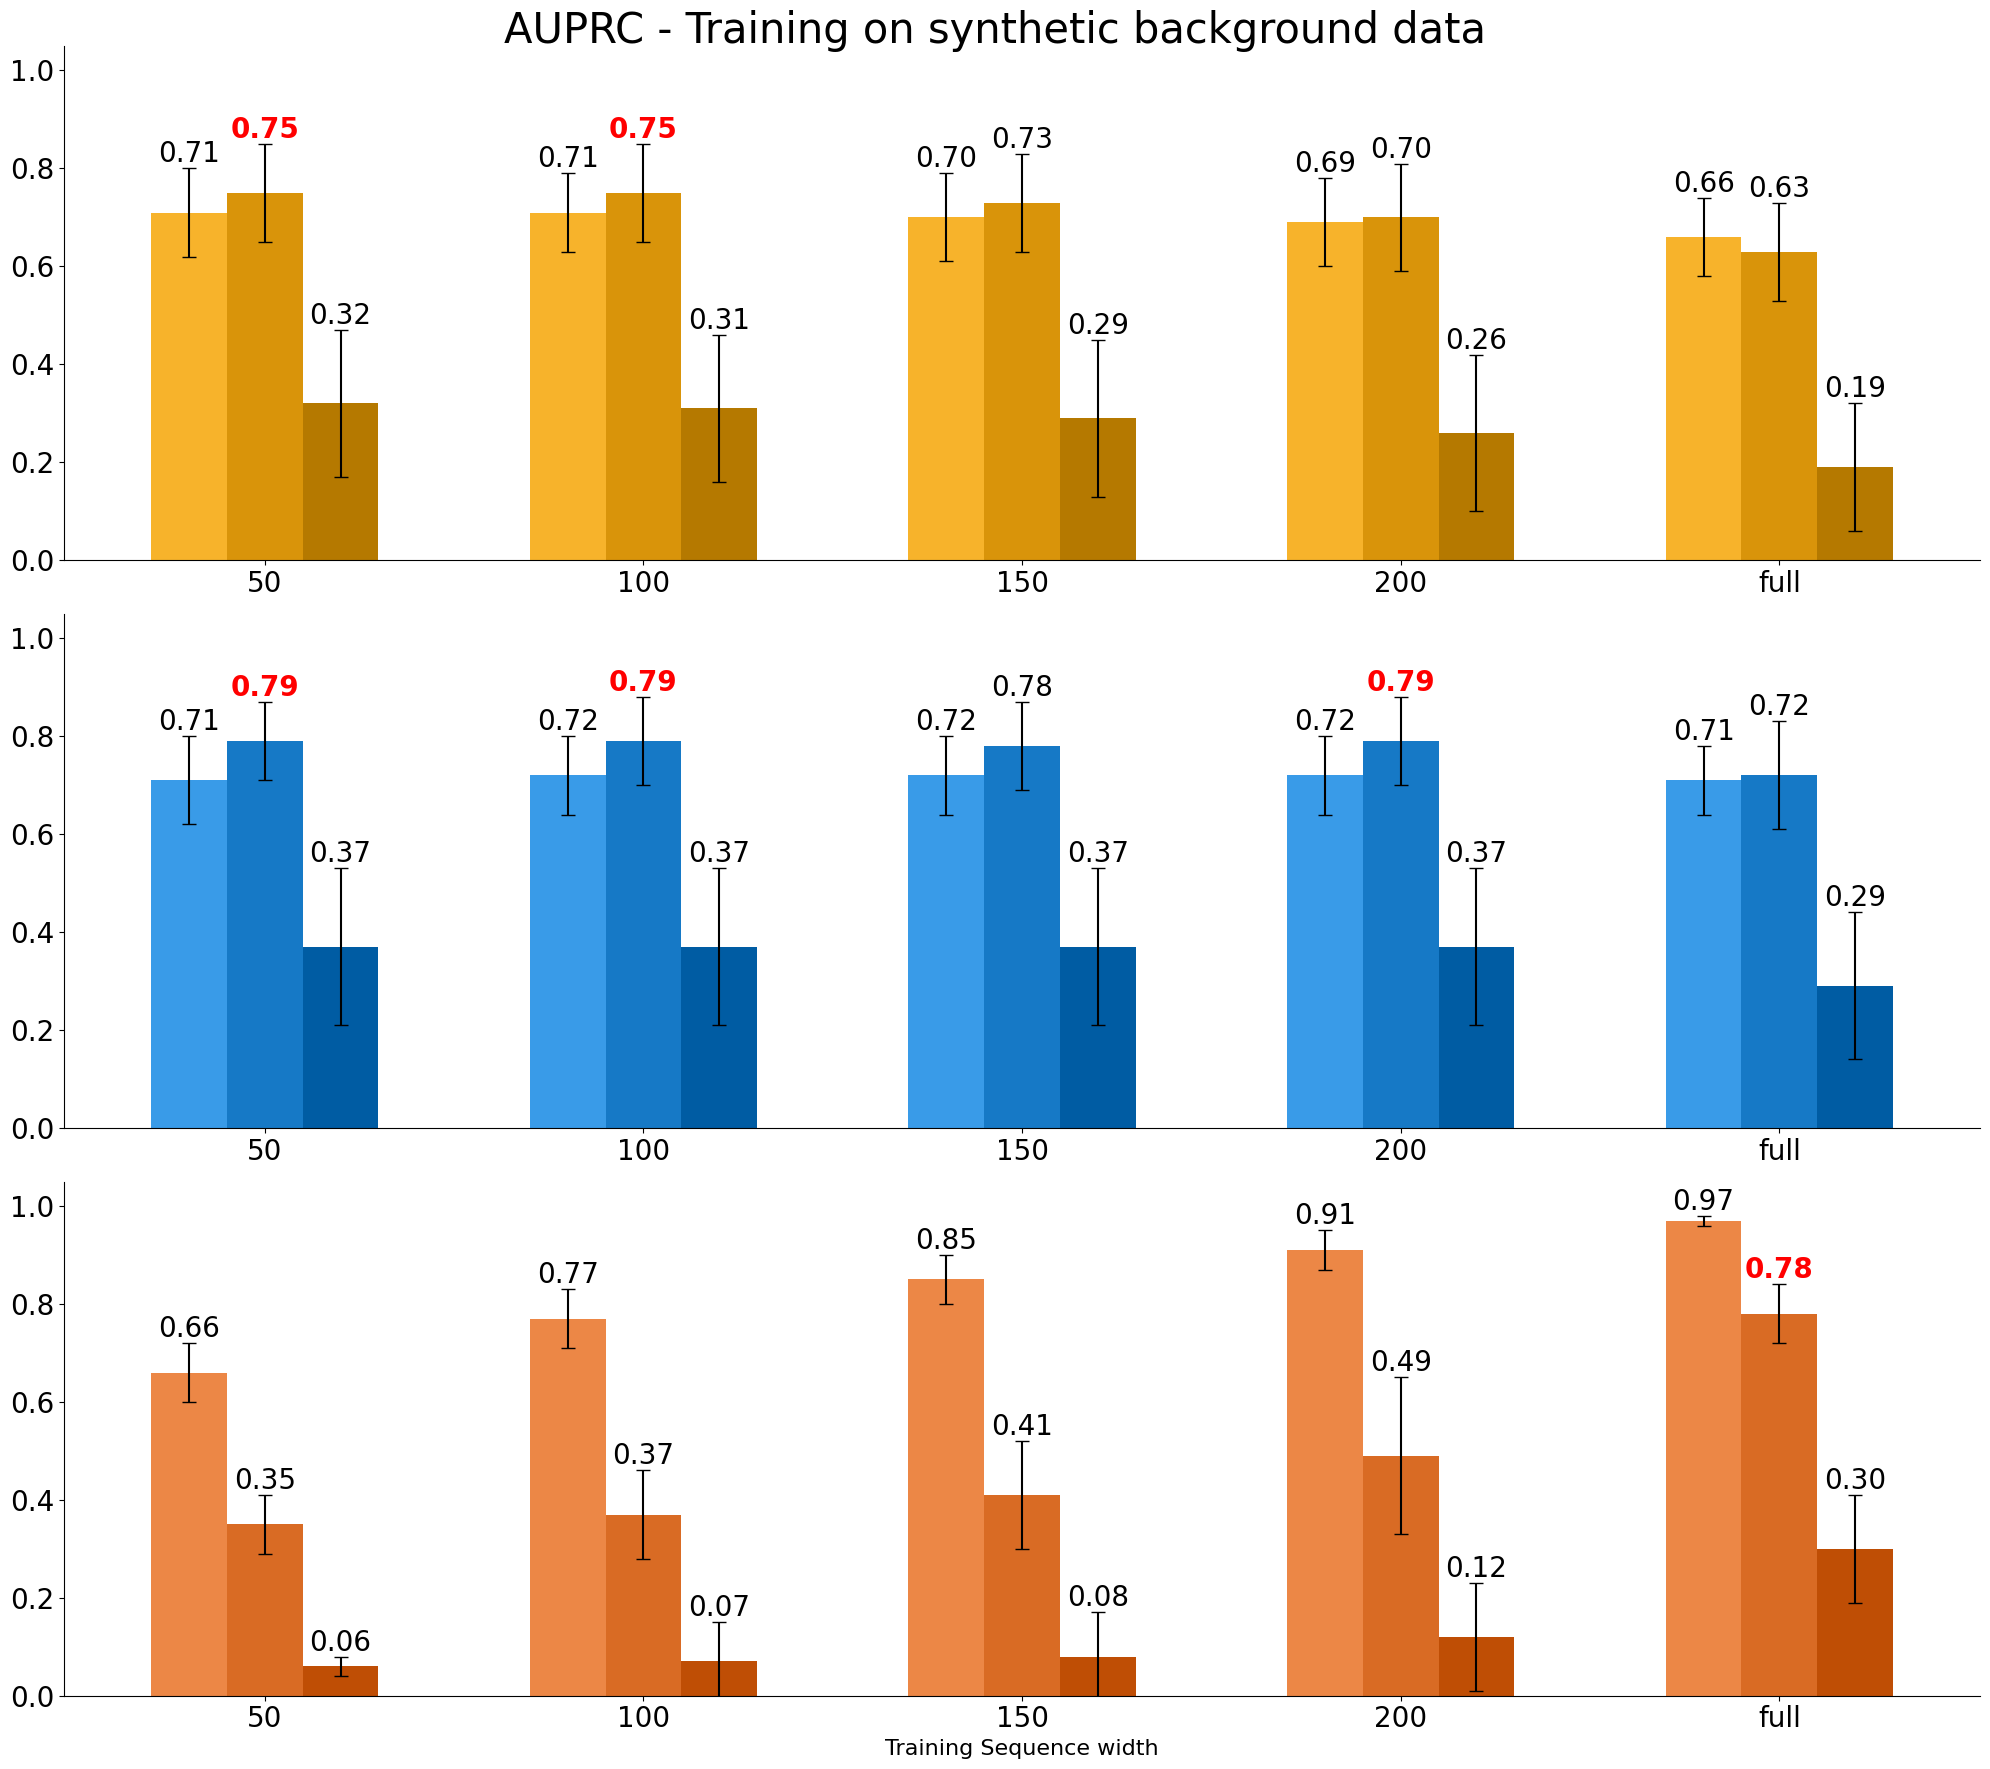

In [11]:
# AUPRC
performance_dir = os.path.join(PERFORMANCEDIR, "sequence-width-comparison")
barplot(performance_dir, "AUPRC")

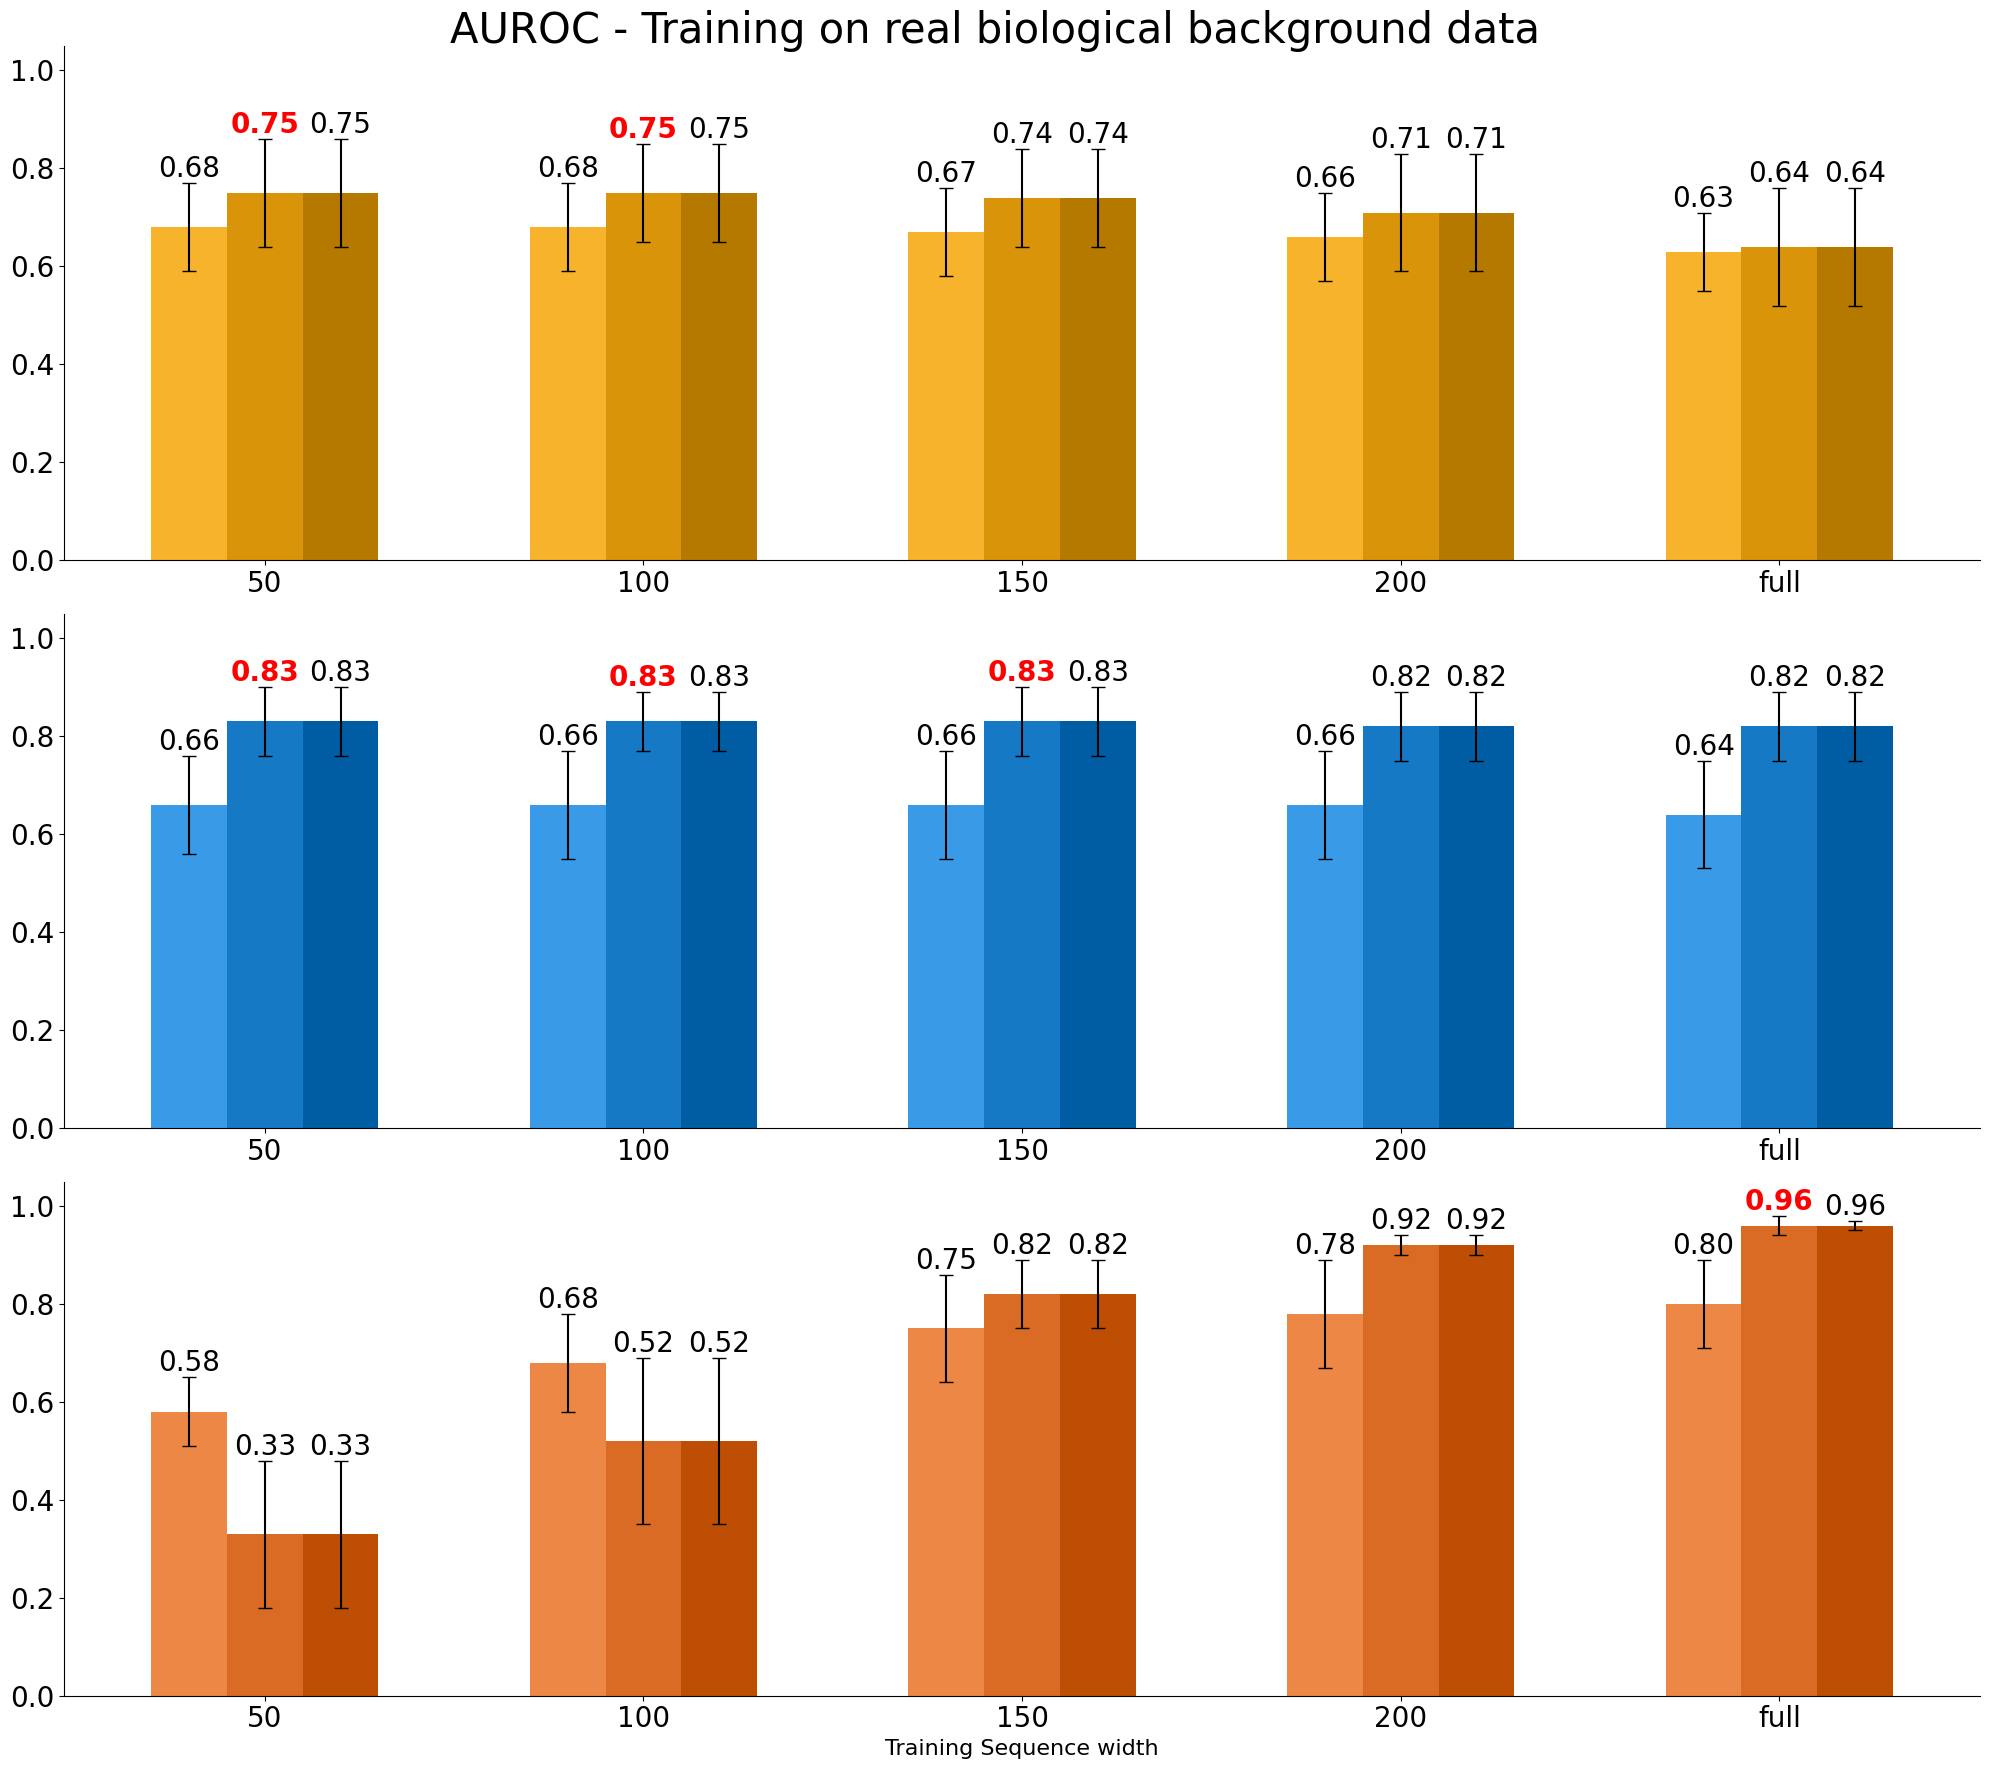

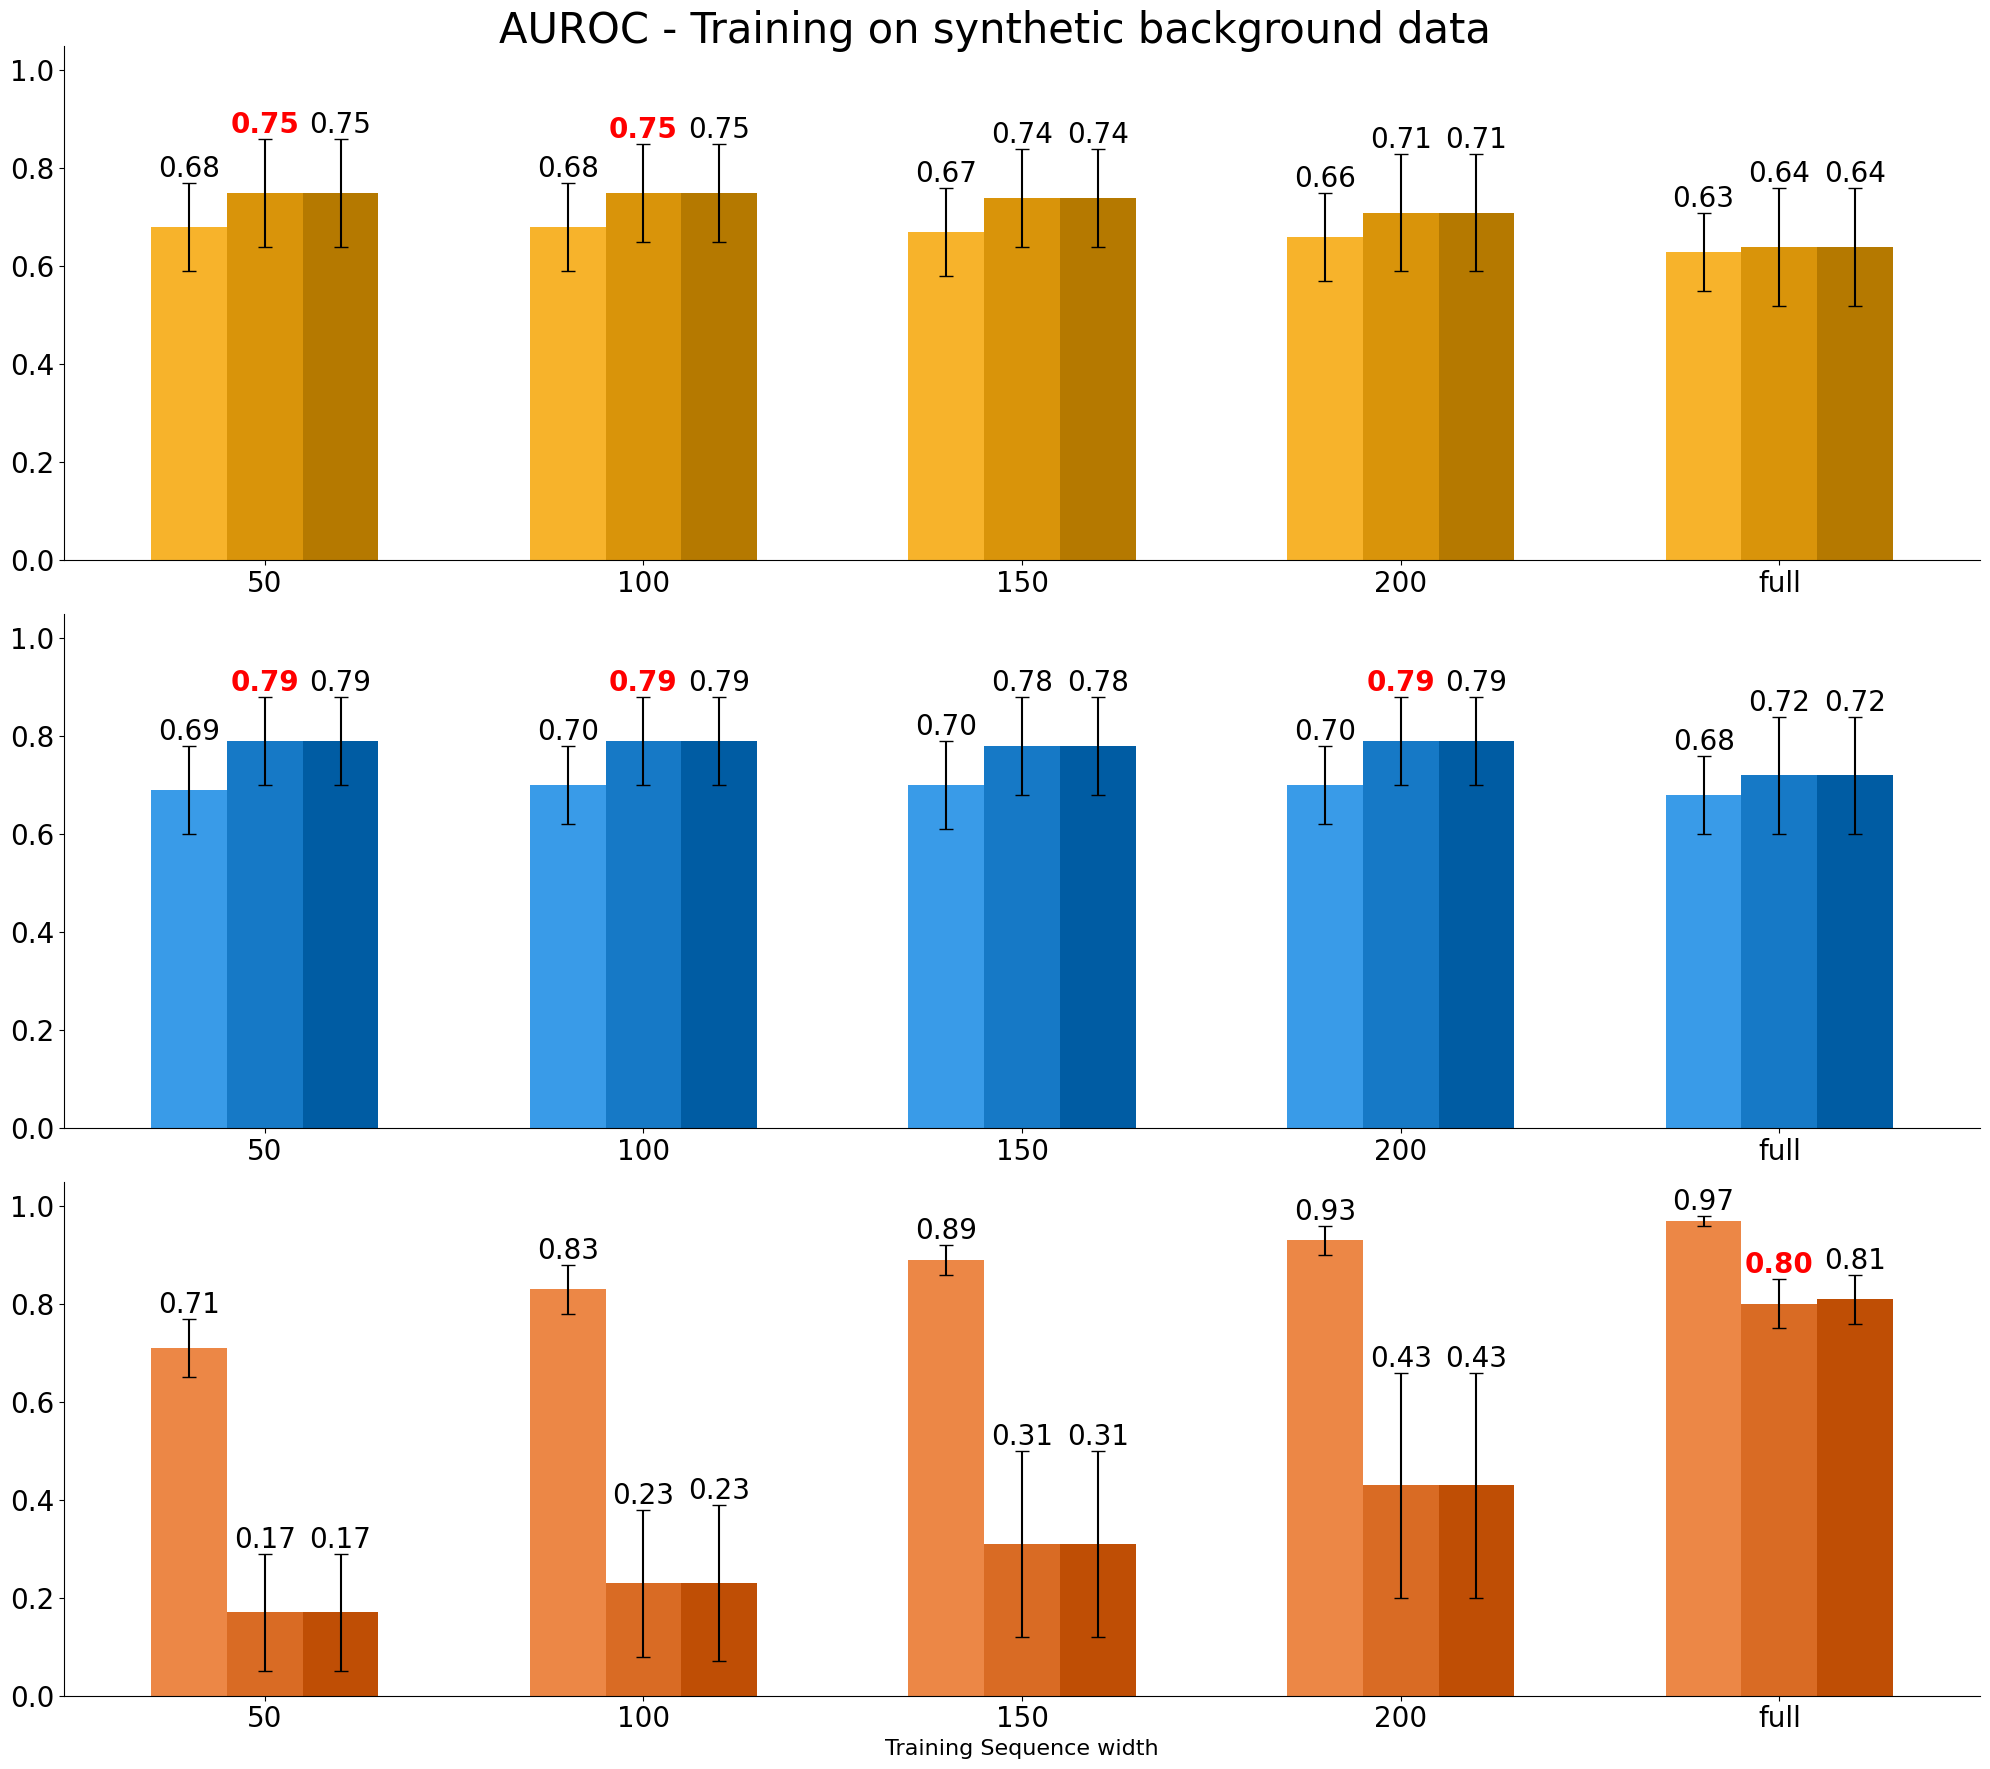

In [12]:
# AUROC
performance_dir = os.path.join(PERFORMANCEDIR, "sequence-width-comparison")
barplot(performance_dir, "AUROC")

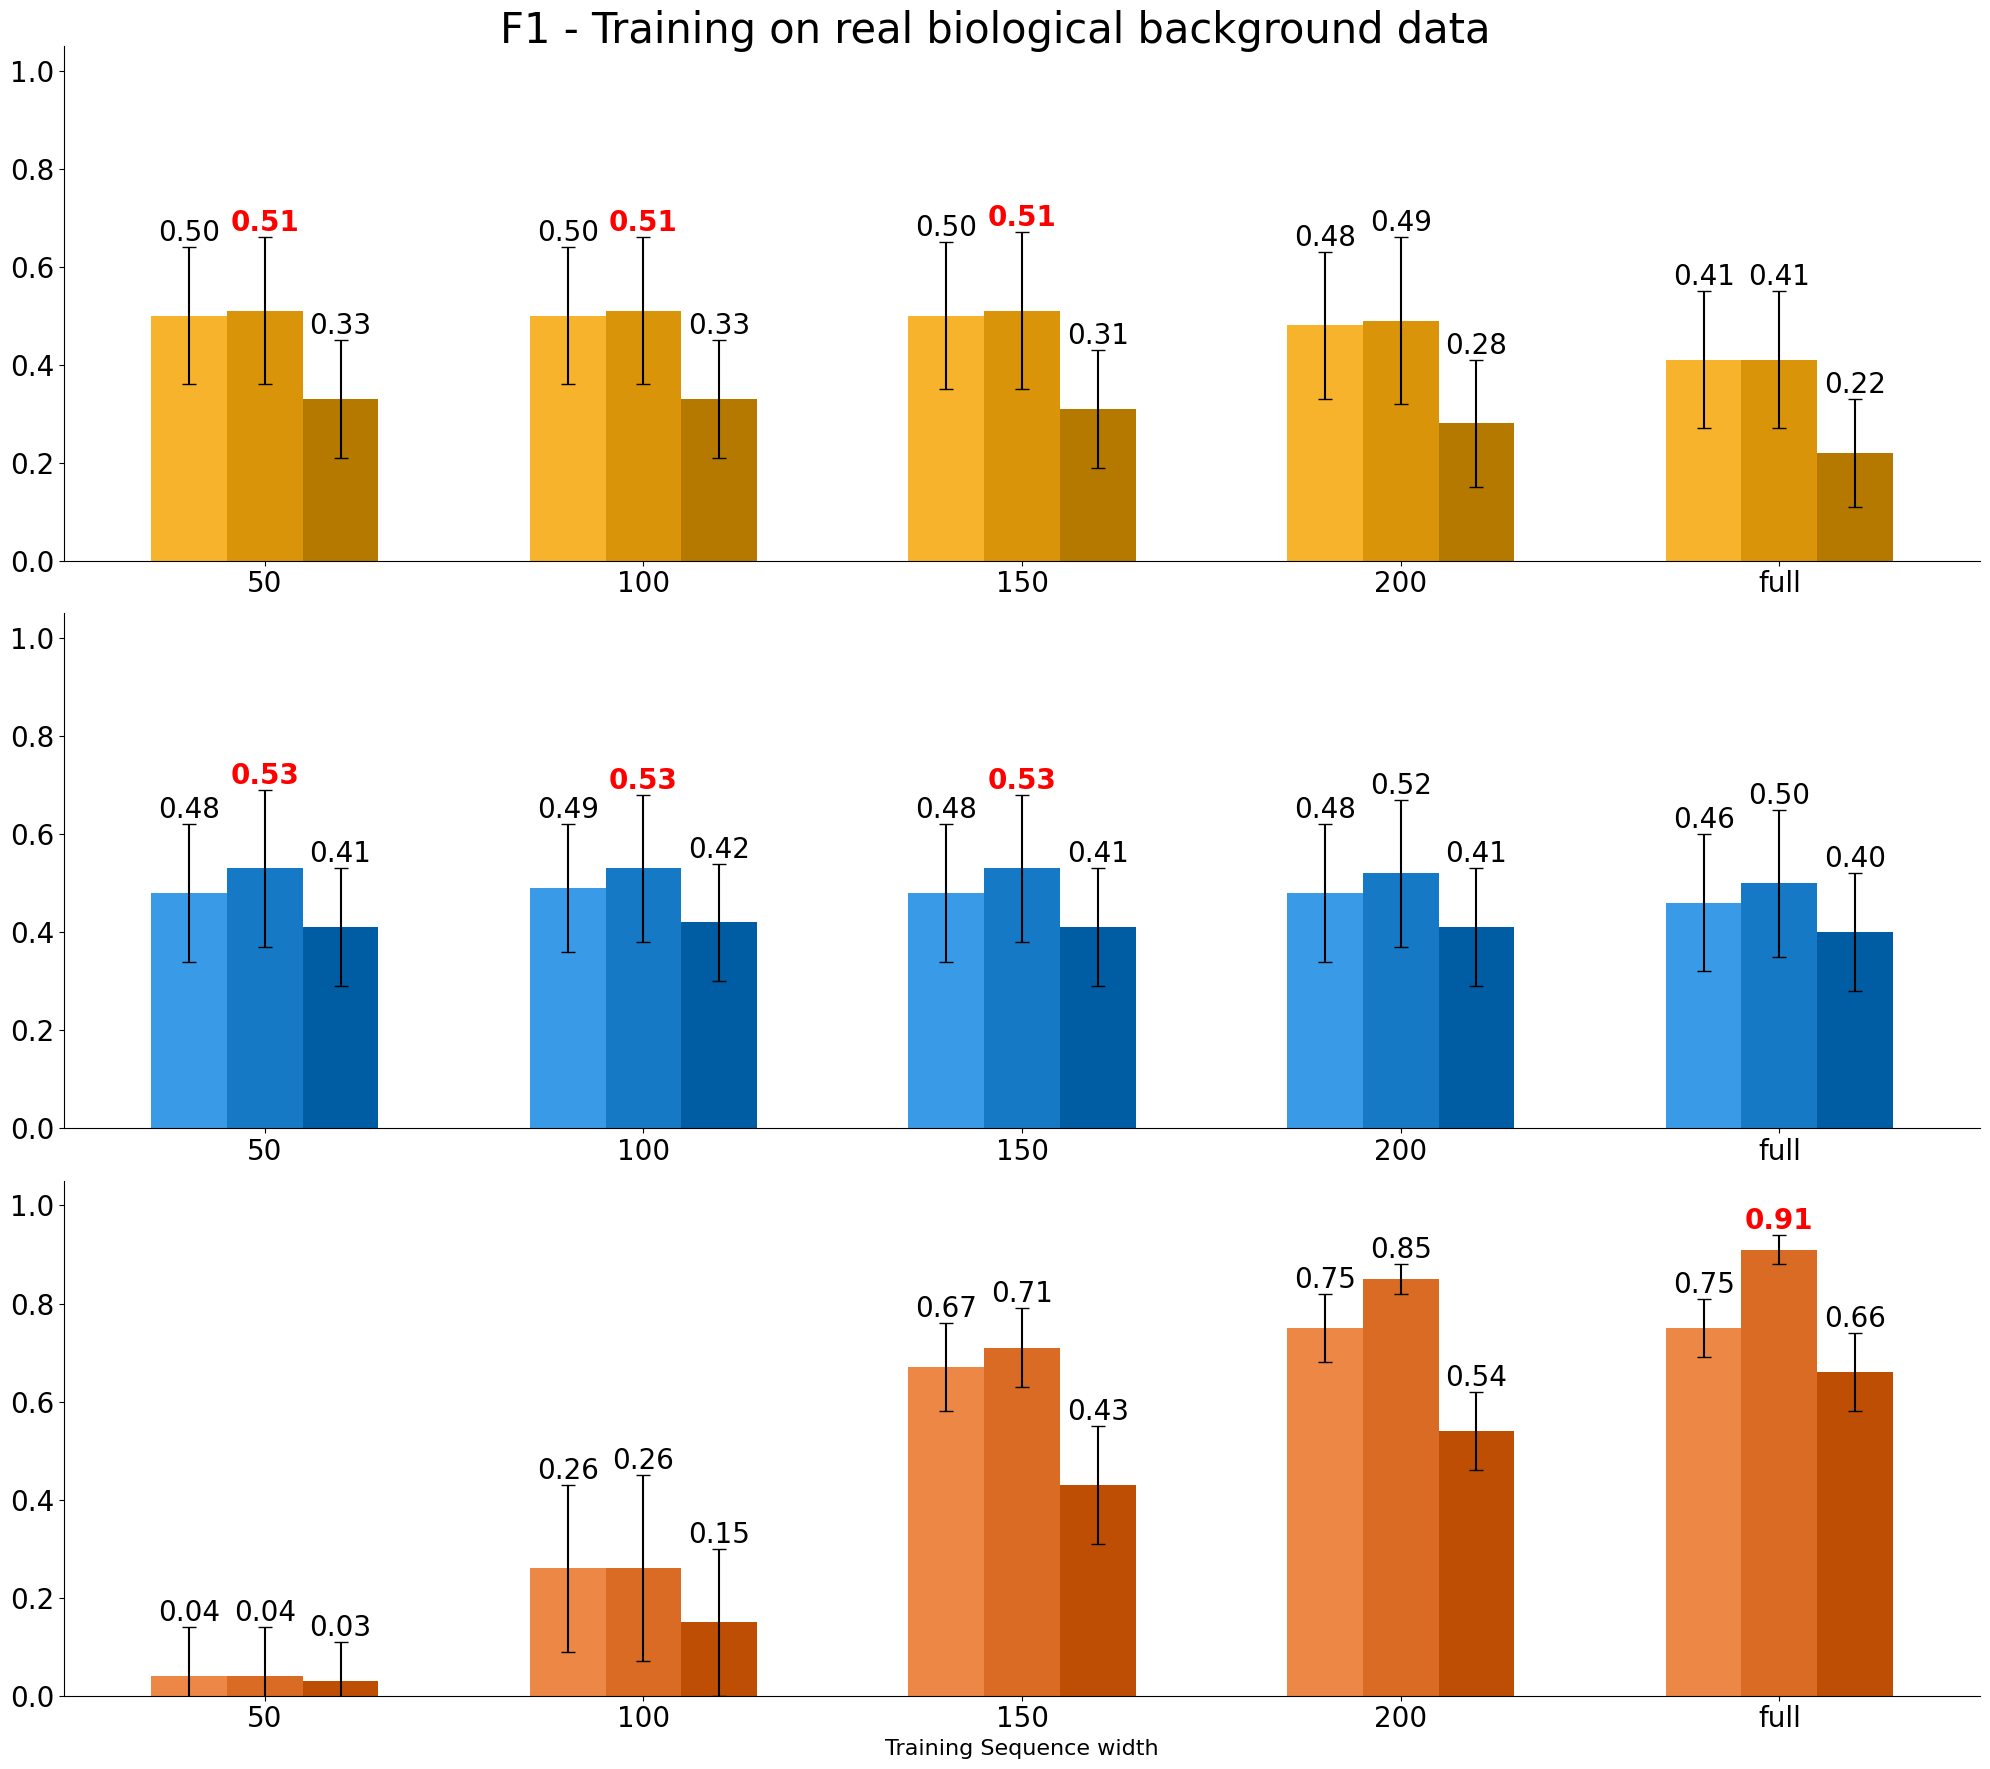

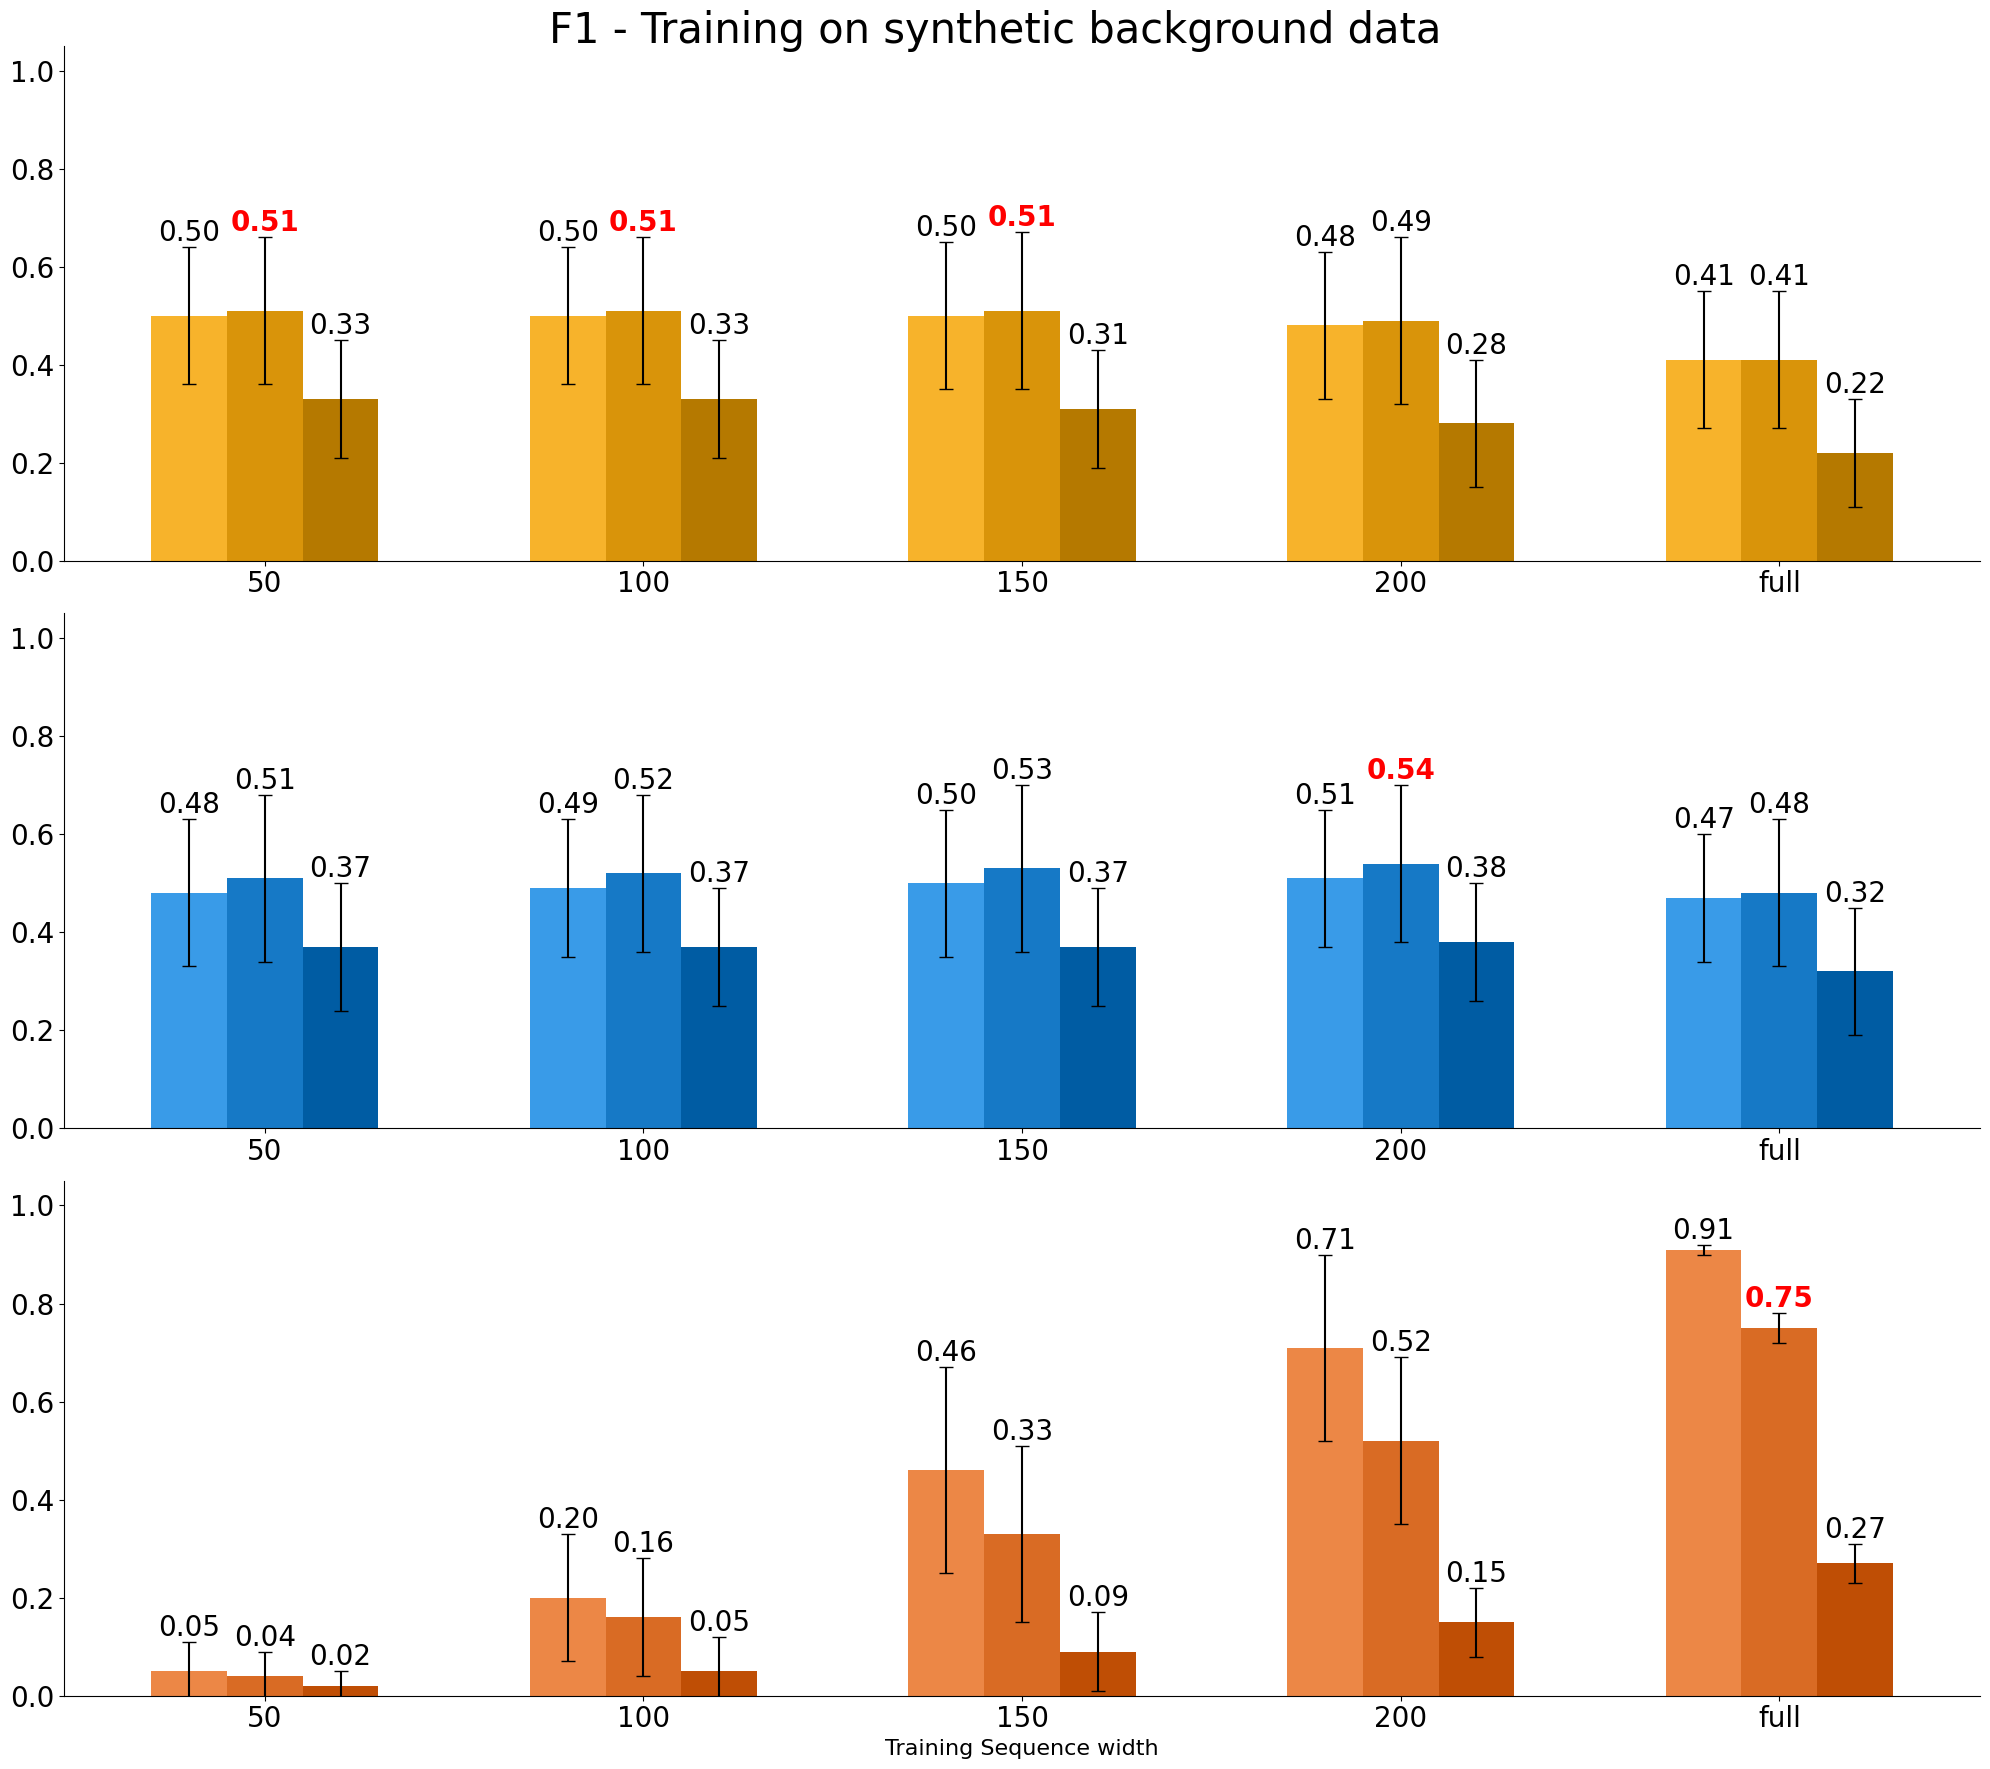

In [13]:
# F1
performance_dir = os.path.join(PERFORMANCEDIR, "sequence-width-comparison")
barplot(performance_dir, "F1")

## Compare performance training models using different numbers of training sequences

In [14]:
def compute_mean_and_std(infolder, size, tool, metric):
    fname = os.path.join(infolder, f"summary_table_size_{size}_{tool}.tsv")
    table = pd.read_csv(fname, sep="\t")
    return np.mean(table[metric]).round(2), np.std(table[metric]).round(2)
    
 
def plot_subplot(ax, data, errors, labels, group_labels, metric, bg, tool):
    num_groups = len(group_labels)
    num_bars = len(data)
    x = np.arange(num_groups) / 2  # The label locations
    width = 0.1  # The width of the bars
    colors = COLORS[tool]
 
    # Best value for "dnase-1"
    dnase_1_index = BGTEST.index("dnase-1") if "dnase-1" in BGTEST else None
    max_dnase_1_value = max(data[dnase_1_index]) if dnase_1_index is not None else None
    for i, (values, errs, label) in enumerate(zip(data, errors, labels)):
        bars = ax.bar(x + i * width, values, width, label=label, color=colors[i], yerr=errs, capsize=5)
 
        # Text labels
        for j, (bar, value, err) in enumerate(zip(bars, values, errs)):
            text_color = "red" if (dnase_1_index is not None and i == dnase_1_index and value == max_dnase_1_value) else "black"
            ax.text(bar.get_x() + bar.get_width() / 2, value + err, f'{value:.2f}',
                    ha='center', va='bottom', fontsize=15, color=text_color,
                    fontweight='bold' if text_color == "red" else "normal")
 
    ax.set_xlabel("Training Dataset size" if TOOLS.index(tool) == len(TOOLS)-1 else None, size=16)
    #ax.set_ylabel(metric, size=20)
    # ax.set_title(f"{tool} - Training on {bg}", size=18)
    ax.set_xticks(x + width * (num_bars / 2 - 0.5))
    ax.set_xticklabels(group_labels, size=20)
    ax.set_ylim(0, 1.05)
    ax.tick_params(axis='y', labelsize=20)
    #ax.legend(fontsize=20)
    ax.spines[['right', 'top']].set_visible(False)


def barplot(infolder, metric, outfolder):
    sizes = [500, 1000, 2000, 5000, 10000, "full"]
    # tools = ["MEME (PWM)", "STREME (PWM)", "LS-GKM (SVM)"]
    training_backgrounds = ["dnase", "shuffle"]

    for bg in training_backgrounds:
        fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 18))  # 3 rows, 1 column

        for idx, tool in enumerate(TOOLS):
            data = [[] for _ in range(3)]
            errors = [[] for _ in range(3)]

            for size in sizes:
                for i, (trainbg, testbg) in enumerate([(bg, bt) for bt in BGTEST]):
                    tablesdir = os.path.join(infolder, f"{trainbg}-{testbg}")
                    mean, std = compute_mean_and_std(tablesdir, size, tool, metric)
                    data[i].append(mean)
                    errors[i].append(std)

            labels = [f"{tool} - test background: {testbg}" for testbg in BGTEST]
            bgtitle = "real biological background data" if bg == "dnase" else "synthetic background data"

            plot_subplot(axes[idx], data, errors, labels, sizes, metric, bgtitle, tool)

        fig.suptitle(f"{metric} - Training on {bgtitle}", fontsize=30)
        plt.tight_layout() 
        #plt.savefig(f"{outfolder}/{metric}_Training_on_{bgtitle}.svg", format='svg', dpi=300)
    
        plt.show()

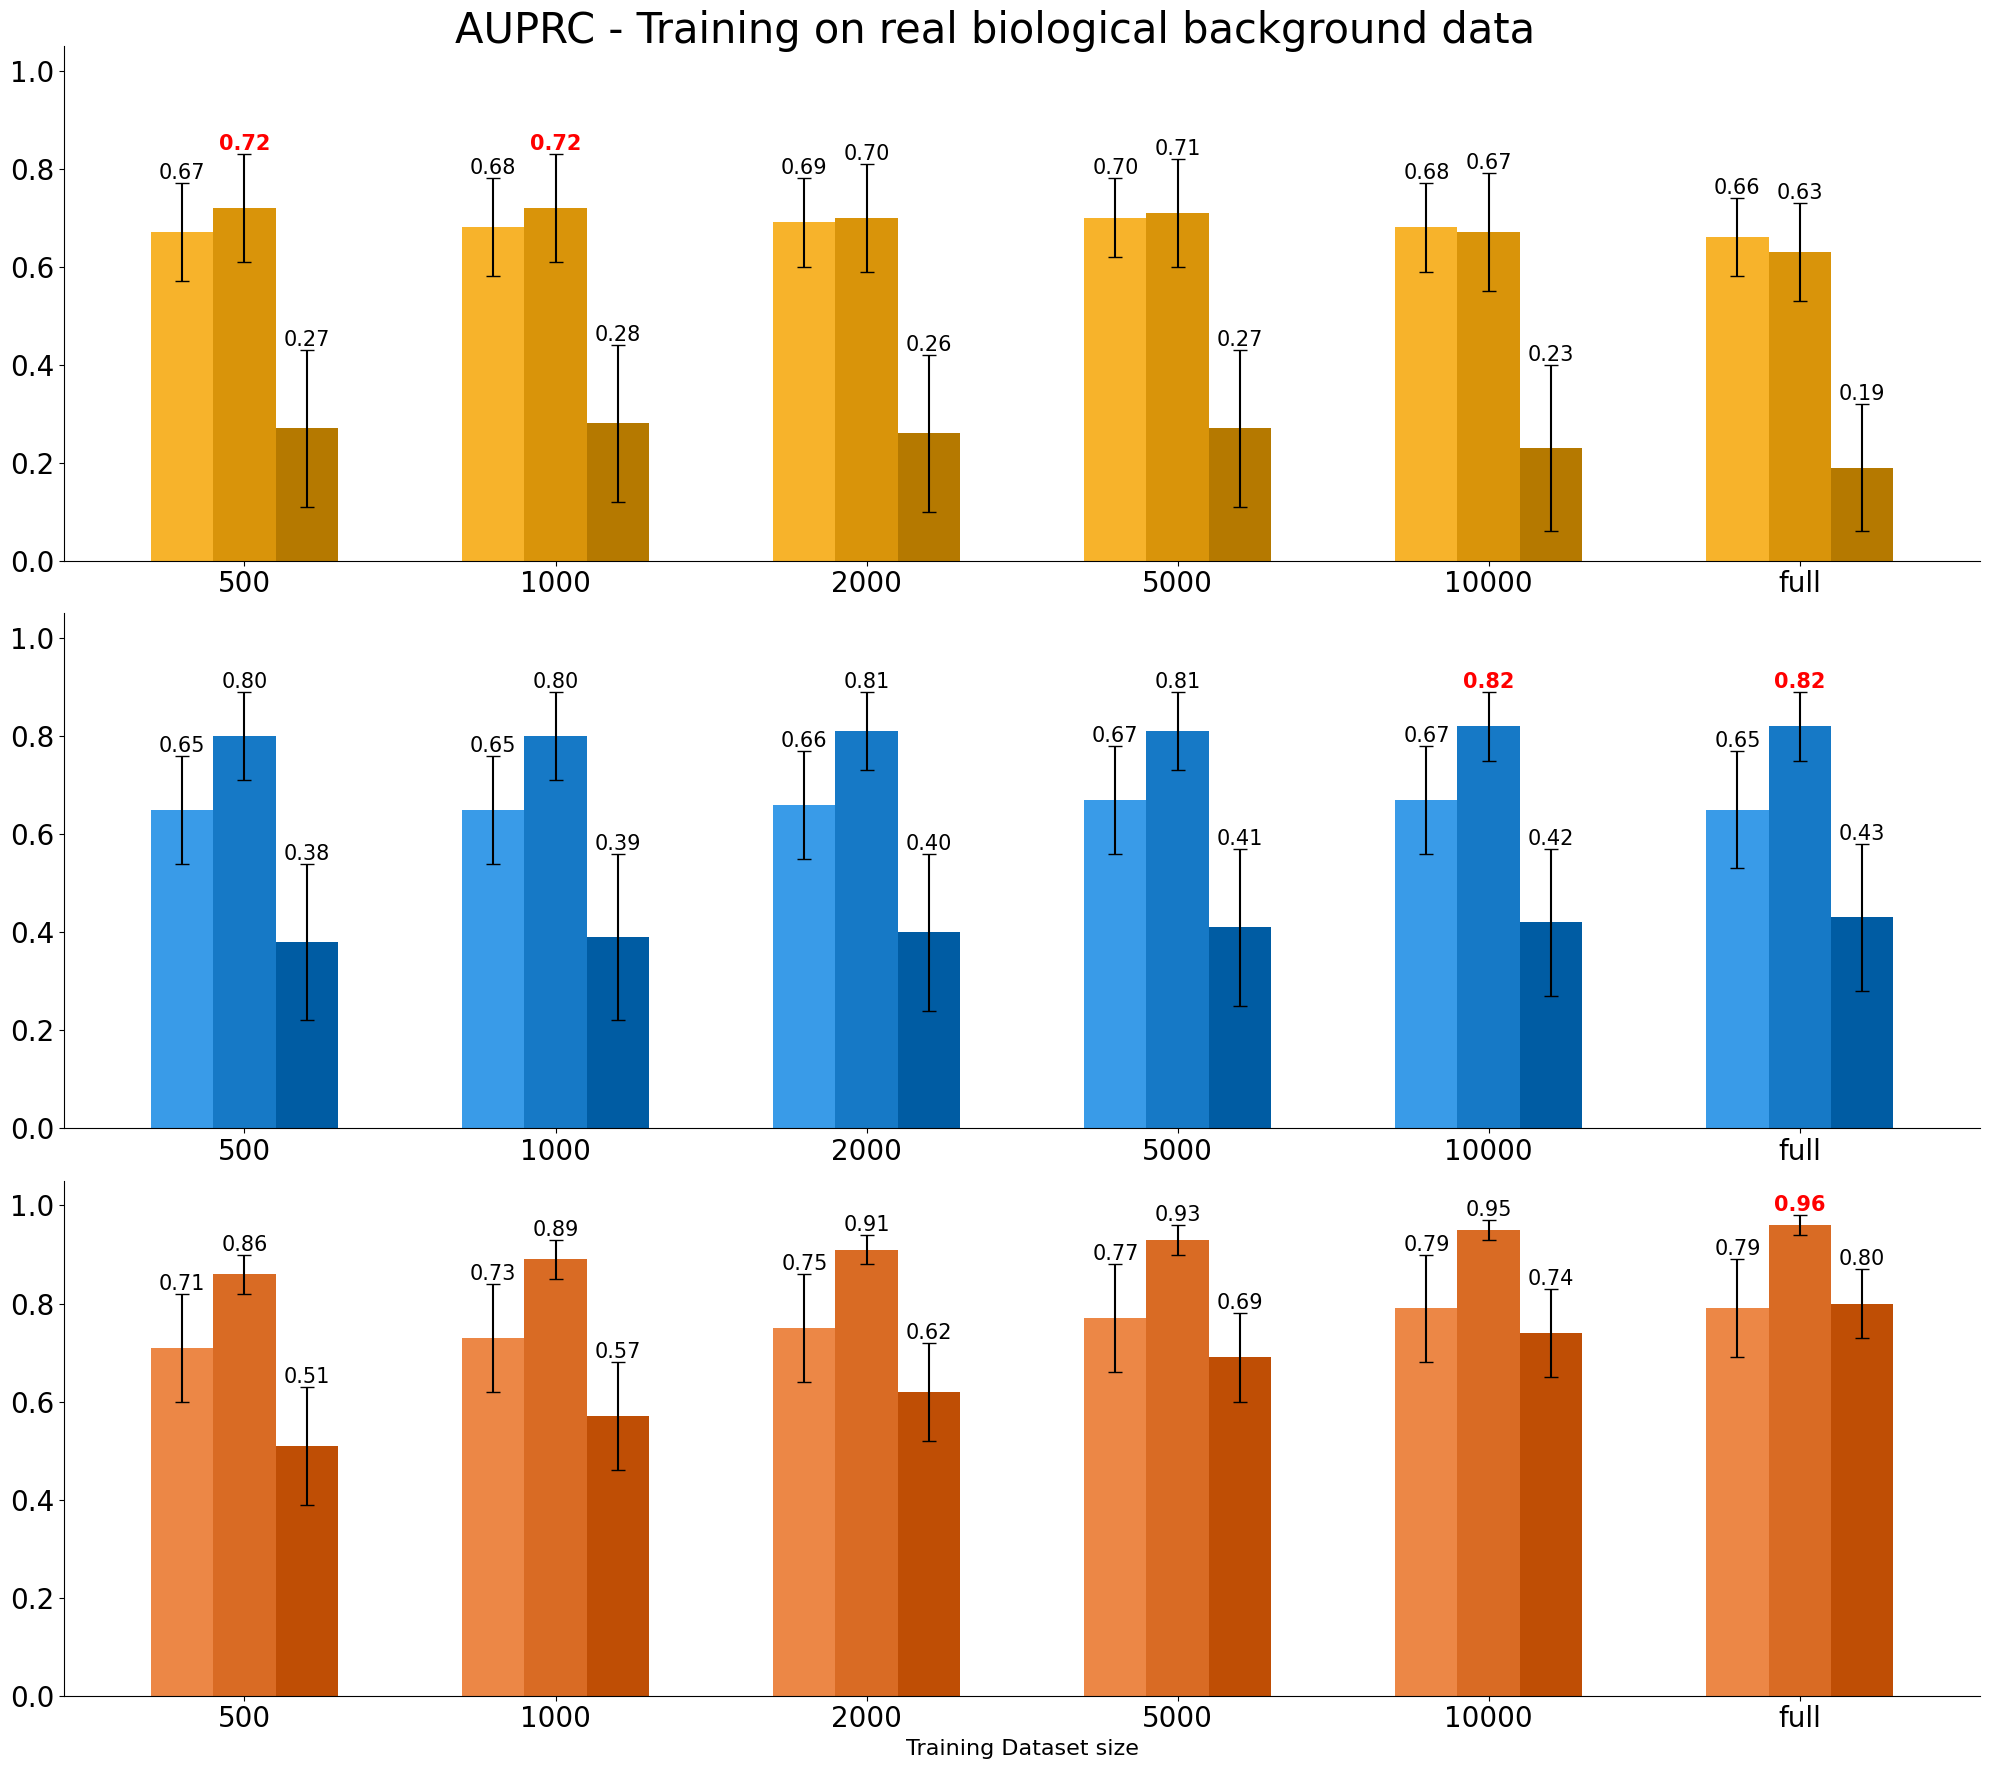

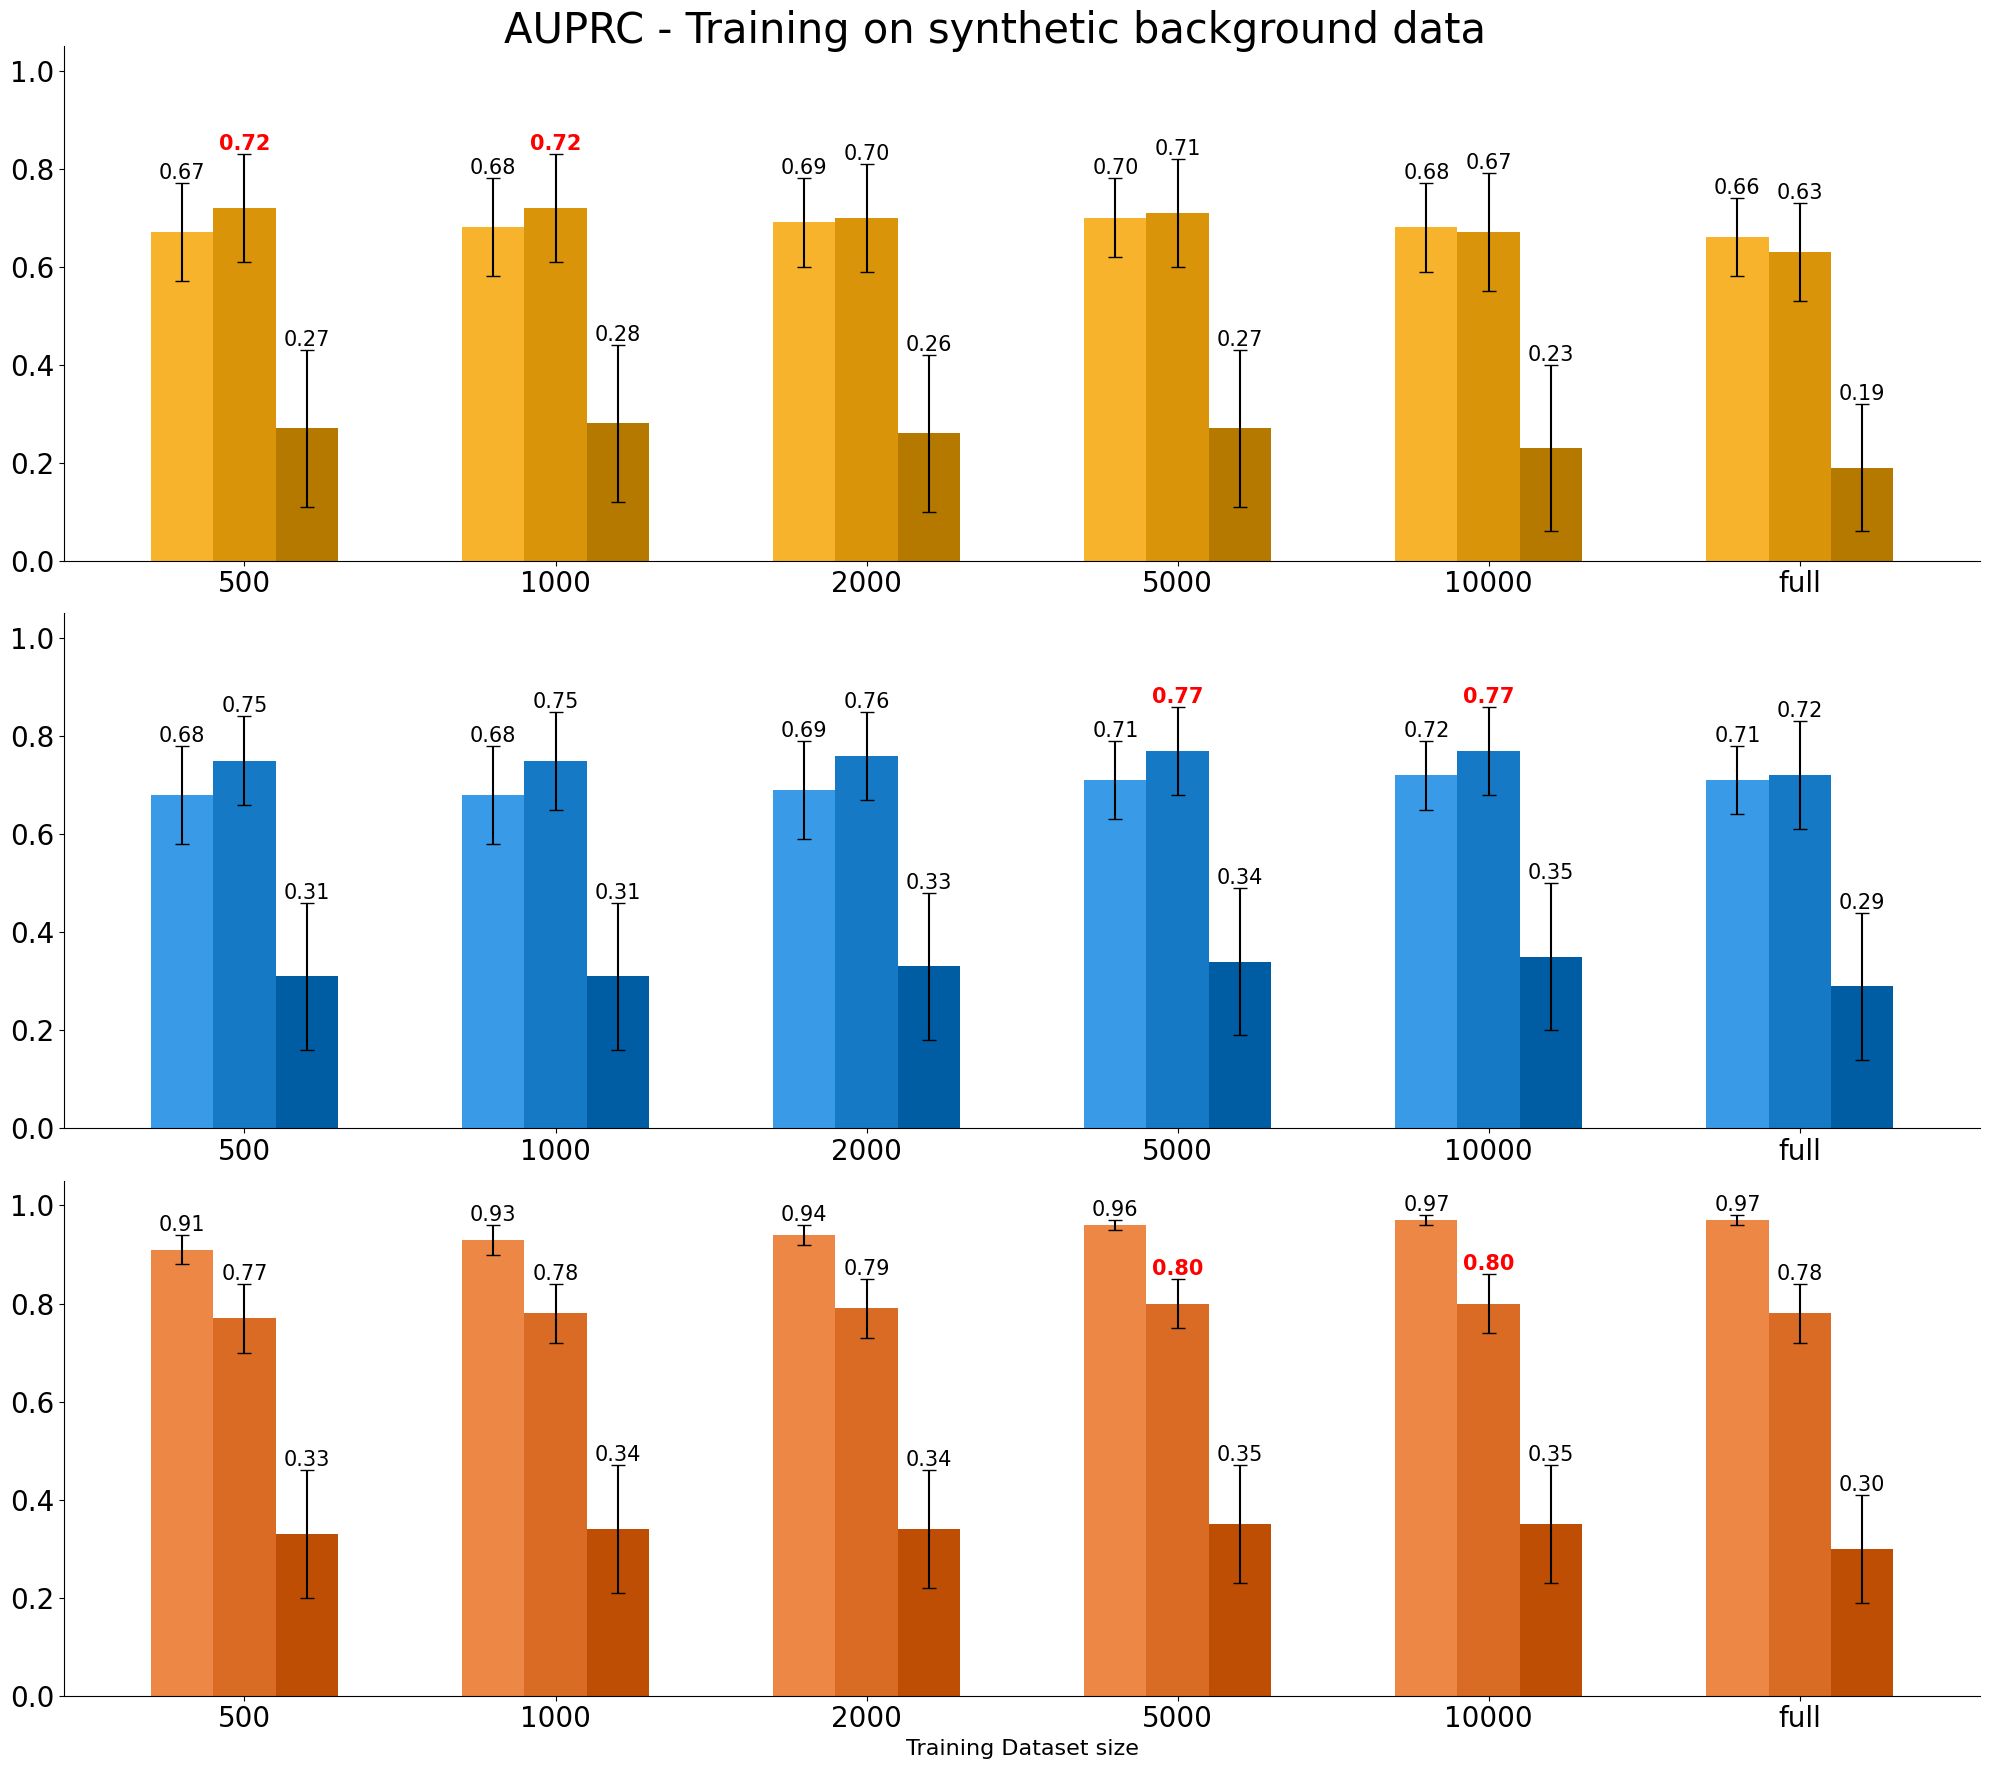

In [ ]:
# AUPRC
OUTDIR = "path/to/outdir"
performance_dir = os.path.join(PERFORMANCEDIR, "dataset-size-comparison")
barplot(performance_dir, "AUPRC", OUTDIR)

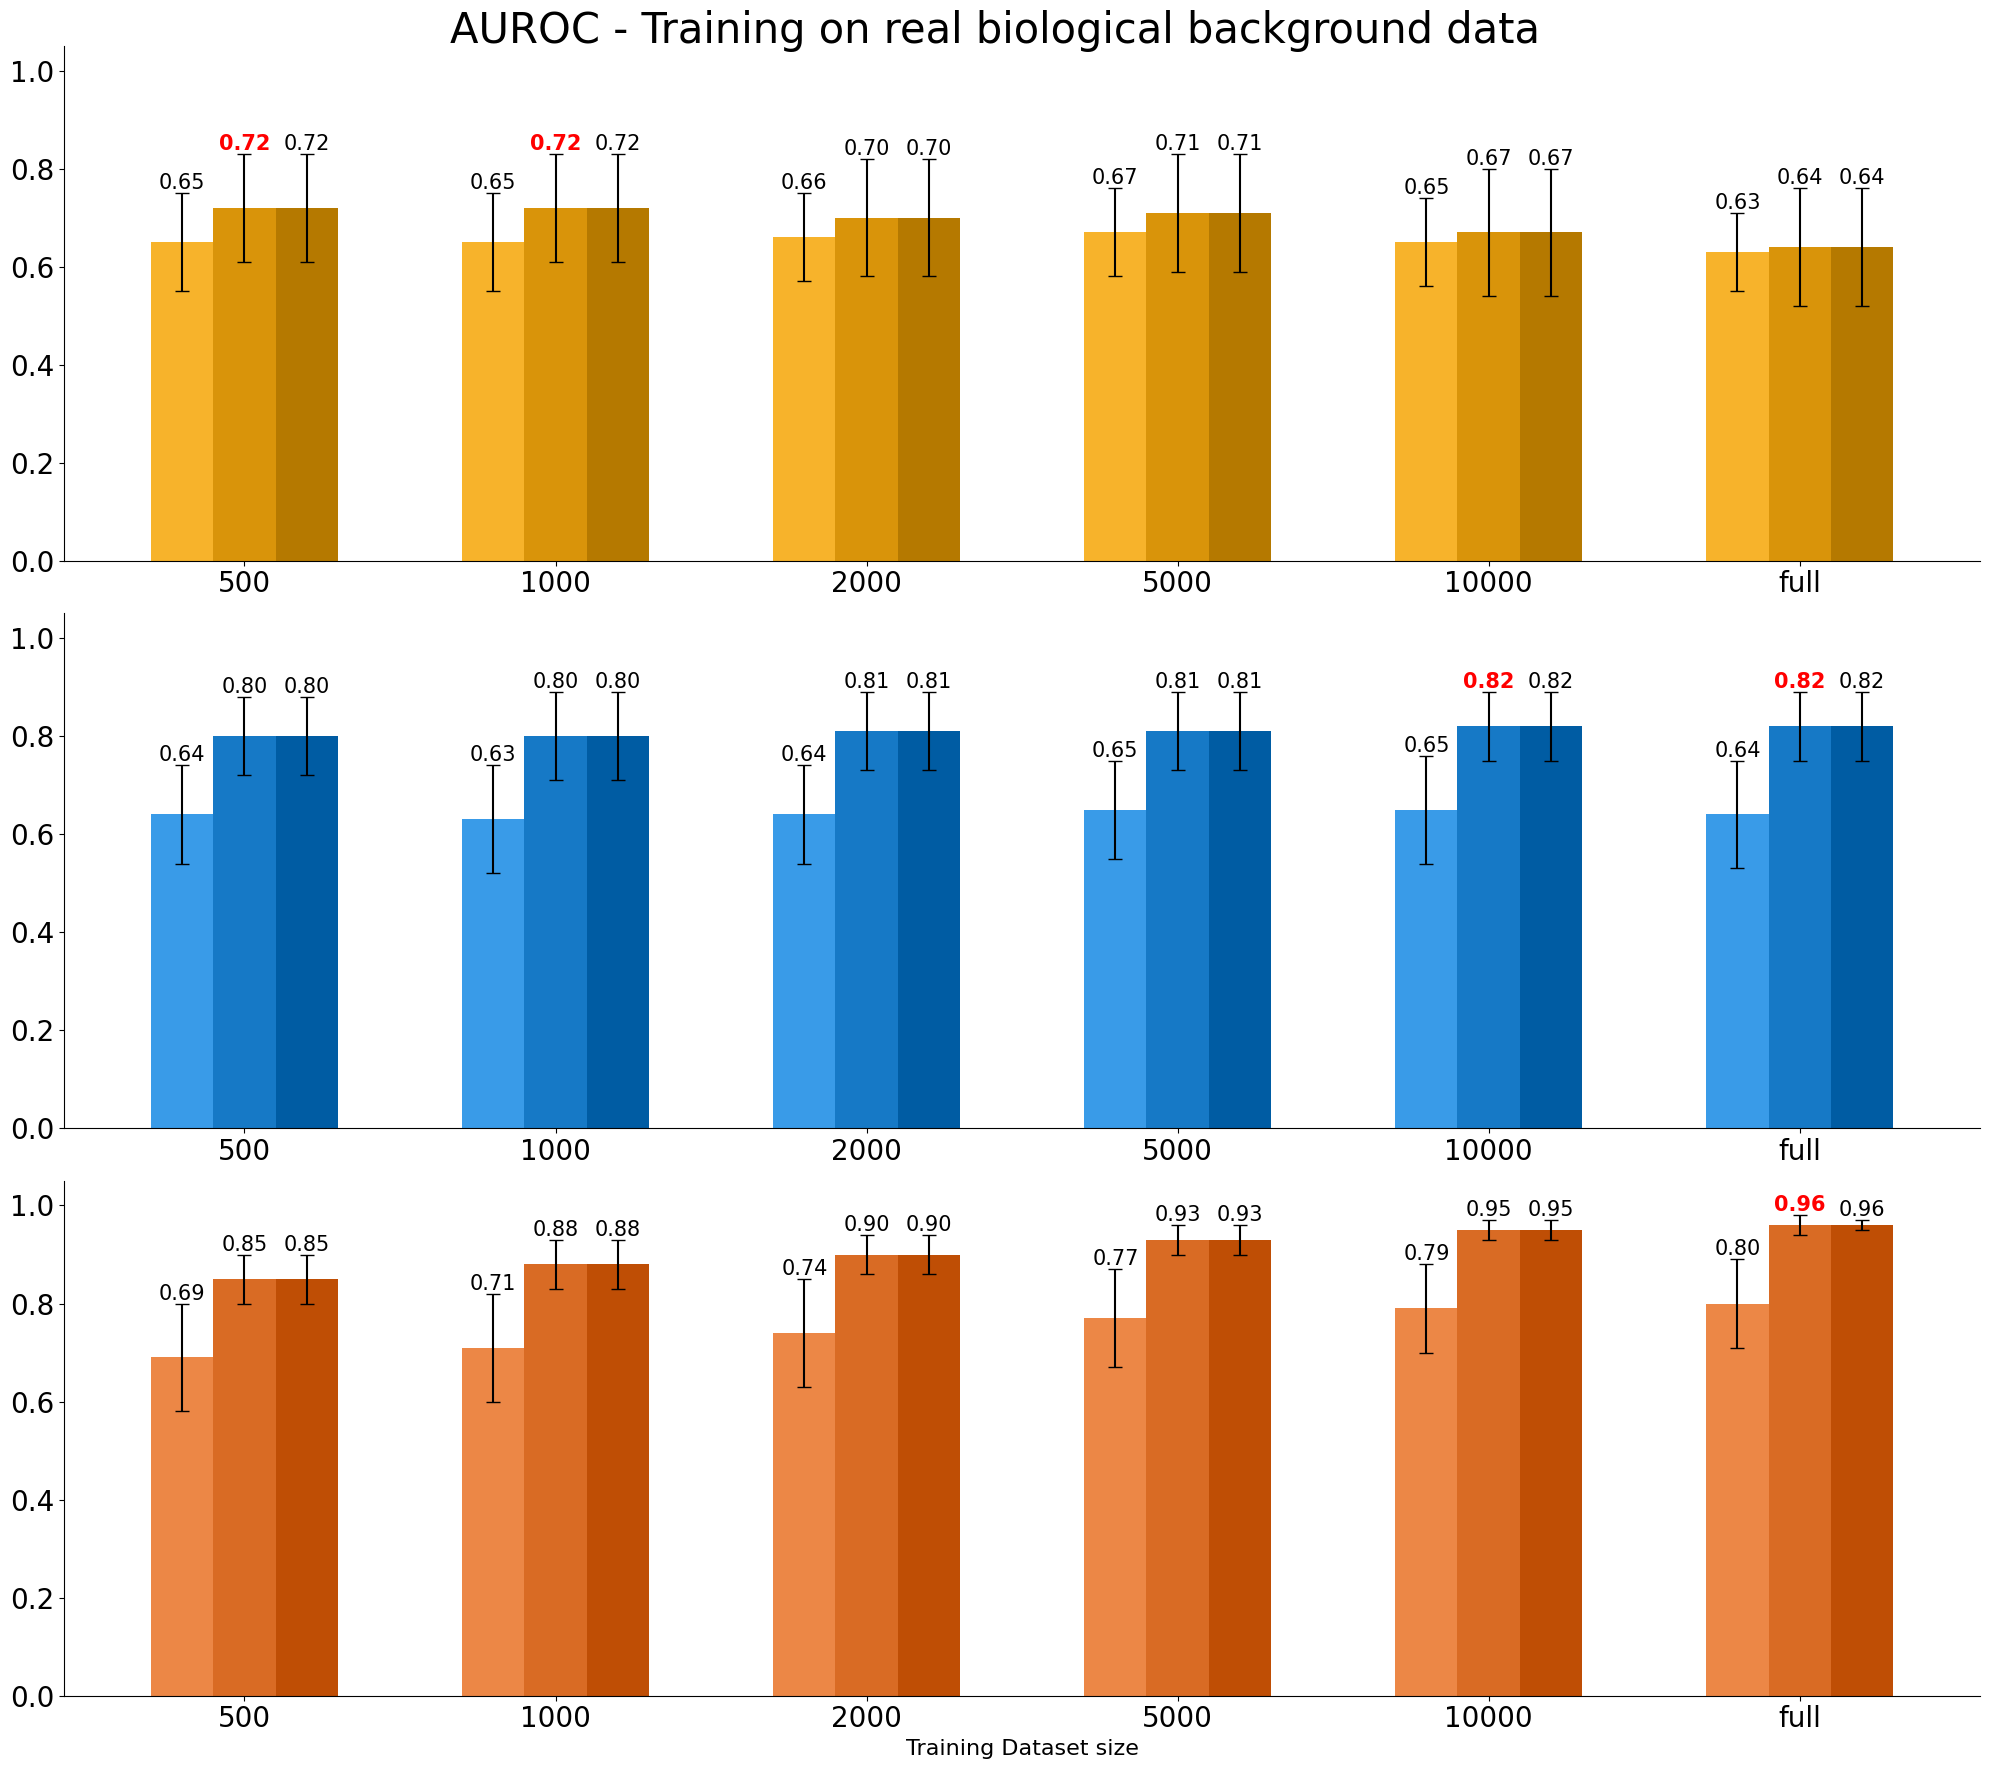

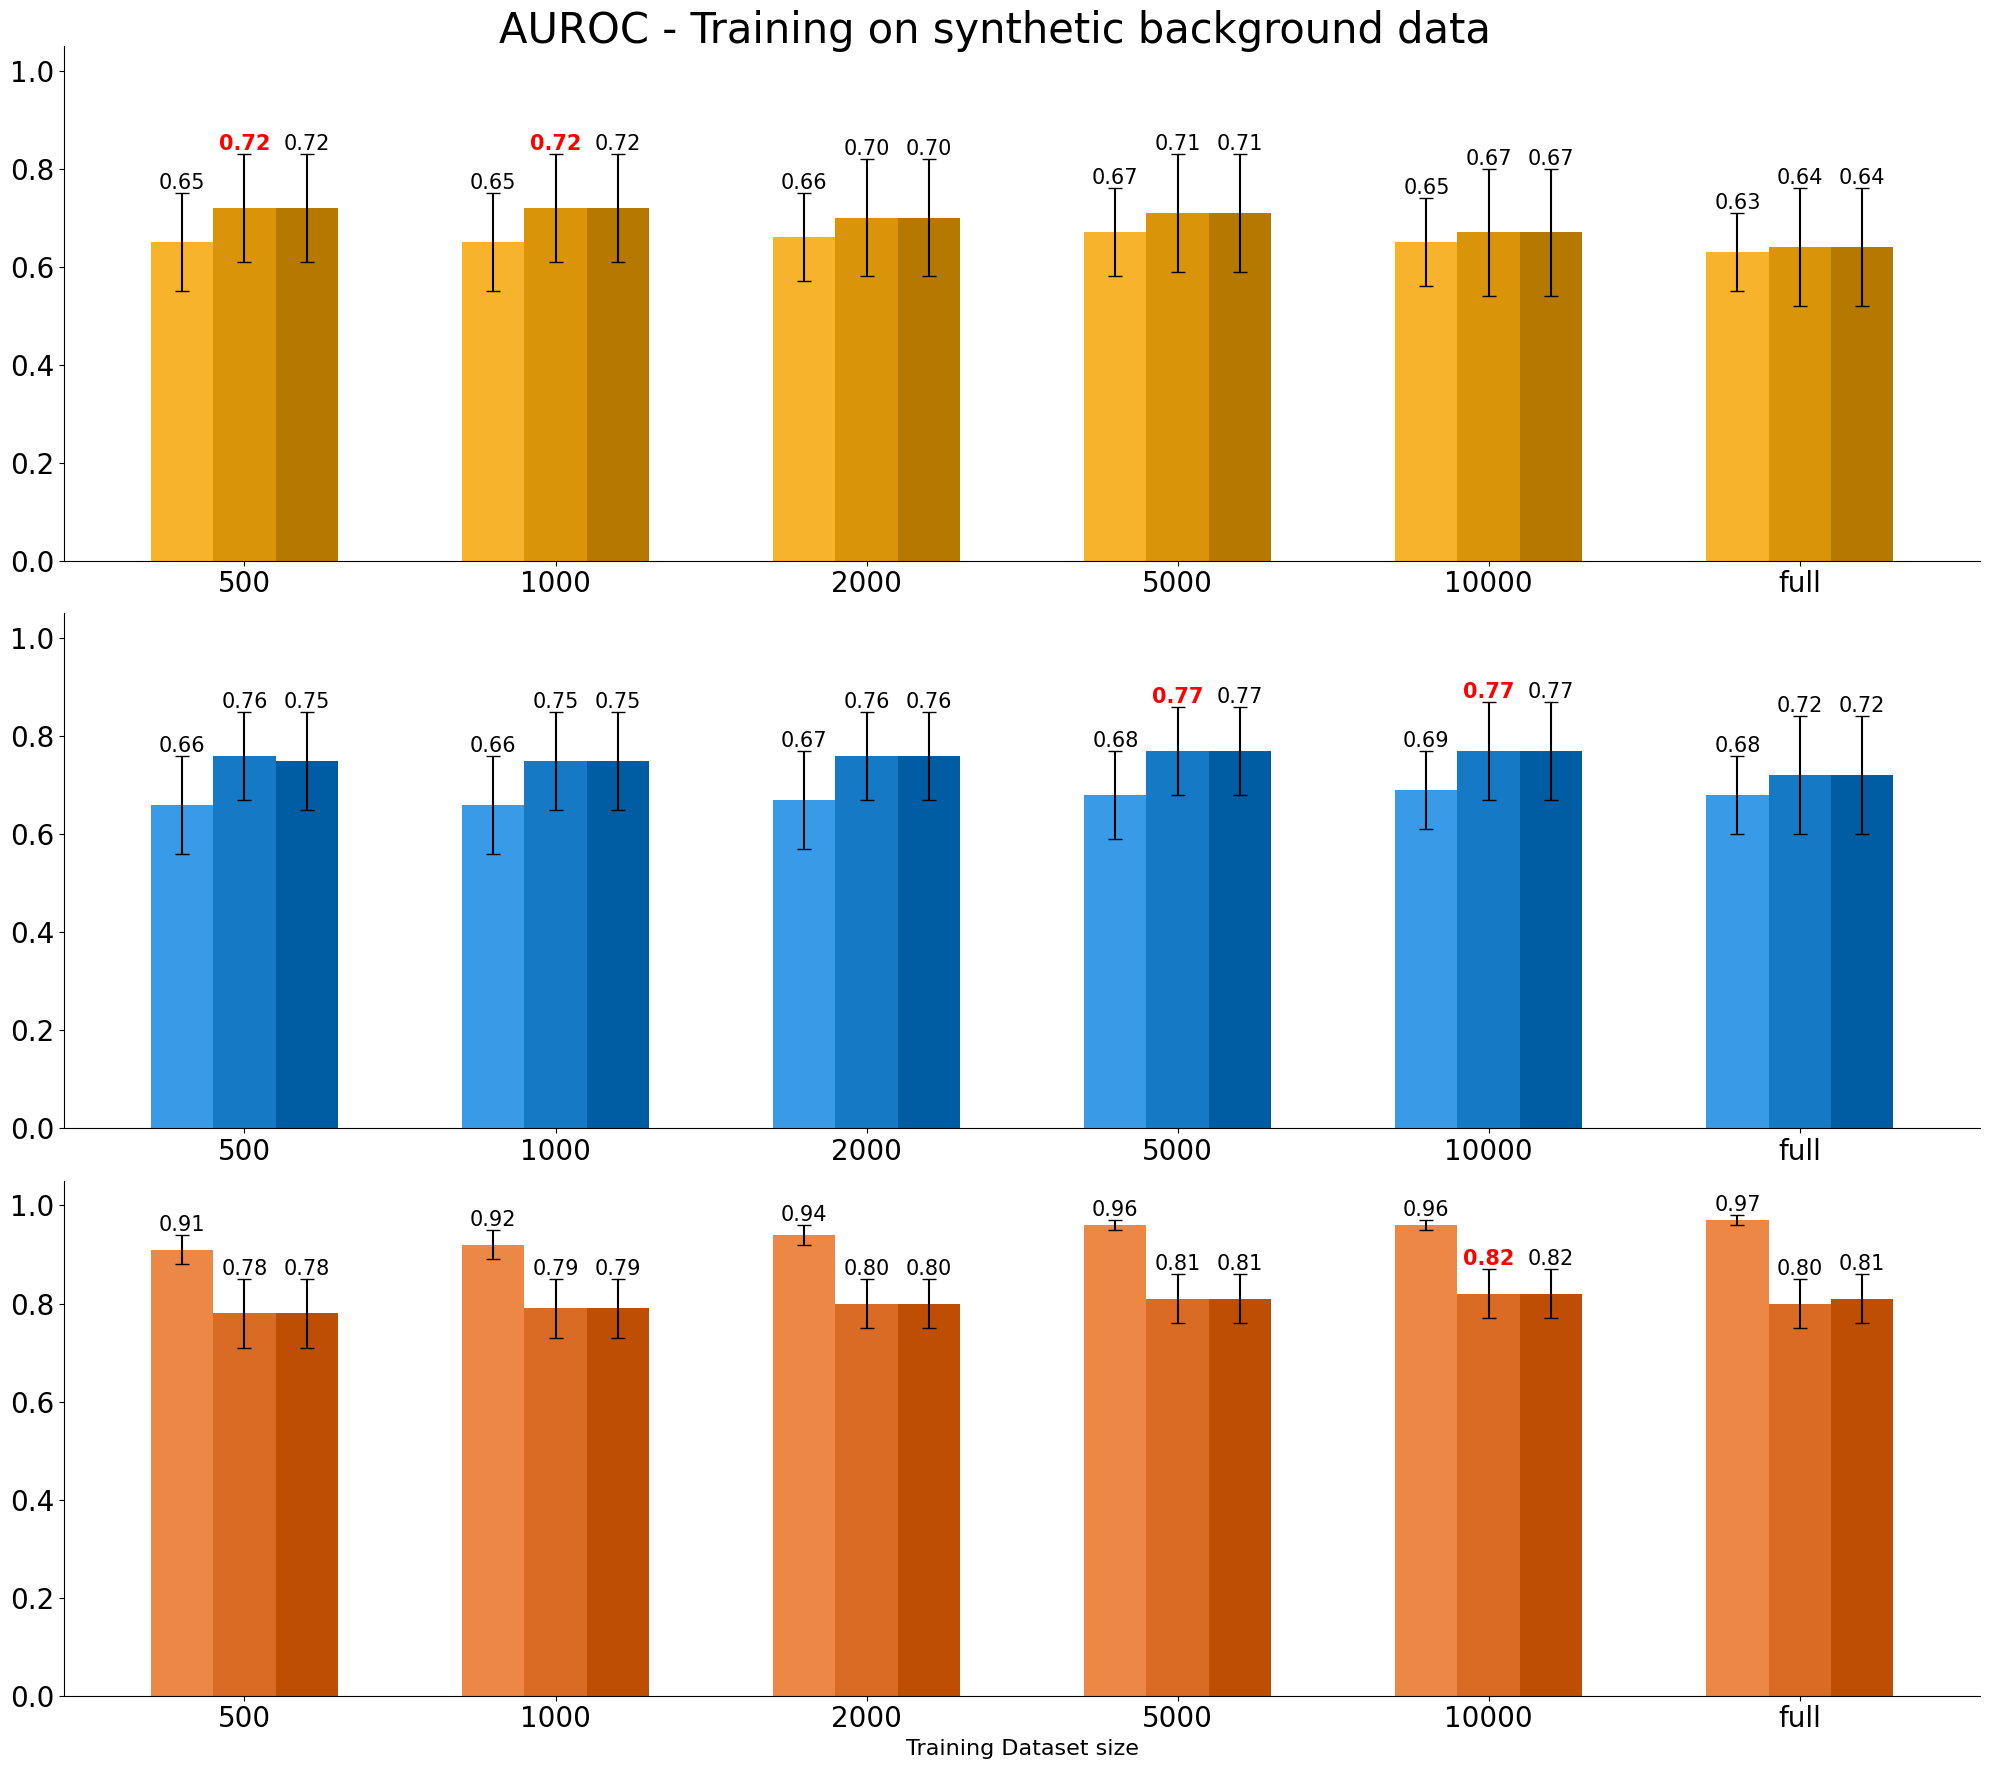

In [ ]:
# AUROC
OUTDIR = "path/to/outdir"
performance_dir = os.path.join(PERFORMANCEDIR, "dataset-size-comparison")
barplot(performance_dir, "AUROC", OUTDIR)

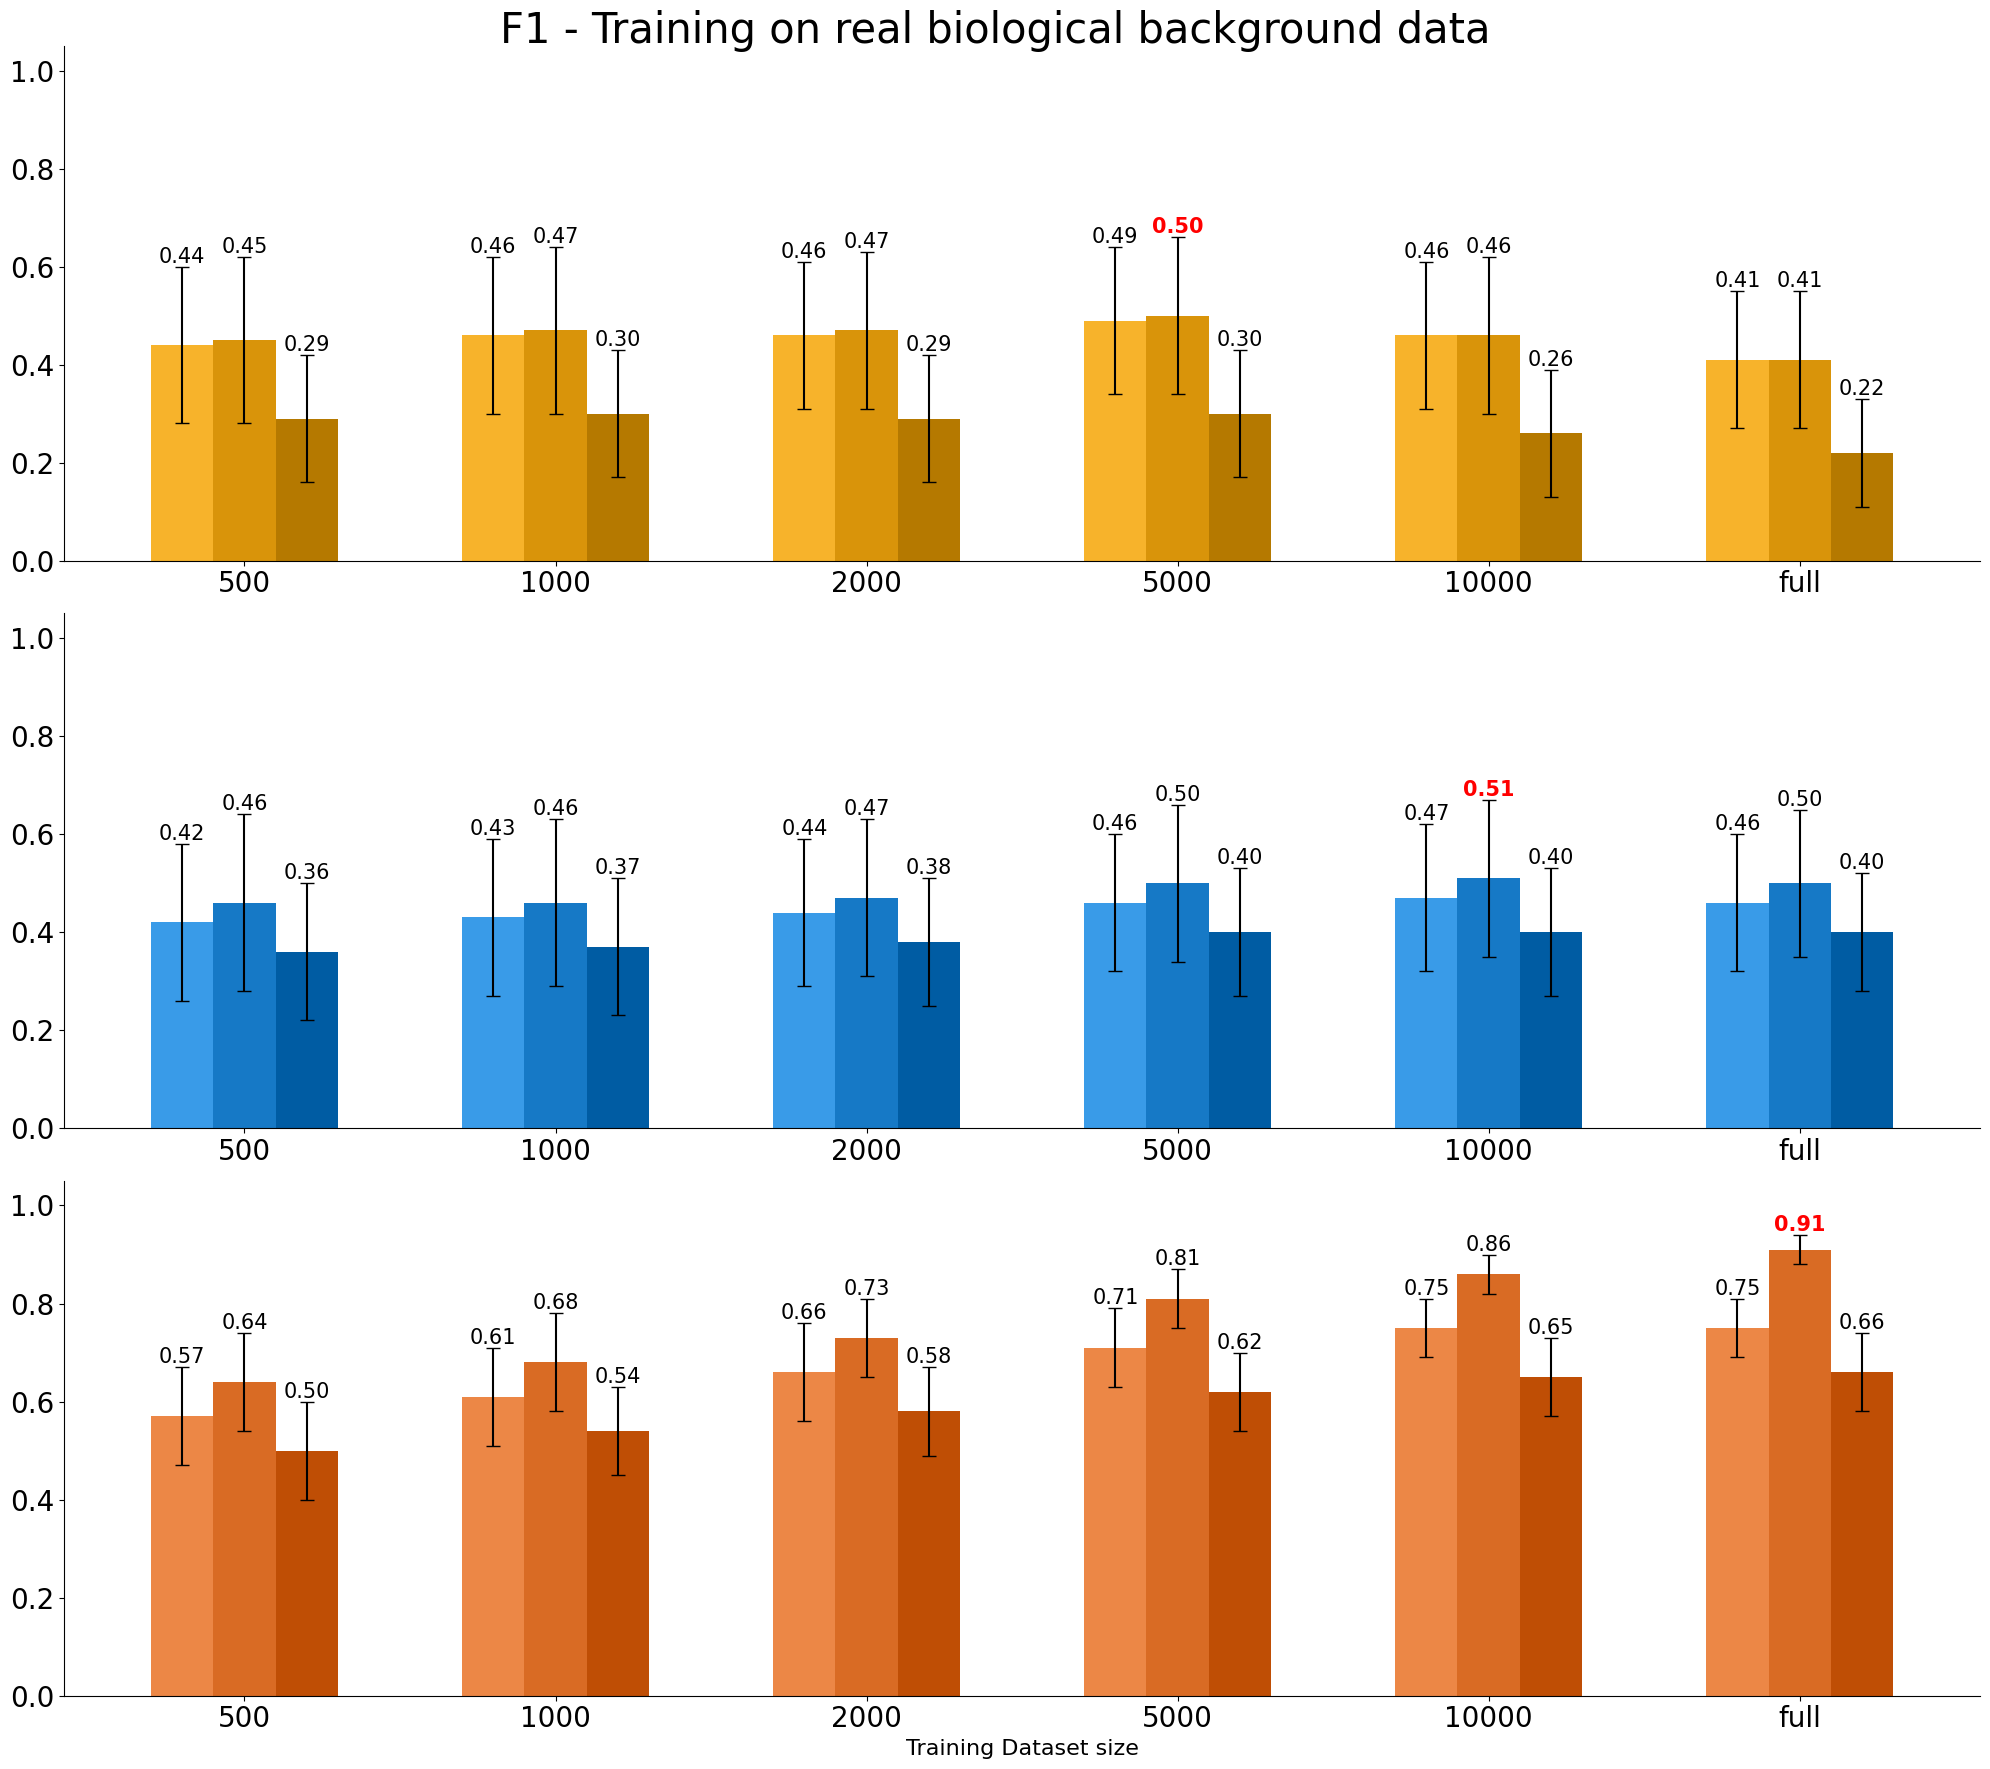

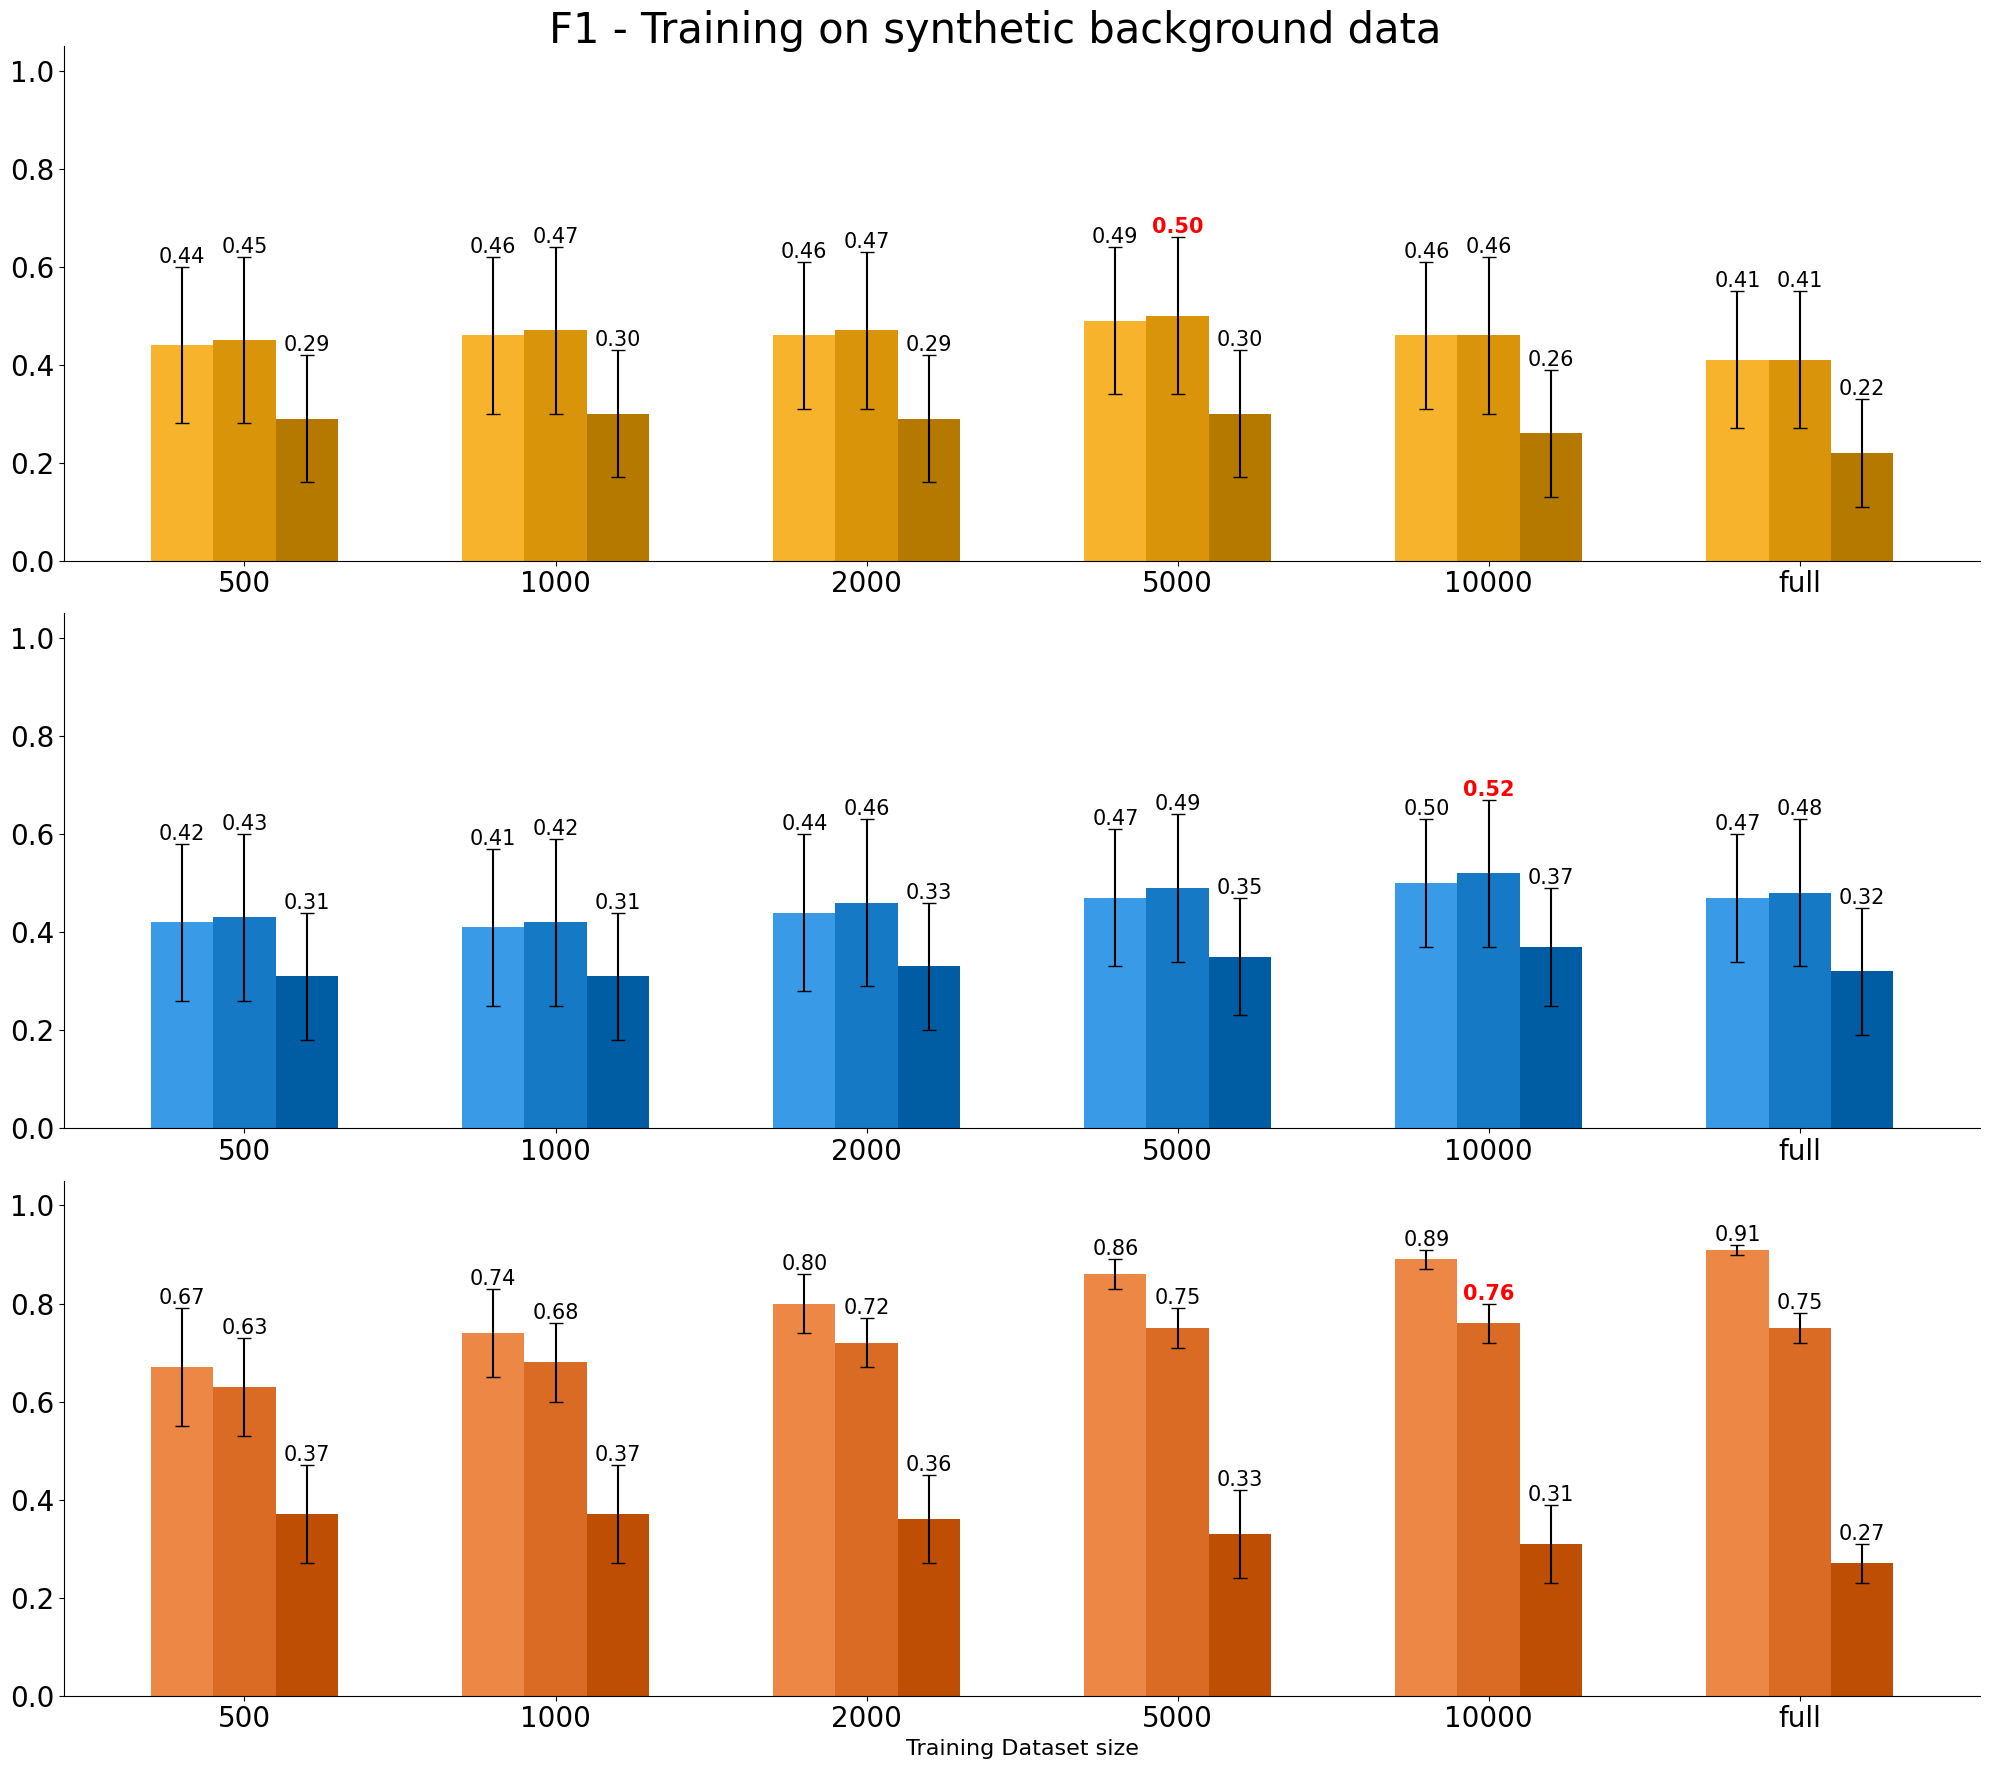

In [ ]:
# F1
OUTDIR = "path/to/outdir"
performance_dir = os.path.join(PERFORMANCEDIR, "dataset-size-comparison")
barplot(performance_dir, "F1", OUTDIR)

# KERNEL

In [ ]:
def compute_mean(infolder, kernel, metric):
    fname = os.path.join(infolder, f"summary_table_kernel_{kernel}_svm.tsv")
    table = pd.read_csv(fname, sep="\t")
    return np.mean(table[metric]).round(2)
 
def compute_std(infolder, kernel, metric):
    fname = os.path.join(infolder, f"summary_table_kernel_{kernel}_svm.tsv")
    table = pd.read_csv(fname, sep="\t")
    return np.std(table[metric]).round(2)
 
def generate_color_variations(base_colors, num_shades=3):
    extended_colors = []
    for color in base_colors:
        rgb = mcolors.hex2color(color)
        shades = [mcolors.to_hex([(c * (1 - 0.2 * i)) for c in rgb]) for i in range(num_shades)]
        extended_colors.extend(shades)  
    return extended_colors
 
def plot(data, std, labels, group_labels, metric, bgtitle):
    num_groups = len(group_labels)  # 6 kernel
    num_bars_per_group = len(labels) // num_groups  # 3 bars for each kernel
    width = 0.3  # bar width
   
    base_colors = ["#d4af5a", "#65d45a", "#5aced4", "#b55ad4", "#d45a74", "#d3d1d1"]
    colors = generate_color_variations(base_colors, num_shades=3)  # 18 colors
 
    f, ax = plt.subplots(figsize=(40, 20), dpi=300)
    x = np.arange(num_groups)  # bar position
 
    legend_handles = []  # to save bars for the legend
    legend_labels = []   # to avoid duplicates
   
    for i in range(num_bars_per_group):
        values = [data[kernel][i] for kernel in group_labels]
        std_values = [std[kernel][i] for kernel in group_labels]
 
        # Unique colors for each bar
        color_index = [j * num_bars_per_group + i for j in range(num_groups)]
        bars = ax.bar(x + i * width, values, width, yerr=std_values, capsize=5,
                      color=[colors[idx] for idx in color_index], error_kw={'elinewidth': 1.5})
 
    
        for bar, label in zip(bars, labels[i::num_bars_per_group]):  
            if label not in legend_labels:  
                legend_handles.append(bar)  
                legend_labels.append(label)  
 
        # Best value to change the color to red
        max_value = max(values)
        max_indices = [idx for idx, val in enumerate(values) if val == max_value]
 
        for bar, std_val, idx in zip(bars, std_values, range(len(values))):
            height = bar.get_height()
            text_color = 'red' if idx in max_indices else 'black'
            ax.text(bar.get_x() + bar.get_width() / 2, height + std_val,
                    f'{height:.2f}', ha='center', va='bottom', fontsize=30,
                    fontweight='bold' if idx in max_indices else 'normal', color=text_color)
 
    ax.set_xlabel("Kernel Types", size=30)
    #ax.set_ylabel(metric, size=14)
    ax.tick_params(axis='y', labelsize=30)
    ax.set_title(f"{metric} - Training on {bgtitle}", size=40)
    ax.set_xticks(x + (num_bars_per_group - 1) * width / 2)
    ax.set_xticklabels(group_labels, size=30)
    #ax.legend(legend_handles, legend_labels, loc='upper center', fontsize=12, frameon=True, ncol=3)
    ax.spines[['right', 'top']].set_visible(False)
    plt.show()

    #f.savefig(f"results/kernel/{metric}_{bgtitle}_kernel.svg", dpi=300)
 
 
 
def barplot(infolder, metric, bg):
    kernels = ["wgkmrbf","wgkm","gkmrbf","gkm","gappedkmer","estlmer"]
    data = {k: [] for k in kernels}
    std = {k: [] for k in kernels}
    for kernel in kernels:
        for i, bt in enumerate(BGTEST):
            tablesdir = os.path.join(infolder, f"{bg}-{bt}")
            data[kernel].append(compute_mean(tablesdir, kernel, metric))
            std[kernel].append(compute_std(tablesdir, kernel, metric))
    labels = [f"{kernel} - test background: {testbg}" for kernel in kernels for testbg in BGTEST]
    bgtitle = "real biological background data" if bg == "dnase" else "synthetic background data"
    plot(data, std, labels, kernels, metric, bgtitle)

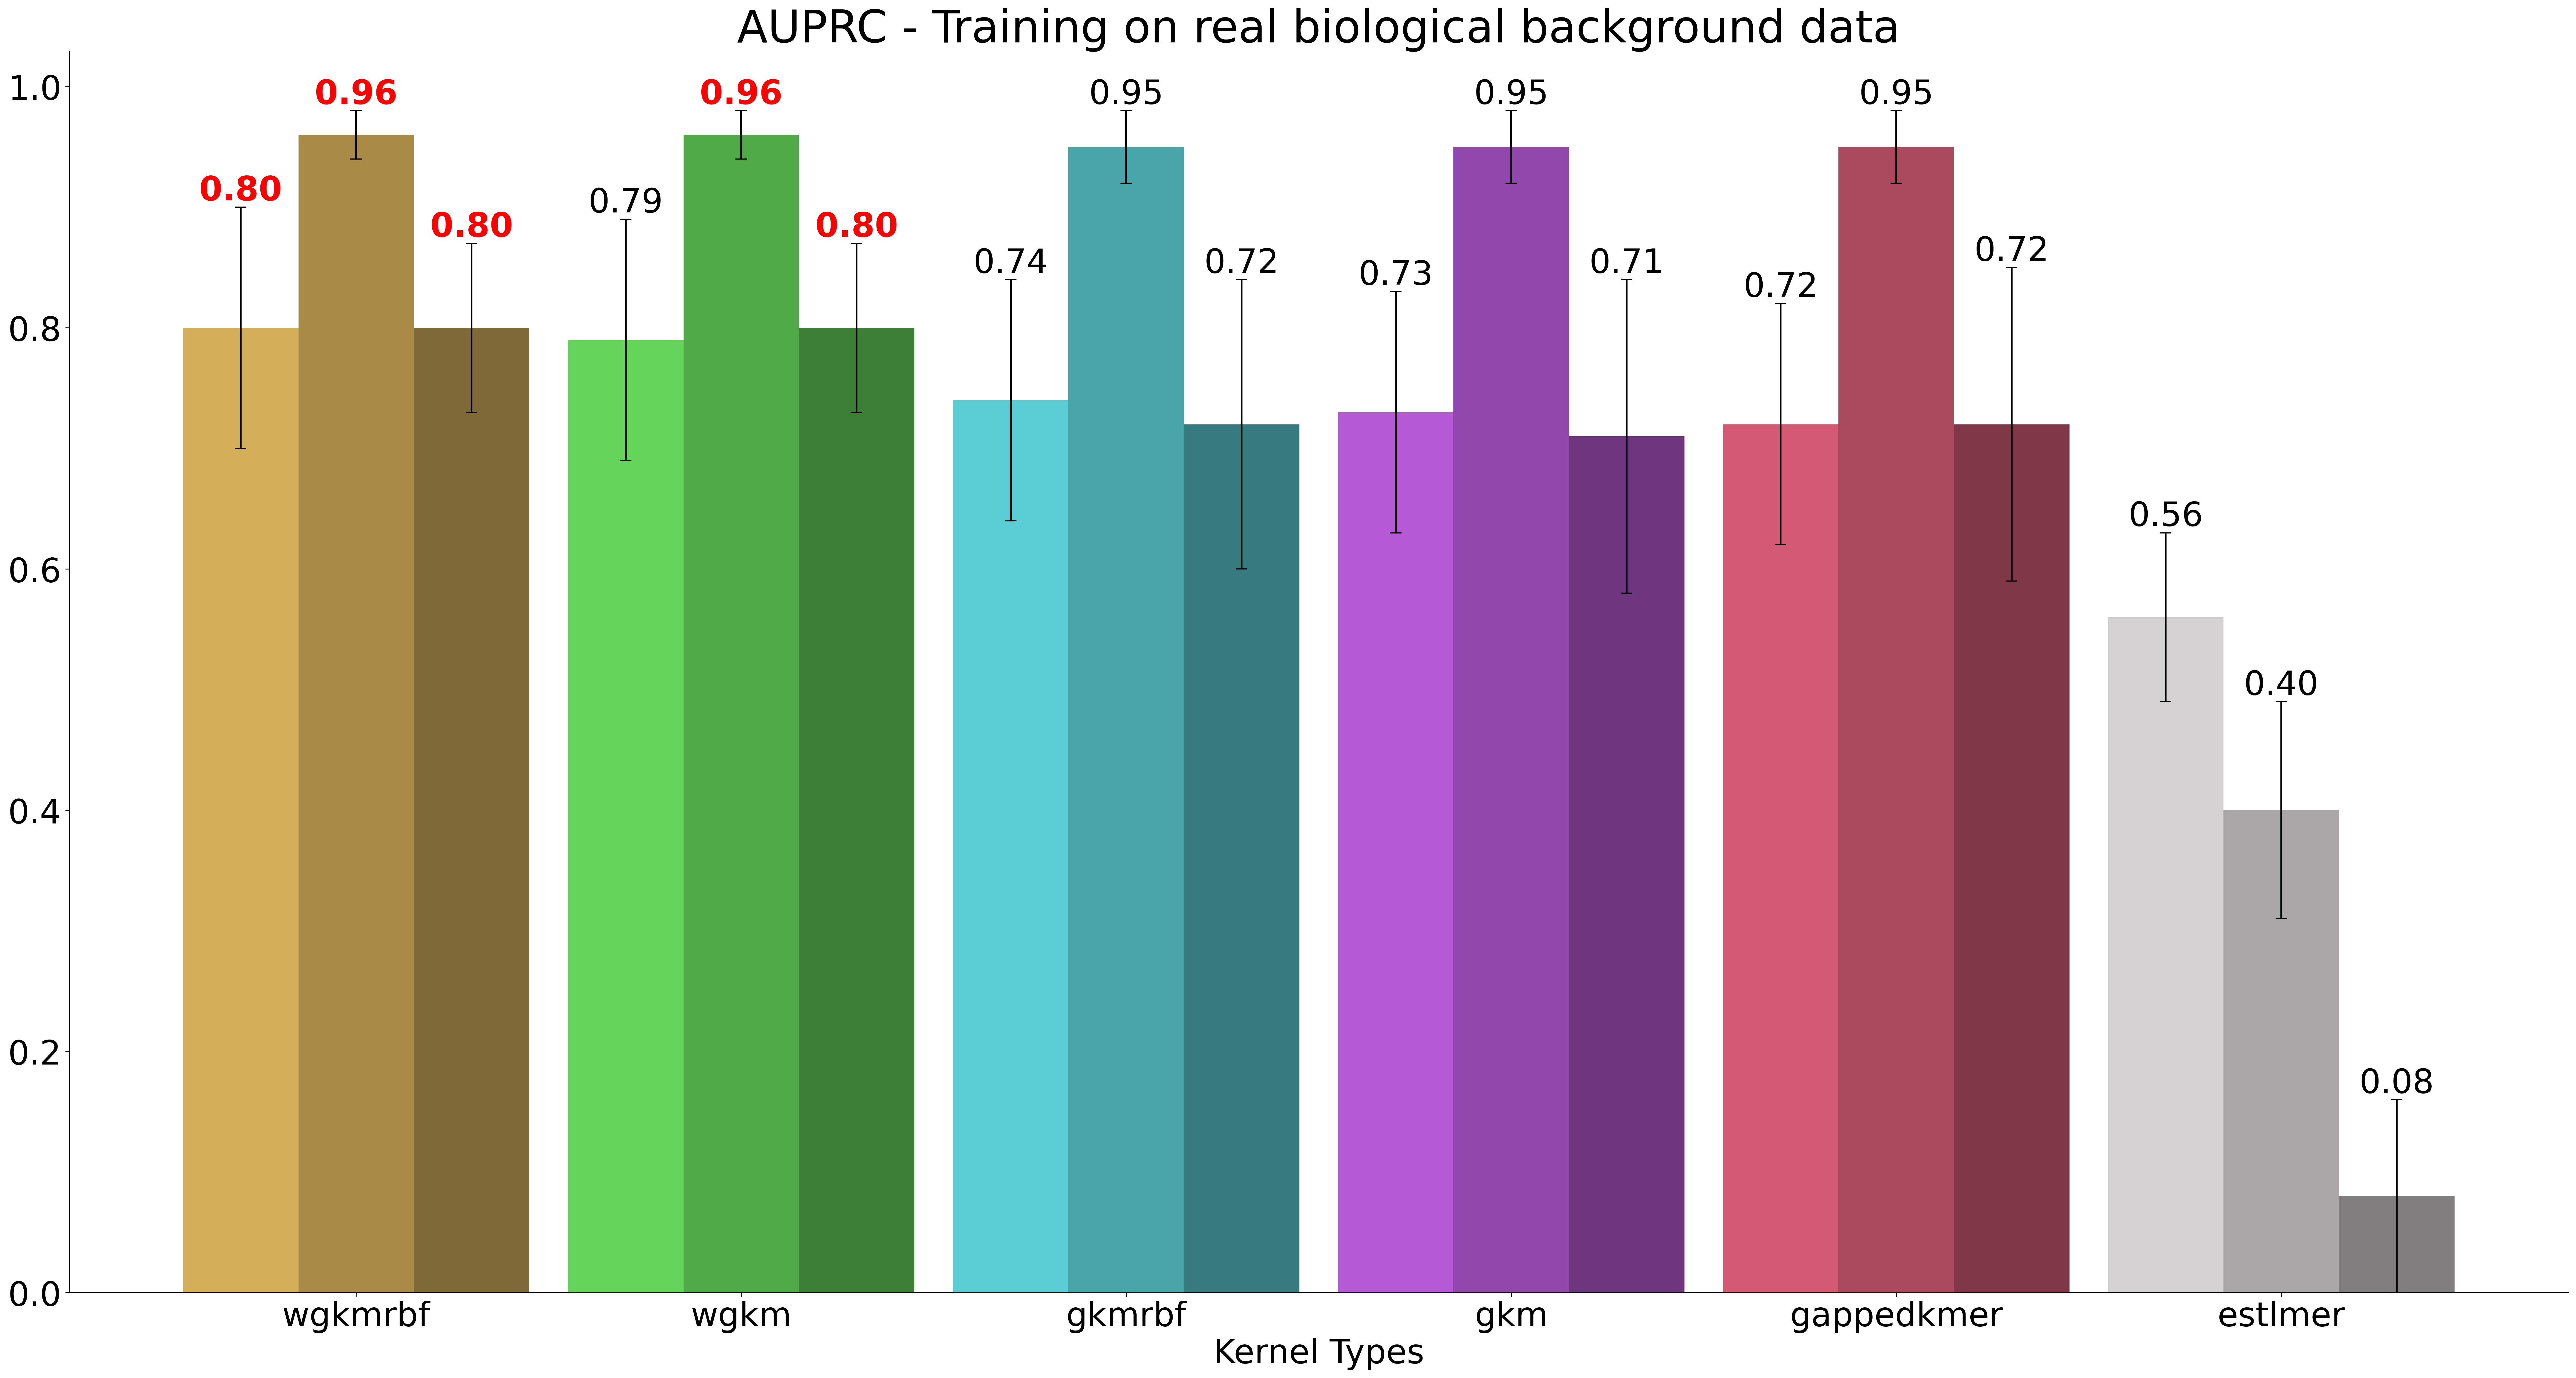

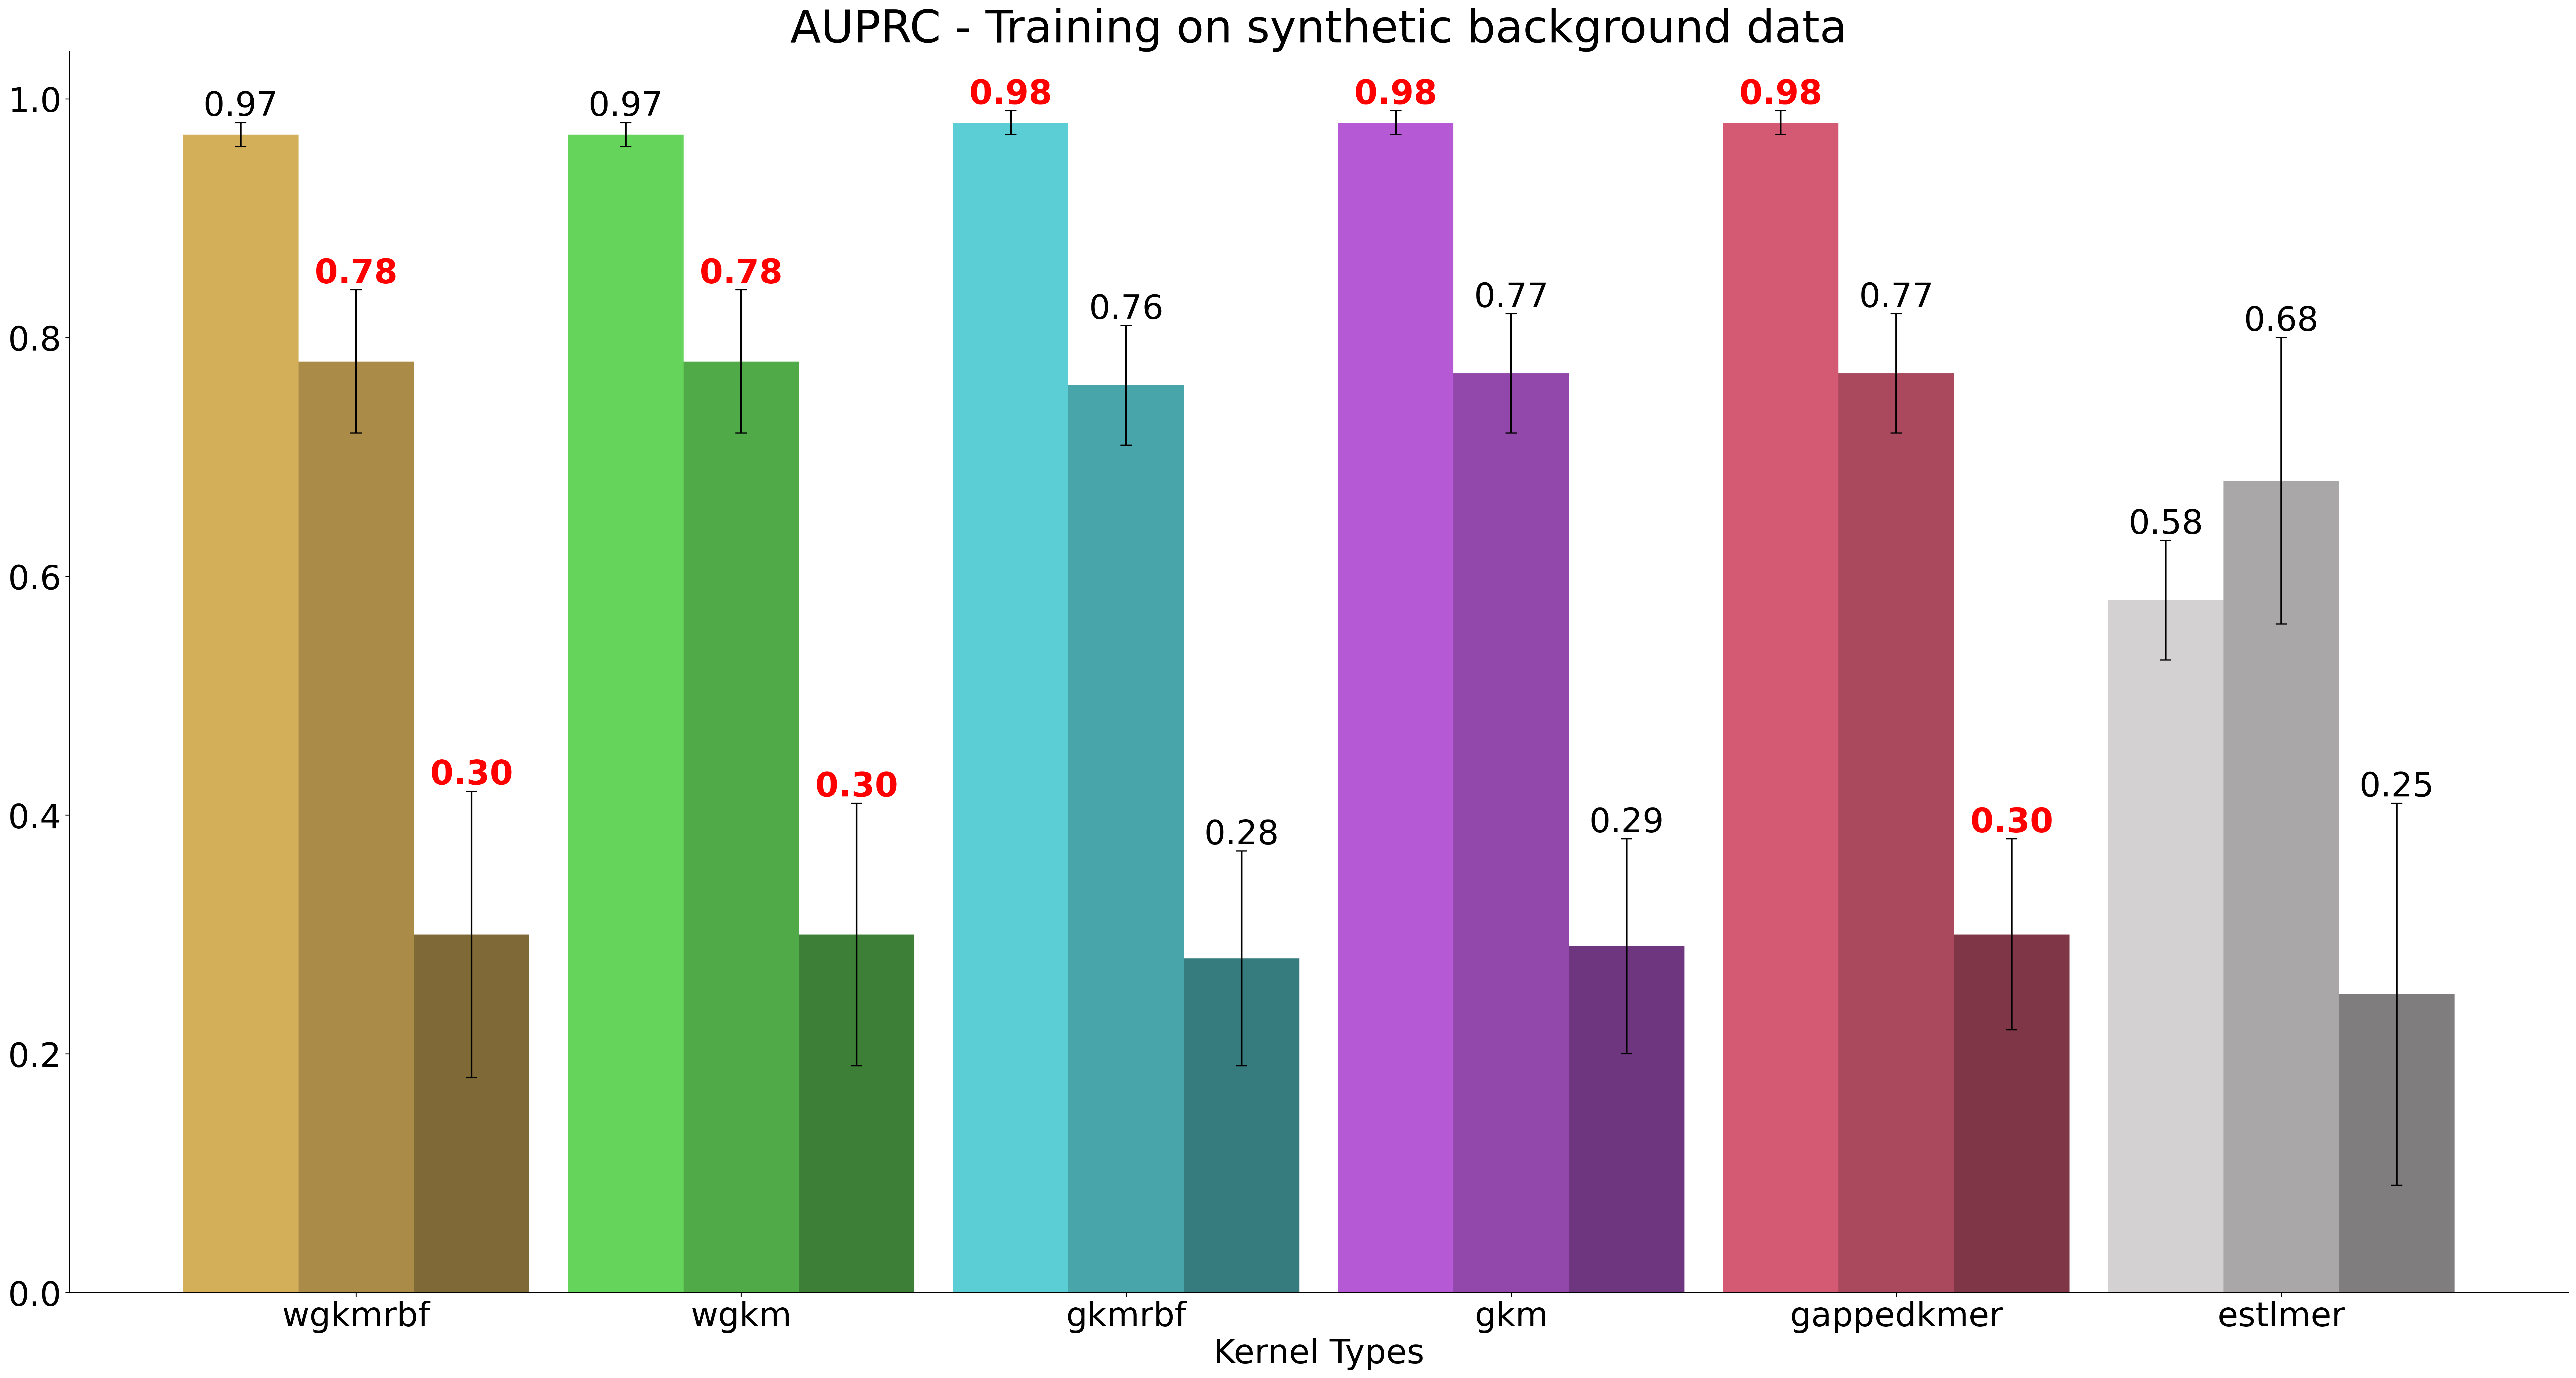

In [19]:
# AUPRC
performance_dir = os.path.join(PERFORMANCEDIR, "svm-kernels-comparison")
for bg in ["dnase", "shuffle"]:
    barplot(performance_dir, "AUPRC", bg)

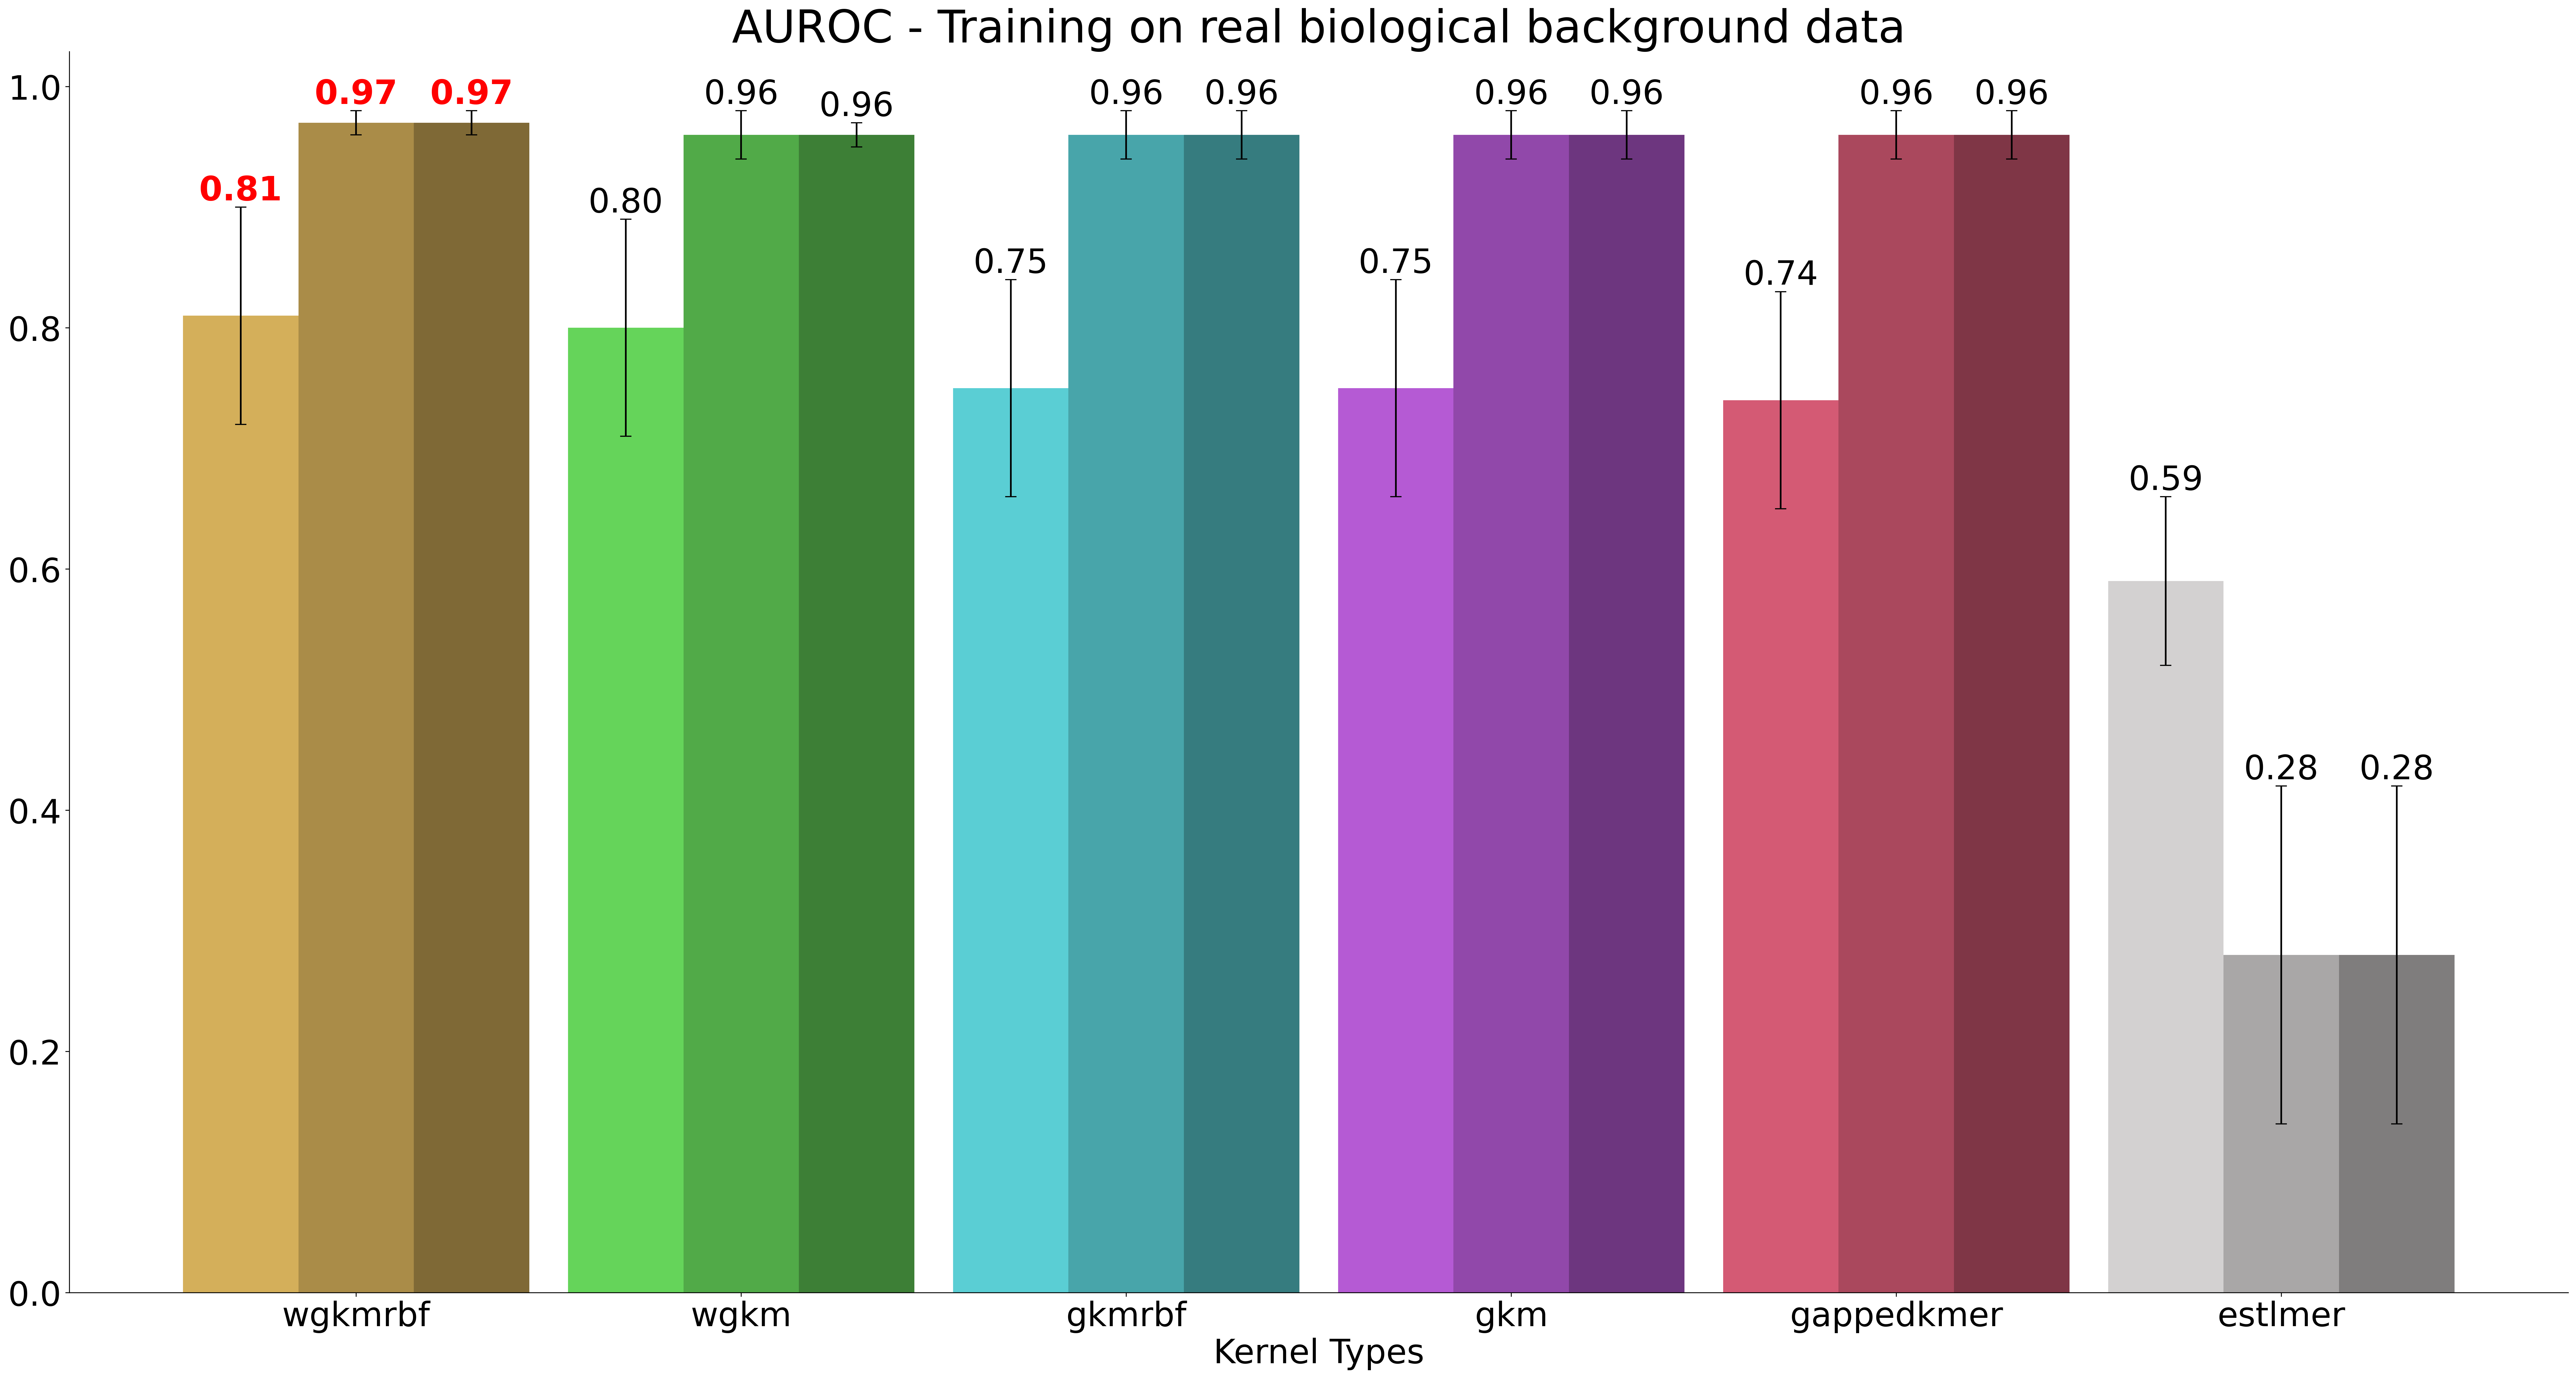

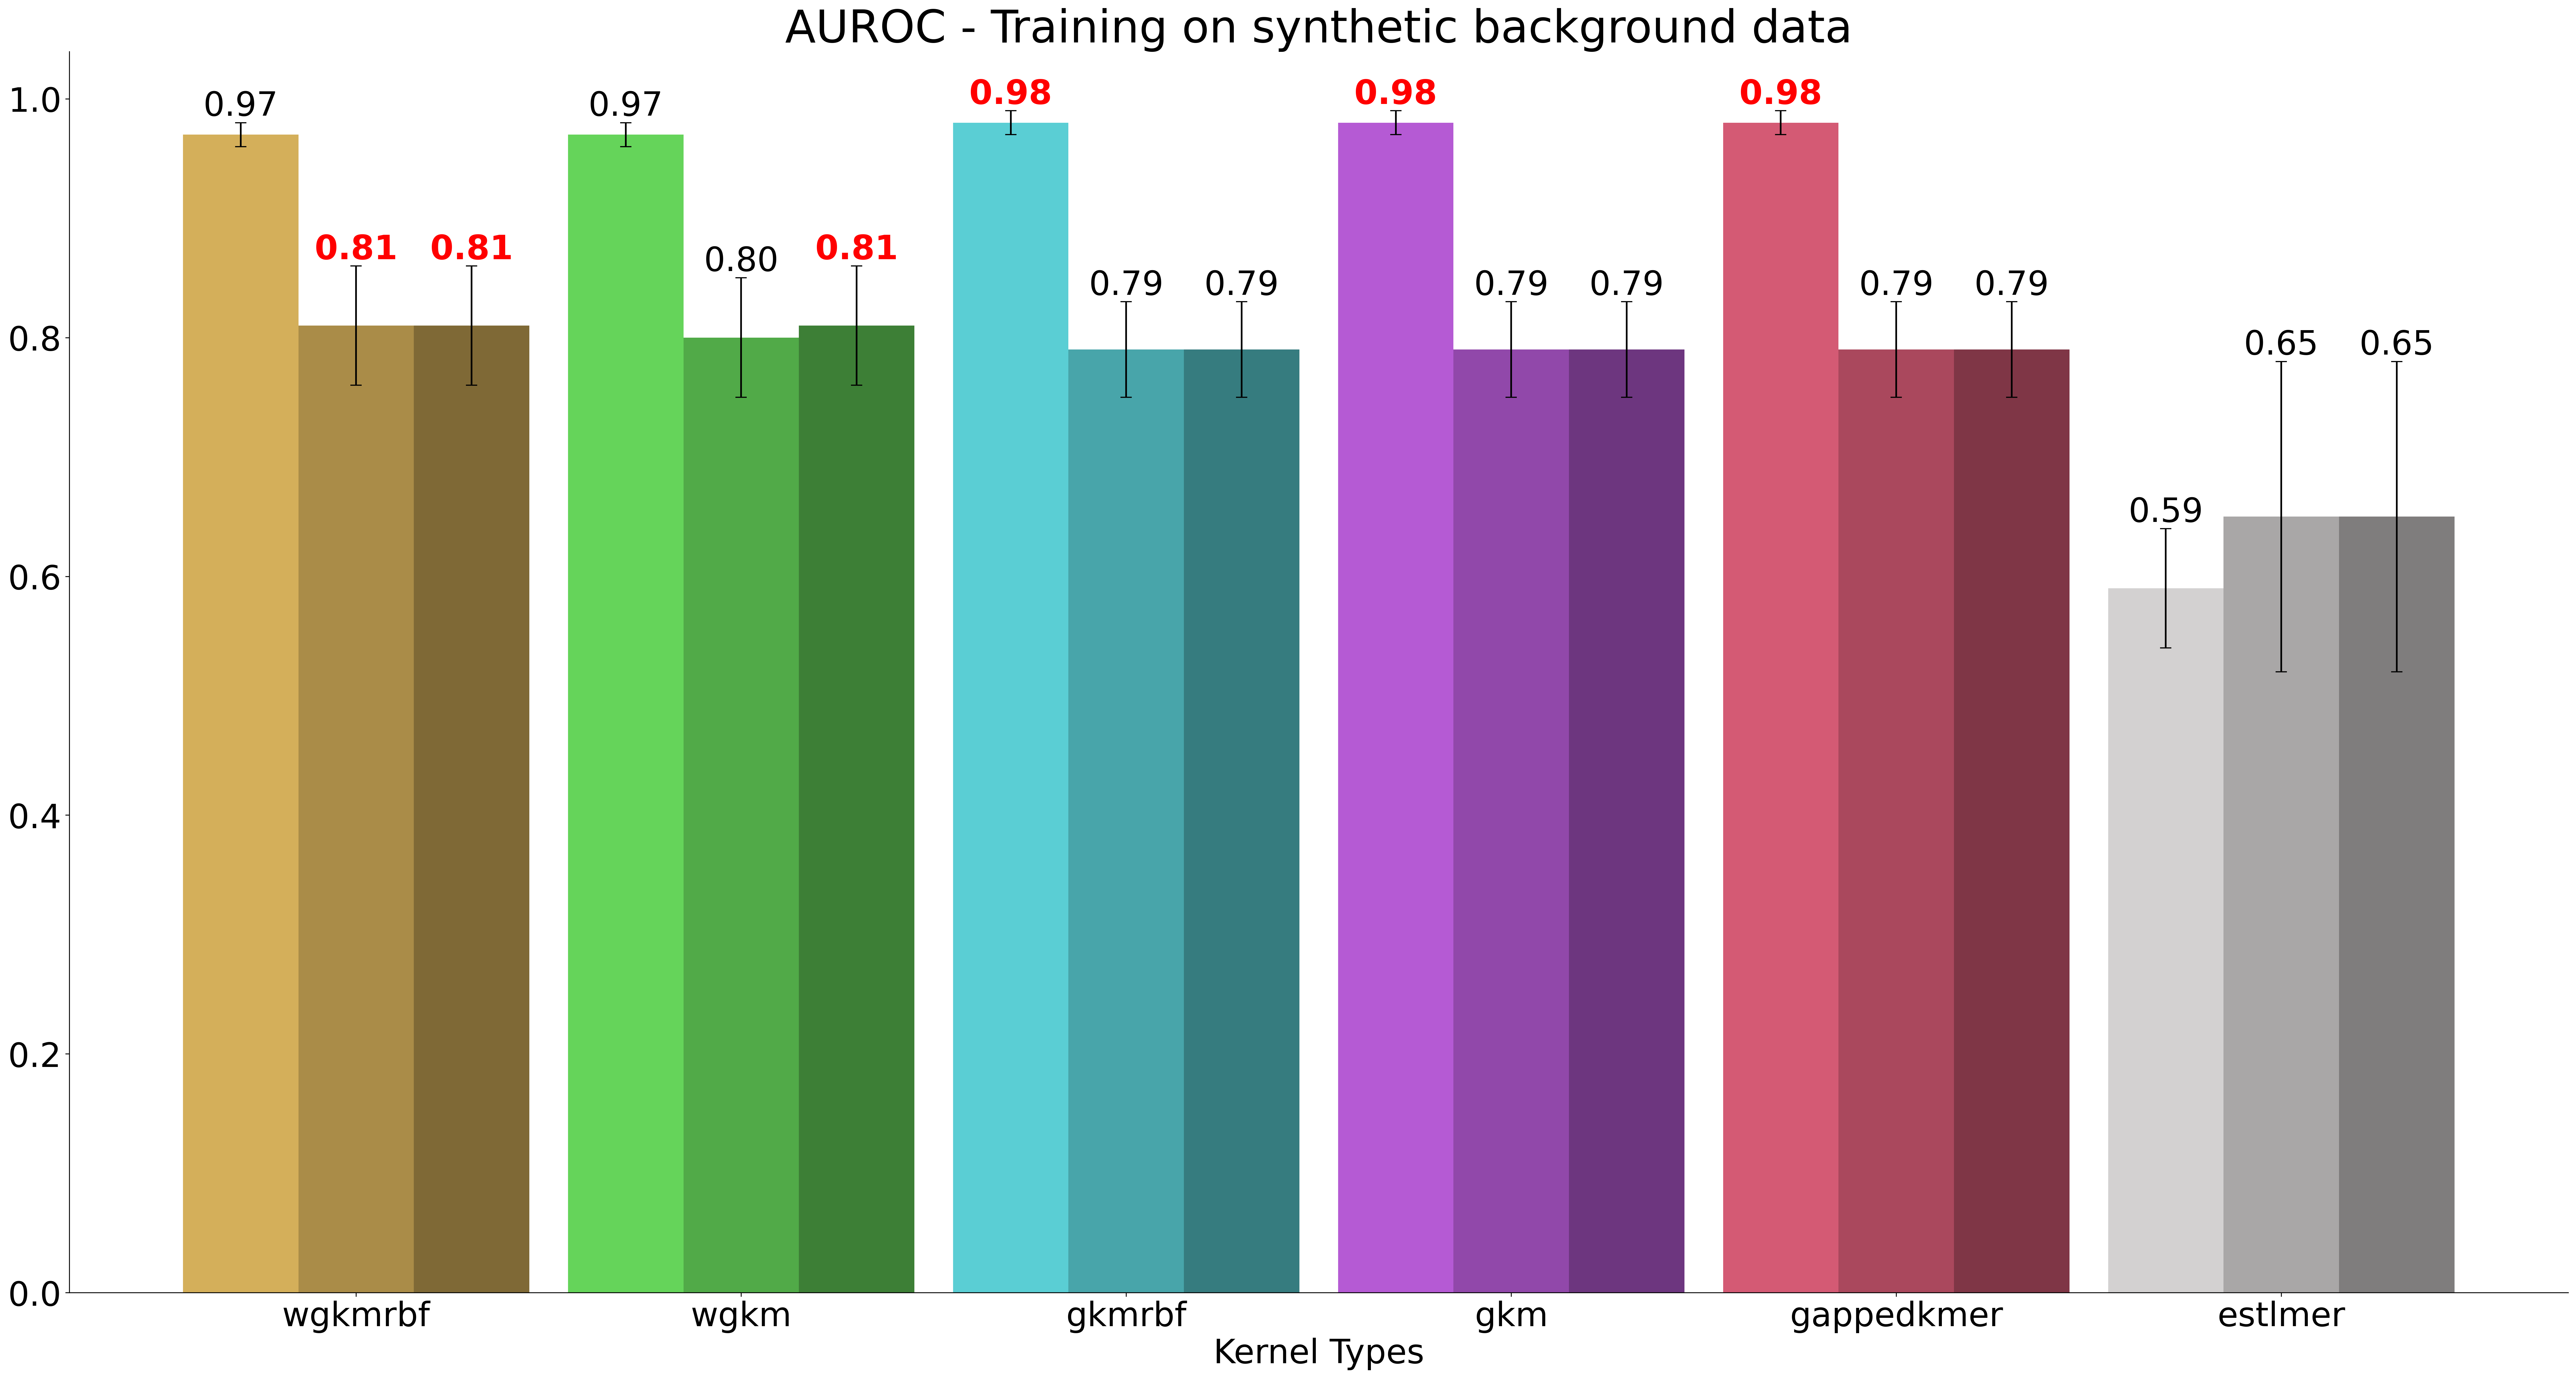

In [20]:
# AUROC
performance_dir = os.path.join(PERFORMANCEDIR, "svm-kernels-comparison")
for bg in ["dnase", "shuffle"]:
    barplot(performance_dir, "AUROC", bg)

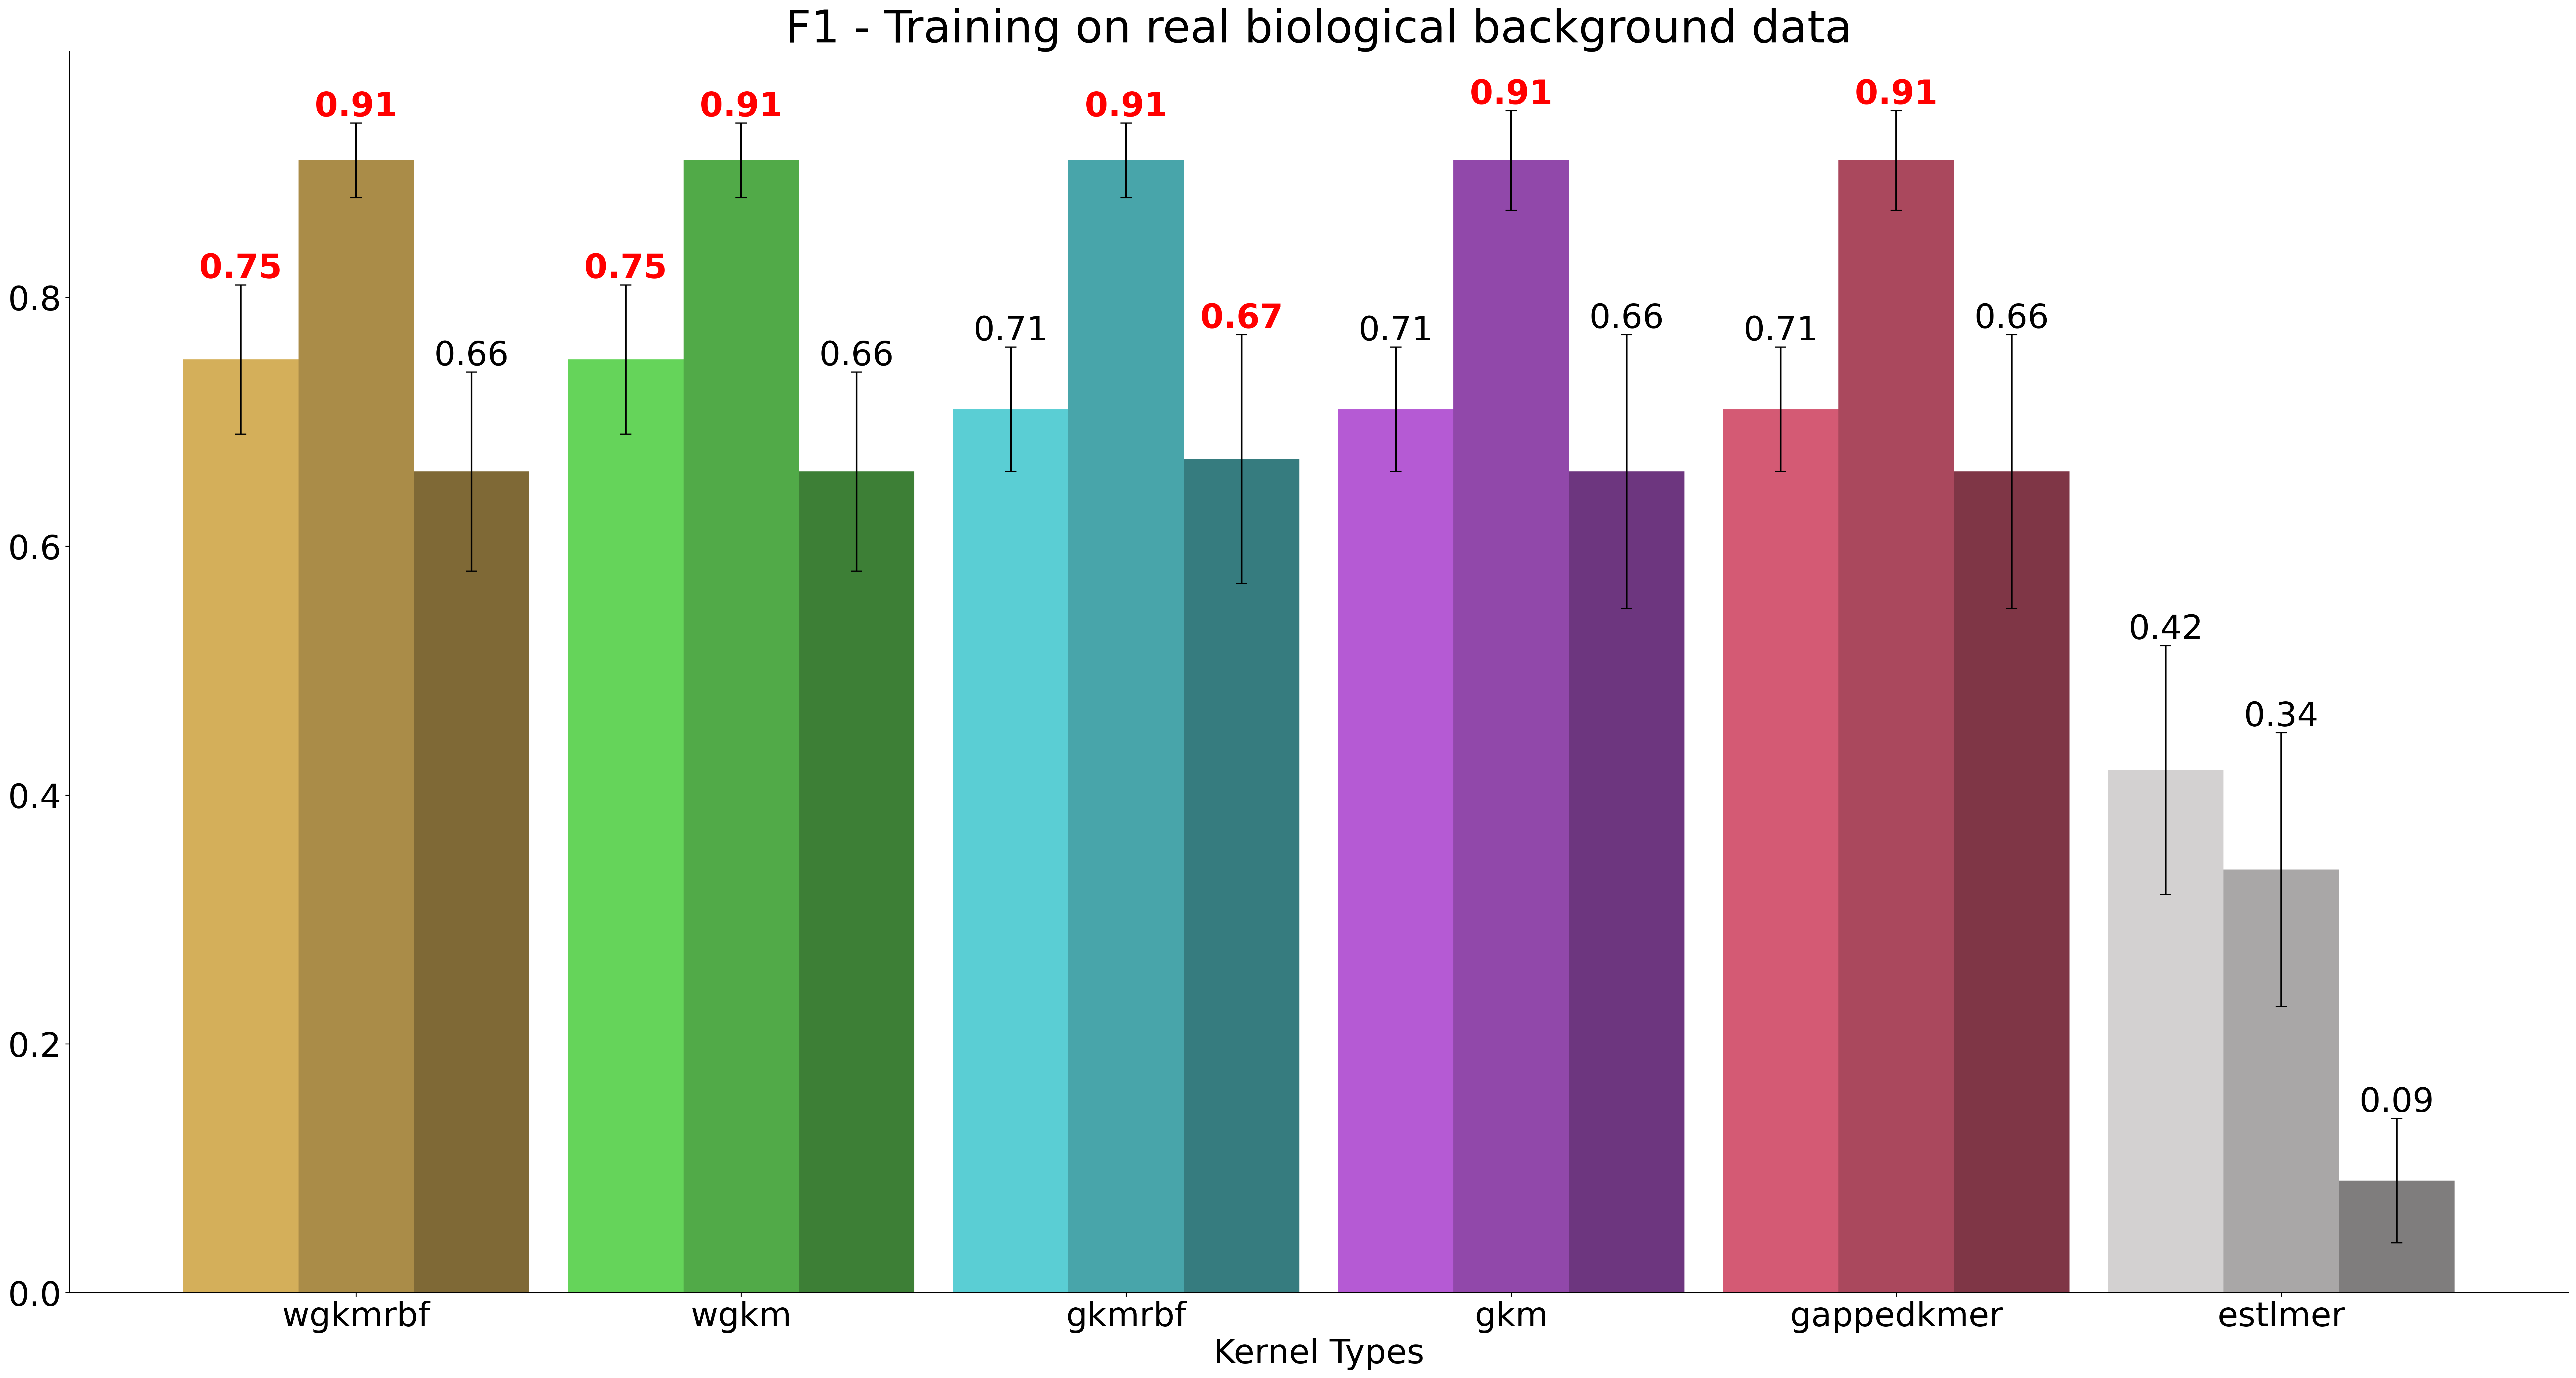

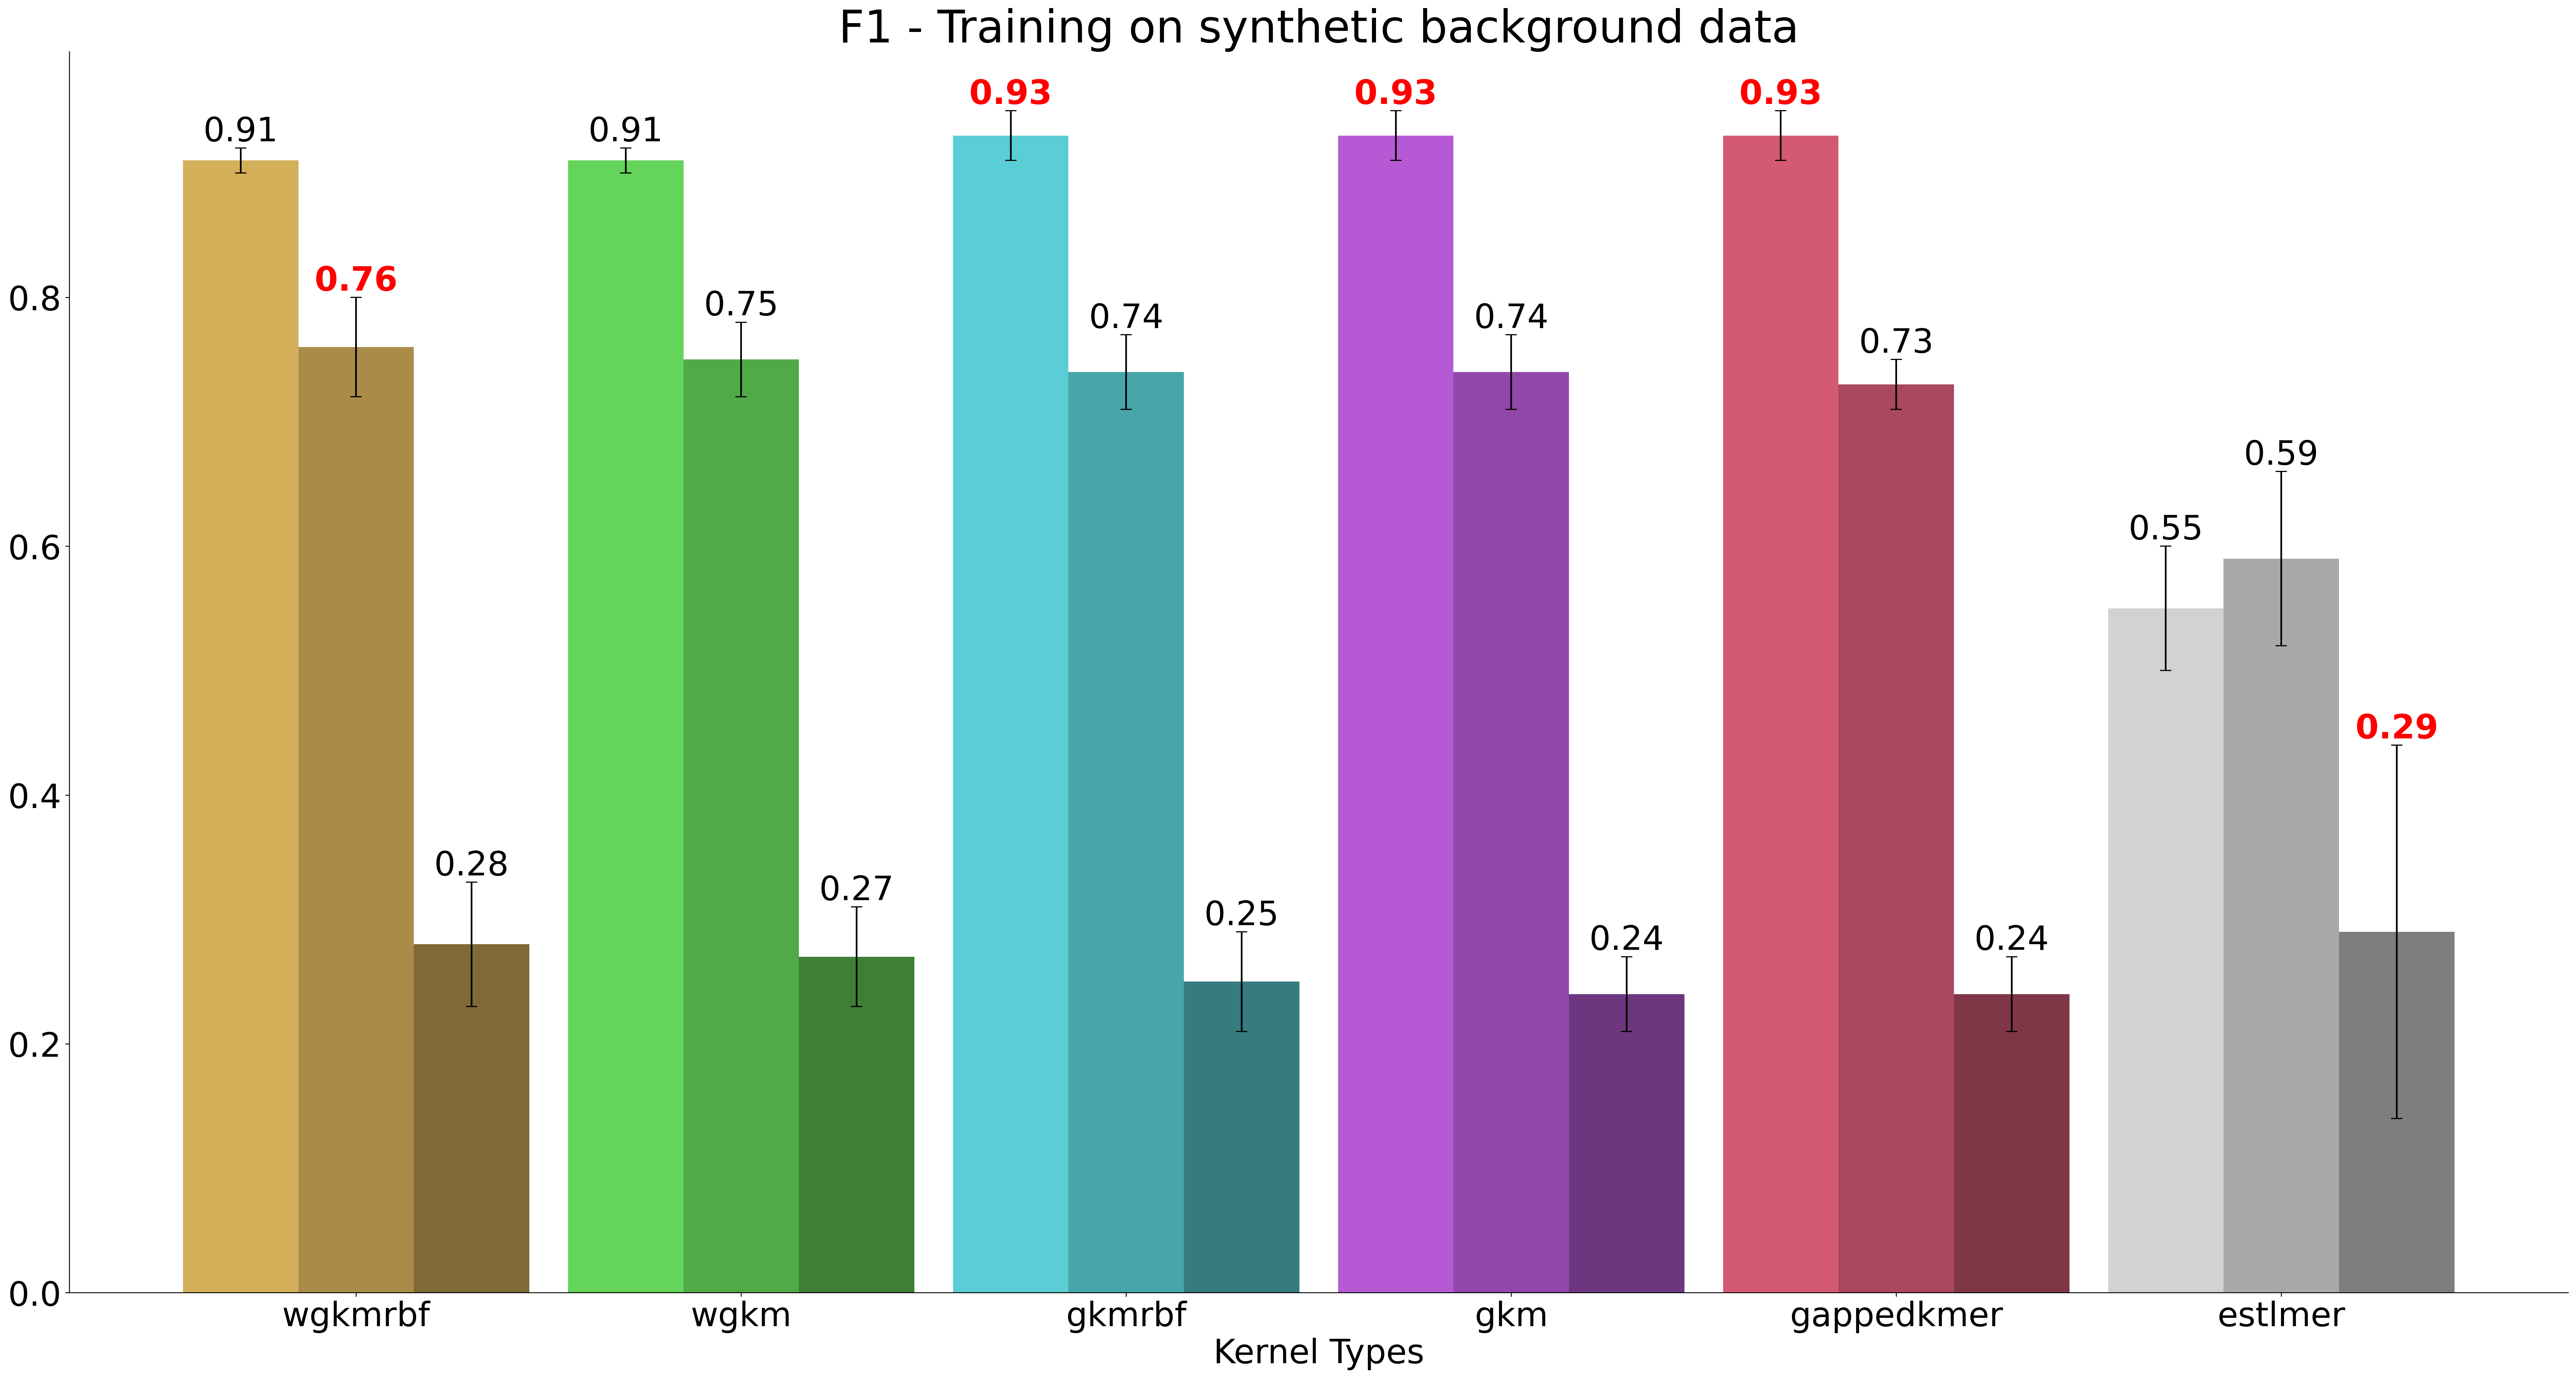

In [21]:
# F1
performance_dir = os.path.join(PERFORMANCEDIR, "svm-kernels-comparison")
for bg in ["dnase", "shuffle"]:
    barplot(performance_dir, "F1", bg)